### Laboratorio 6 - Generative Adversarial Network
Stefano Aragoni, Carol Arévalo

-----------

En esta práctica se diseñó una Generative Adversarial Network (GAN) con el propósito de poder generar imágenes artificiales que imiten la distribución de los datos originales Para esto, fue necesario diseñar una red neuronal que fuera capaz de generar imágenes, y otra red neuronal que fuera capaz de diferenciar entre imágenes reales y generadas. 

A continuación se muestra el código utilizado para la creación de la GAN, así como los resultados obtenidos.

------- 

##### Importar librerías

Como primer paso, se importaron las librerías necesarias para la creación de la GAN.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
import tensorflow as tf
from keras.layers import Dense, Reshape, Dropout, LeakyReLU, Flatten, BatchNormalization, Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import Adam
import os
import cv2
from tqdm import tqdm 
import pickle
from keras.preprocessing.image import ImageDataGenerator
import sys

--------
### **Preparación de Datos**

##### Cargar el dataset de CelebA y Preprocesamiento de Datos 

Para iniciar, se descargó el dataset de CelebA. Este conjunto de datos consta de más de 200,000 imágenes a color, de 128 X 128 X 3 c/u. A continuación se muestra la ubicación de las imágenes en el dataset.

In [2]:
# Direcciones de los archivos
fotos_dir = 'archive/img_align_celeba/'
fotos_dir_class = 'archive/img_align_celeba/img_align_celeba/'

# Cantidad de fotos en el directorio
n_fotos = len(os.listdir(fotos_dir_class))
print(n_fotos, "fotos en el directorio")

202599 fotos en el directorio


A través de la librería de Keras, se cargaron las imágenes por batches.

Asimismo, se les aplicó un preprocesamiento, el cual consistió en normalizar los valores de los pixeles de las imágenes, recortarlas y redimensionarlas a 64 X 64 X 3.

In [3]:
# Batch size
batch_size = 75000

# Tamaño de las imágenes
img_size = 64

In [4]:
# Leer las imagenes -> Función recomendada por Prof. Luis Furlan.

datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,                    # PRE-PROCESAMIENTO: Normalizar los valores de los pixeles
    horizontal_flip=True,
)

In [5]:
# Carga las imagenes de entrenamiento

train_generator = datagen.flow_from_directory(
    fotos_dir,
    target_size=(img_size, img_size),        # PRE-PROCESAMIENTO: RECORTAR Y REDIMENSIONAR IMÁGENES
    batch_size=batch_size,
    class_mode=None,
    subset='training'
)

Found 202599 images belonging to 1 classes.


(75000, 64, 64, 3)


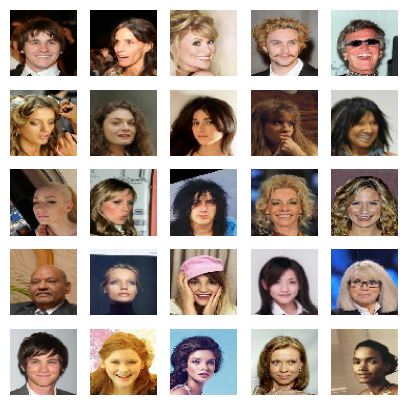

In [6]:
# Mostrar 25 imagenes de entrenamiento

X_train = train_generator[0]
print(X_train.shape)
fig, axs = plt.subplots(5, 5, figsize=(5, 5))

for i in range(5):
    for j in range(5):
        img = X_train[i * 5 + j]
        axs[i, j].imshow(img)
        axs[i, j].axis('off')

plt.show()

--------
### **Implementación de la GAN**

##### Diseño del generador y el discriminador

A continuación se demuestra el modelo del <font color=orange>generador</font>. En este caso, se utilizó una red neuronal, la cual utiliza relu y sigmoid como funciones de activación. Se encargará de generar imágenes a partir de un vector de ruido.

In [7]:
tamanio_codificacion = 100

img_shape = train_generator[0].shape[1:]
print(img_shape)

(64, 64, 3)


In [8]:
# Generador
generador = Sequential()
generador.add(Dense(8 * 8 * 256, input_shape=[tamanio_codificacion])) 
generador.add(Reshape([8, 8, 256]))
generador.add(BatchNormalization())
generador.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding="same", activation="relu"))  
generador.add(BatchNormalization())
generador.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="relu"))  
generador.add(BatchNormalization())
generador.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding="same", activation="sigmoid")) 

A continuación se demuestra el modelo del <font color=orange>discriminador</font>. El discriminador es una red neuronal, la cual utiliza relu y sigmoid como funciones de activación. Esta se encarga de diferenciar entre imágenes reales y generadas.

In [9]:
# Discriminador
discriminador = Sequential()
discriminador.add(Conv2D(64, kernel_size=5, strides=2, padding="same", input_shape=(64, 64, 3)))
discriminador.add(LeakyReLU(0.3))
discriminador.add(Dropout(0.5))
discriminador.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminador.add(LeakyReLU(0.3))
discriminador.add(Dropout(0.5))
discriminador.add(Flatten())
discriminador.add(Dense(1, activation="sigmoid"))

##### Definición de funciones de pérdida y optimizadores

Con los modelos listos, se procedió a definir las funciones de pérdida y los optimizadores. Esto con el propósito de poder entrenar la GAN. Más específicamente, se utilizó la función de <font color=orange>Binary Cross Entropy</font> (BCE) como función de pérdida, y el <font color=orange>optimizador Adam</font>. 

Asimismo, se indicó que el discriminador no se entrenaría durante el entrenamiento de la GAN, ya que el objetivo es entrenar al generador para que engañe al discriminador.

In [10]:
# Compilar Discriminador
discriminador.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# Generador
z = Input(shape=(tamanio_codificacion,))
img = generador(z)

# El discriminador no debe ser entrenado durante el entrenamiento del generador
discriminador.trainable = False

# Discriminador para evaluar el generador
validity = discriminador(img)

# El modelo combinado
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.002, 0.5))

--------
### **Entrenamiento de la GAN**

##### Implementación del bucle de entrenamiento

In [11]:
# Entrenamiento
epochs = 1000
batch_size = 128
half_batch = batch_size // 2

for epoch in tqdm(range(epochs)):
    
    # Entrenar el discriminador
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    real_imgs = X_train[idx]
    noise = np.random.normal(0, 1, (half_batch, tamanio_codificacion))
    gen_imgs = generador.predict(noise)
    real_labels = np.ones((half_batch, 1))
    fake_labels = np.zeros((half_batch, 1))
    d_loss_real = discriminador.train_on_batch(real_imgs, real_labels)
    d_loss_fake = discriminador.train_on_batch(gen_imgs, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Entrenar el generador
    noise = np.random.normal(0, 1, (batch_size, tamanio_codificacion))
    valid_labels = np.ones((batch_size, 1))
    g_loss = combined.train_on_batch(noise, valid_labels)

    # Imprimir el progreso
    print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

  0%|          | 0/1000 [00:00<?, ?it/s]

2/2 [==============================] - 0s 61ms/step


  0%|          | 1/1000 [00:04<1:08:07,  4.09s/it]

0/1000 [D loss: 0.828371524810791 | D accuracy: 37.5] [G loss: 0.5645105838775635]
2/2 [==============================] - 0s 56ms/step


  0%|          | 2/1000 [00:05<43:26,  2.61s/it]  

1/1000 [D loss: 0.7199229300022125 | D accuracy: 49.21875] [G loss: 0.5434762835502625]
2/2 [==============================] - 0s 69ms/step


  0%|          | 3/1000 [00:07<36:04,  2.17s/it]

2/1000 [D loss: 0.7104199826717377 | D accuracy: 46.09375] [G loss: 0.5150585174560547]
2/2 [==============================] - 0s 78ms/step


  0%|          | 4/1000 [00:09<33:44,  2.03s/it]

3/1000 [D loss: 0.6943385601043701 | D accuracy: 53.90625] [G loss: 0.4784645438194275]
2/2 [==============================] - 0s 82ms/step


  0%|          | 5/1000 [00:10<31:47,  1.92s/it]

4/1000 [D loss: 0.6876502931118011 | D accuracy: 54.6875] [G loss: 0.4137800931930542]
2/2 [==============================] - 0s 76ms/step


  1%|          | 6/1000 [00:12<29:53,  1.80s/it]

5/1000 [D loss: 0.6734703183174133 | D accuracy: 69.53125] [G loss: 0.37163788080215454]
2/2 [==============================] - 0s 74ms/step


  1%|          | 7/1000 [00:14<28:41,  1.73s/it]

6/1000 [D loss: 0.6689520478248596 | D accuracy: 69.53125] [G loss: 0.3454676568508148]
2/2 [==============================] - 0s 75ms/step


  1%|          | 8/1000 [00:15<28:18,  1.71s/it]

7/1000 [D loss: 0.6518663763999939 | D accuracy: 75.78125] [G loss: 0.28629645705223083]
2/2 [==============================] - 0s 83ms/step


  1%|          | 9/1000 [00:17<27:51,  1.69s/it]

8/1000 [D loss: 0.6676197946071625 | D accuracy: 71.875] [G loss: 0.22456102073192596]
2/2 [==============================] - 0s 69ms/step


  1%|          | 10/1000 [00:18<27:01,  1.64s/it]

9/1000 [D loss: 0.6601052284240723 | D accuracy: 73.4375] [G loss: 0.19390498101711273]
2/2 [==============================] - 0s 79ms/step


  1%|          | 11/1000 [00:20<26:53,  1.63s/it]

10/1000 [D loss: 0.6393355131149292 | D accuracy: 83.59375] [G loss: 0.15606309473514557]
2/2 [==============================] - 0s 78ms/step


  1%|          | 12/1000 [00:22<26:35,  1.61s/it]

11/1000 [D loss: 0.6448335945606232 | D accuracy: 78.125] [G loss: 0.12183289229869843]
2/2 [==============================] - 0s 70ms/step


  1%|▏         | 13/1000 [00:23<26:25,  1.61s/it]

12/1000 [D loss: 0.6415424048900604 | D accuracy: 74.21875] [G loss: 0.09464624524116516]
2/2 [==============================] - 0s 71ms/step


  1%|▏         | 14/1000 [00:25<26:17,  1.60s/it]

13/1000 [D loss: 0.6605881750583649 | D accuracy: 74.21875] [G loss: 0.06614598631858826]
2/2 [==============================] - 0s 72ms/step


  2%|▏         | 15/1000 [00:26<26:02,  1.59s/it]

14/1000 [D loss: 0.6193437874317169 | D accuracy: 82.03125] [G loss: 0.057410430163145065]
2/2 [==============================] - 0s 78ms/step


  2%|▏         | 16/1000 [00:28<26:10,  1.60s/it]

15/1000 [D loss: 0.6146521270275116 | D accuracy: 86.71875] [G loss: 0.04380013421177864]
2/2 [==============================] - 0s 80ms/step


  2%|▏         | 17/1000 [00:30<26:22,  1.61s/it]

16/1000 [D loss: 0.6324938833713531 | D accuracy: 80.46875] [G loss: 0.036400068551301956]
2/2 [==============================] - 0s 74ms/step


  2%|▏         | 18/1000 [00:31<26:27,  1.62s/it]

17/1000 [D loss: 0.6292409300804138 | D accuracy: 78.90625] [G loss: 0.028642676770687103]
2/2 [==============================] - 0s 71ms/step


  2%|▏         | 19/1000 [00:33<26:10,  1.60s/it]

18/1000 [D loss: 0.6274971961975098 | D accuracy: 77.34375] [G loss: 0.024793459102511406]
2/2 [==============================] - 0s 68ms/step


  2%|▏         | 20/1000 [00:34<25:26,  1.56s/it]

19/1000 [D loss: 0.6630037128925323 | D accuracy: 65.625] [G loss: 0.021413393318653107]
2/2 [==============================] - 0s 67ms/step


  2%|▏         | 21/1000 [00:36<25:11,  1.54s/it]

20/1000 [D loss: 0.6328020095825195 | D accuracy: 75.0] [G loss: 0.018817417323589325]
2/2 [==============================] - 0s 69ms/step


  2%|▏         | 22/1000 [00:37<24:38,  1.51s/it]

21/1000 [D loss: 0.6114426255226135 | D accuracy: 79.6875] [G loss: 0.01722162961959839]
2/2 [==============================] - 0s 73ms/step


  2%|▏         | 23/1000 [00:39<24:33,  1.51s/it]

22/1000 [D loss: 0.6510442495346069 | D accuracy: 74.21875] [G loss: 0.014700422063469887]
2/2 [==============================] - 0s 69ms/step


  2%|▏         | 24/1000 [00:40<24:11,  1.49s/it]

23/1000 [D loss: 0.6019374132156372 | D accuracy: 79.6875] [G loss: 0.013973157852888107]
2/2 [==============================] - 0s 79ms/step


  2%|▎         | 25/1000 [00:42<24:15,  1.49s/it]

24/1000 [D loss: 0.6247668862342834 | D accuracy: 77.34375] [G loss: 0.012784764170646667]
2/2 [==============================] - 0s 67ms/step


  3%|▎         | 26/1000 [00:43<24:01,  1.48s/it]

25/1000 [D loss: 0.6320792734622955 | D accuracy: 72.65625] [G loss: 0.011327002197504044]
2/2 [==============================] - 0s 70ms/step


  3%|▎         | 27/1000 [00:44<23:54,  1.47s/it]

26/1000 [D loss: 0.6216025352478027 | D accuracy: 75.78125] [G loss: 0.010531270876526833]
2/2 [==============================] - 0s 72ms/step


  3%|▎         | 28/1000 [00:46<23:57,  1.48s/it]

27/1000 [D loss: 0.6194367408752441 | D accuracy: 76.5625] [G loss: 0.008646858856081963]
2/2 [==============================] - 0s 65ms/step


  3%|▎         | 29/1000 [00:47<23:39,  1.46s/it]

28/1000 [D loss: 0.6116522550582886 | D accuracy: 70.3125] [G loss: 0.00998041033744812]
2/2 [==============================] - 0s 67ms/step


  3%|▎         | 30/1000 [00:49<23:52,  1.48s/it]

29/1000 [D loss: 0.5362634658813477 | D accuracy: 89.0625] [G loss: 0.009160233661532402]
2/2 [==============================] - 0s 62ms/step


  3%|▎         | 31/1000 [00:50<23:40,  1.47s/it]

30/1000 [D loss: 0.6083310842514038 | D accuracy: 74.21875] [G loss: 0.007305809296667576]
2/2 [==============================] - 0s 67ms/step


  3%|▎         | 32/1000 [00:52<23:41,  1.47s/it]

31/1000 [D loss: 0.5843392014503479 | D accuracy: 84.375] [G loss: 0.006557821296155453]
2/2 [==============================] - 0s 69ms/step


  3%|▎         | 33/1000 [00:53<23:27,  1.46s/it]

32/1000 [D loss: 0.5172170102596283 | D accuracy: 90.625] [G loss: 0.006965384818613529]
2/2 [==============================] - 0s 72ms/step


  3%|▎         | 34/1000 [00:55<23:38,  1.47s/it]

33/1000 [D loss: 0.5227639526128769 | D accuracy: 86.71875] [G loss: 0.0061795953661203384]
2/2 [==============================] - 0s 74ms/step


  4%|▎         | 35/1000 [00:56<23:42,  1.47s/it]

34/1000 [D loss: 0.5454961657524109 | D accuracy: 84.375] [G loss: 0.00499412976205349]
2/2 [==============================] - 0s 73ms/step


  4%|▎         | 36/1000 [00:58<23:41,  1.47s/it]

35/1000 [D loss: 0.4995759129524231 | D accuracy: 88.28125] [G loss: 0.004307297524064779]
2/2 [==============================] - 0s 67ms/step


  4%|▎         | 37/1000 [00:59<23:29,  1.46s/it]

36/1000 [D loss: 0.5008318871259689 | D accuracy: 83.59375] [G loss: 0.0033407993614673615]
2/2 [==============================] - 0s 78ms/step


  4%|▍         | 38/1000 [01:01<23:38,  1.47s/it]

37/1000 [D loss: 0.45276351273059845 | D accuracy: 88.28125] [G loss: 0.002906176960095763]
2/2 [==============================] - 0s 69ms/step


  4%|▍         | 39/1000 [01:02<23:50,  1.49s/it]

38/1000 [D loss: 0.4726898670196533 | D accuracy: 83.59375] [G loss: 0.002402293961495161]
2/2 [==============================] - 0s 73ms/step


  4%|▍         | 40/1000 [01:04<24:14,  1.52s/it]

39/1000 [D loss: 0.46869195997714996 | D accuracy: 89.0625] [G loss: 0.0019414295675233006]
2/2 [==============================] - 0s 70ms/step


  4%|▍         | 41/1000 [01:06<25:37,  1.60s/it]

40/1000 [D loss: 0.4984864890575409 | D accuracy: 85.9375] [G loss: 0.0015486867632716894]
2/2 [==============================] - 0s 73ms/step


  4%|▍         | 42/1000 [01:07<25:24,  1.59s/it]

41/1000 [D loss: 0.3829866051673889 | D accuracy: 92.96875] [G loss: 0.0013468237593770027]
2/2 [==============================] - 0s 73ms/step


  4%|▍         | 43/1000 [01:09<24:59,  1.57s/it]

42/1000 [D loss: 0.35320615768432617 | D accuracy: 92.96875] [G loss: 0.001010820851661265]
2/2 [==============================] - 0s 65ms/step


  4%|▍         | 44/1000 [01:10<24:28,  1.54s/it]

43/1000 [D loss: 0.37302136421203613 | D accuracy: 91.40625] [G loss: 0.0008368851849809289]
2/2 [==============================] - 0s 64ms/step


  4%|▍         | 45/1000 [01:12<24:05,  1.51s/it]

44/1000 [D loss: 0.375511109828949 | D accuracy: 90.625] [G loss: 0.0005592787638306618]
2/2 [==============================] - 0s 65ms/step


  5%|▍         | 46/1000 [01:13<23:58,  1.51s/it]

45/1000 [D loss: 0.236647330224514 | D accuracy: 96.875] [G loss: 0.0004236690583638847]
2/2 [==============================] - 0s 70ms/step


  5%|▍         | 47/1000 [01:15<23:56,  1.51s/it]

46/1000 [D loss: 0.2753147631883621 | D accuracy: 92.96875] [G loss: 0.0002623503969516605]
2/2 [==============================] - 0s 70ms/step


  5%|▍         | 48/1000 [01:16<23:39,  1.49s/it]

47/1000 [D loss: 0.21185200661420822 | D accuracy: 94.53125] [G loss: 0.0001522713282611221]
2/2 [==============================] - 0s 71ms/step


  5%|▍         | 49/1000 [01:17<23:31,  1.48s/it]

48/1000 [D loss: 0.1828494891524315 | D accuracy: 98.4375] [G loss: 0.00010843143536476418]
2/2 [==============================] - 0s 57ms/step


  5%|▌         | 50/1000 [01:19<23:14,  1.47s/it]

49/1000 [D loss: 0.120455801486969 | D accuracy: 99.21875] [G loss: 7.319176802411675e-05]
2/2 [==============================] - 0s 63ms/step


  5%|▌         | 51/1000 [01:20<22:51,  1.44s/it]

50/1000 [D loss: 0.13972840458154678 | D accuracy: 97.65625] [G loss: 3.0446117307292297e-05]
2/2 [==============================] - 0s 70ms/step


  5%|▌         | 52/1000 [01:22<22:53,  1.45s/it]

51/1000 [D loss: 0.10158992558717728 | D accuracy: 100.0] [G loss: 2.1222031136858277e-05]
2/2 [==============================] - 0s 129ms/step


  5%|▌         | 53/1000 [01:24<24:49,  1.57s/it]

52/1000 [D loss: 0.07037941552698612 | D accuracy: 99.21875] [G loss: 1.6830623280839063e-05]
2/2 [==============================] - 0s 58ms/step


  5%|▌         | 54/1000 [01:25<24:07,  1.53s/it]

53/1000 [D loss: 0.0772020723670721 | D accuracy: 98.4375] [G loss: 8.742781574255787e-06]
2/2 [==============================] - 0s 64ms/step


  6%|▌         | 55/1000 [01:26<23:29,  1.49s/it]

54/1000 [D loss: 0.04995908960700035 | D accuracy: 100.0] [G loss: 2.524660885683261e-05]
2/2 [==============================] - 0s 68ms/step


  6%|▌         | 56/1000 [01:28<23:04,  1.47s/it]

55/1000 [D loss: 0.048627935349941254 | D accuracy: 100.0] [G loss: 2.193345153500559e-06]
2/2 [==============================] - 0s 65ms/step


  6%|▌         | 57/1000 [01:29<22:44,  1.45s/it]

56/1000 [D loss: 0.04158879816532135 | D accuracy: 98.4375] [G loss: 2.8909264528920176e-06]
2/2 [==============================] - 0s 67ms/step


  6%|▌         | 58/1000 [01:31<22:26,  1.43s/it]

57/1000 [D loss: 0.03929847478866577 | D accuracy: 99.21875] [G loss: 8.740996690903557e-07]
2/2 [==============================] - 0s 62ms/step


  6%|▌         | 59/1000 [01:32<22:17,  1.42s/it]

58/1000 [D loss: 0.022056170739233494 | D accuracy: 100.0] [G loss: 1.145698092841485e-06]
2/2 [==============================] - 0s 73ms/step


  6%|▌         | 60/1000 [01:33<22:09,  1.41s/it]

59/1000 [D loss: 0.01910647191107273 | D accuracy: 100.0] [G loss: 4.112724241167598e-07]
2/2 [==============================] - 0s 69ms/step


  6%|▌         | 61/1000 [01:35<22:06,  1.41s/it]

60/1000 [D loss: 0.017091411631554365 | D accuracy: 100.0] [G loss: 4.299249098949076e-07]
2/2 [==============================] - 0s 72ms/step


  6%|▌         | 62/1000 [01:36<22:03,  1.41s/it]

61/1000 [D loss: 0.02087686024606228 | D accuracy: 99.21875] [G loss: 1.7983865063797566e-07]
2/2 [==============================] - 0s 65ms/step


  6%|▋         | 63/1000 [01:38<22:00,  1.41s/it]

62/1000 [D loss: 0.012143209110945463 | D accuracy: 100.0] [G loss: 1.8115542843588628e-07]
2/2 [==============================] - 0s 59ms/step


  6%|▋         | 64/1000 [01:39<21:54,  1.40s/it]

63/1000 [D loss: 0.010303538758307695 | D accuracy: 100.0] [G loss: 7.238939758735796e-08]
2/2 [==============================] - 0s 66ms/step


  6%|▋         | 65/1000 [01:40<21:53,  1.40s/it]

64/1000 [D loss: 0.006286704214289784 | D accuracy: 100.0] [G loss: 8.409386964558507e-08]
2/2 [==============================] - 0s 65ms/step


  7%|▋         | 66/1000 [01:42<22:03,  1.42s/it]

65/1000 [D loss: 0.027620536275207996 | D accuracy: 99.21875] [G loss: 6.990380541083141e-08]
2/2 [==============================] - 0s 63ms/step


  7%|▋         | 67/1000 [01:43<21:53,  1.41s/it]

66/1000 [D loss: 0.004633984179235995 | D accuracy: 100.0] [G loss: 5.893697618830629e-08]
2/2 [==============================] - 0s 72ms/step


  7%|▋         | 68/1000 [01:45<22:11,  1.43s/it]

67/1000 [D loss: 0.004281374625861645 | D accuracy: 100.0] [G loss: 7.26149096408335e-08]
2/2 [==============================] - 0s 59ms/step


  7%|▋         | 69/1000 [01:46<22:13,  1.43s/it]

68/1000 [D loss: 0.002664857544004917 | D accuracy: 100.0] [G loss: 4.9946176972071044e-08]
2/2 [==============================] - 0s 75ms/step


  7%|▋         | 70/1000 [01:48<22:20,  1.44s/it]

69/1000 [D loss: 0.0052976858569309115 | D accuracy: 100.0] [G loss: 4.6688843013953374e-08]
2/2 [==============================] - 0s 63ms/step


  7%|▋         | 71/1000 [01:49<22:05,  1.43s/it]

70/1000 [D loss: 0.012901652255095541 | D accuracy: 99.21875] [G loss: 1.657014259137668e-08]
2/2 [==============================] - 0s 68ms/step


  7%|▋         | 72/1000 [01:50<21:57,  1.42s/it]

71/1000 [D loss: 0.006769266678020358 | D accuracy: 100.0] [G loss: 1.1896410967437987e-08]
2/2 [==============================] - 0s 60ms/step


  7%|▋         | 73/1000 [01:52<21:52,  1.42s/it]

72/1000 [D loss: 0.0023543390561826527 | D accuracy: 100.0] [G loss: 1.1803351185335487e-08]
2/2 [==============================] - 0s 67ms/step


  7%|▋         | 74/1000 [01:53<21:46,  1.41s/it]

73/1000 [D loss: 0.001882414915598929 | D accuracy: 100.0] [G loss: 1.3871336079773755e-08]
2/2 [==============================] - 0s 73ms/step


  8%|▊         | 75/1000 [01:55<21:44,  1.41s/it]

74/1000 [D loss: 0.0016046252567321062 | D accuracy: 100.0] [G loss: 2.9365942566528247e-08]
2/2 [==============================] - 0s 64ms/step


  8%|▊         | 76/1000 [01:56<21:41,  1.41s/it]

75/1000 [D loss: 0.0014770507987122983 | D accuracy: 100.0] [G loss: 8.148635544102945e-09]
2/2 [==============================] - 0s 68ms/step


  8%|▊         | 77/1000 [01:58<21:50,  1.42s/it]

76/1000 [D loss: 0.0010744102182798088 | D accuracy: 100.0] [G loss: 8.71539374003305e-09]
2/2 [==============================] - 0s 64ms/step


  8%|▊         | 78/1000 [01:59<21:44,  1.41s/it]

77/1000 [D loss: 0.0014882517862133682 | D accuracy: 100.0] [G loss: 5.817419435061311e-09]
2/2 [==============================] - 0s 61ms/step


  8%|▊         | 79/1000 [02:00<21:39,  1.41s/it]

78/1000 [D loss: 0.0009104360360652208 | D accuracy: 100.0] [G loss: 1.0321066667984269e-08]
2/2 [==============================] - 0s 78ms/step


  8%|▊         | 80/1000 [02:02<21:40,  1.41s/it]

79/1000 [D loss: 0.0007453205180354416 | D accuracy: 100.0] [G loss: 8.077511992610198e-09]
2/2 [==============================] - 0s 60ms/step


  8%|▊         | 81/1000 [02:03<21:30,  1.40s/it]

80/1000 [D loss: 0.0006691276212222874 | D accuracy: 100.0] [G loss: 1.312775399497923e-08]
2/2 [==============================] - 0s 68ms/step


  8%|▊         | 82/1000 [02:05<21:35,  1.41s/it]

81/1000 [D loss: 0.003367209166754037 | D accuracy: 100.0] [G loss: 6.717391975996634e-09]
2/2 [==============================] - 0s 67ms/step


  8%|▊         | 83/1000 [02:06<21:32,  1.41s/it]

82/1000 [D loss: 0.0009216760518029332 | D accuracy: 100.0] [G loss: 7.482728214824874e-09]
2/2 [==============================] - 0s 61ms/step


  8%|▊         | 84/1000 [02:07<21:26,  1.41s/it]

83/1000 [D loss: 0.0007481310749426484 | D accuracy: 100.0] [G loss: 7.240099630934083e-09]
2/2 [==============================] - 0s 64ms/step


  8%|▊         | 85/1000 [02:09<21:26,  1.41s/it]

84/1000 [D loss: 0.0008660833409521729 | D accuracy: 100.0] [G loss: 4.269457676286947e-09]
2/2 [==============================] - 0s 59ms/step


  9%|▊         | 86/1000 [02:10<21:11,  1.39s/it]

85/1000 [D loss: 0.0005700986221199855 | D accuracy: 100.0] [G loss: 3.104513979224066e-09]
2/2 [==============================] - 0s 62ms/step


  9%|▊         | 87/1000 [02:12<21:12,  1.39s/it]

86/1000 [D loss: 0.0003686938580358401 | D accuracy: 100.0] [G loss: 4.321808244611702e-09]
2/2 [==============================] - 0s 68ms/step


  9%|▉         | 88/1000 [02:13<21:10,  1.39s/it]

87/1000 [D loss: 0.001024674842483364 | D accuracy: 100.0] [G loss: 3.7505532013426546e-09]
2/2 [==============================] - 0s 61ms/step


  9%|▉         | 89/1000 [02:14<21:16,  1.40s/it]

88/1000 [D loss: 0.0013776093255728483 | D accuracy: 100.0] [G loss: 5.99039218229791e-09]
2/2 [==============================] - 0s 66ms/step


  9%|▉         | 90/1000 [02:16<21:11,  1.40s/it]

89/1000 [D loss: 0.0017608272901270539 | D accuracy: 100.0] [G loss: 7.142407998372846e-09]
2/2 [==============================] - 0s 65ms/step


  9%|▉         | 91/1000 [02:17<21:06,  1.39s/it]

90/1000 [D loss: 0.0007227401074487716 | D accuracy: 100.0] [G loss: 3.0718769750137653e-09]
2/2 [==============================] - 0s 61ms/step


  9%|▉         | 92/1000 [02:19<21:10,  1.40s/it]

91/1000 [D loss: 0.002002694644033909 | D accuracy: 100.0] [G loss: 2.327336101615174e-09]
2/2 [==============================] - 0s 63ms/step


  9%|▉         | 93/1000 [02:20<21:05,  1.39s/it]

92/1000 [D loss: 0.0005721463530790061 | D accuracy: 100.0] [G loss: 4.675489329031279e-09]
2/2 [==============================] - 0s 61ms/step


  9%|▉         | 94/1000 [02:21<21:07,  1.40s/it]

93/1000 [D loss: 0.00036238944448996335 | D accuracy: 100.0] [G loss: 2.4500941275817922e-09]
2/2 [==============================] - 0s 65ms/step


 10%|▉         | 95/1000 [02:23<21:05,  1.40s/it]

94/1000 [D loss: 0.0002807345299515873 | D accuracy: 100.0] [G loss: 1.5730681202086316e-09]
2/2 [==============================] - 0s 60ms/step


 10%|▉         | 96/1000 [02:24<21:01,  1.40s/it]

95/1000 [D loss: 0.0002077001699944958 | D accuracy: 100.0] [G loss: 1.554835482586725e-09]
2/2 [==============================] - 0s 69ms/step


 10%|▉         | 97/1000 [02:26<21:08,  1.40s/it]

96/1000 [D loss: 0.0030874980002408847 | D accuracy: 100.0] [G loss: 7.02217484160883e-09]
2/2 [==============================] - 0s 62ms/step


 10%|▉         | 98/1000 [02:27<21:08,  1.41s/it]

97/1000 [D loss: 0.00023731449618935585 | D accuracy: 100.0] [G loss: 2.6041793166342586e-09]
2/2 [==============================] - 0s 66ms/step


 10%|▉         | 99/1000 [02:28<21:21,  1.42s/it]

98/1000 [D loss: 0.0002652323310030624 | D accuracy: 100.0] [G loss: 1.170102348346802e-09]
2/2 [==============================] - 0s 70ms/step


 10%|█         | 100/1000 [02:30<22:12,  1.48s/it]

99/1000 [D loss: 0.0007760896114632487 | D accuracy: 100.0] [G loss: 1.6561438886952828e-09]
2/2 [==============================] - 0s 96ms/step


 10%|█         | 101/1000 [02:32<23:07,  1.54s/it]

100/1000 [D loss: 0.002244564348075073 | D accuracy: 100.0] [G loss: 1.1181526815562393e-09]
2/2 [==============================] - 0s 66ms/step


 10%|█         | 102/1000 [02:33<22:25,  1.50s/it]

101/1000 [D loss: 0.0001889607883640565 | D accuracy: 100.0] [G loss: 4.721124047257774e-10]
2/2 [==============================] - 0s 67ms/step


 10%|█         | 103/1000 [02:35<21:57,  1.47s/it]

102/1000 [D loss: 0.0005050268810009584 | D accuracy: 100.0] [G loss: 3.2854430287443392e-09]
2/2 [==============================] - 0s 64ms/step


 10%|█         | 104/1000 [02:36<21:43,  1.45s/it]

103/1000 [D loss: 0.0003458979772403836 | D accuracy: 100.0] [G loss: 1.2523363457361825e-09]
2/2 [==============================] - 0s 65ms/step


 10%|█         | 105/1000 [02:37<21:21,  1.43s/it]

104/1000 [D loss: 0.00038644560845568776 | D accuracy: 100.0] [G loss: 8.50959913645255e-10]
2/2 [==============================] - 0s 68ms/step


 11%|█         | 106/1000 [02:39<21:17,  1.43s/it]

105/1000 [D loss: 0.0003527367807691917 | D accuracy: 100.0] [G loss: 1.9687957930614175e-09]
2/2 [==============================] - 0s 58ms/step


 11%|█         | 107/1000 [02:40<21:09,  1.42s/it]

106/1000 [D loss: 0.00010150256275665015 | D accuracy: 100.0] [G loss: 9.893563746032896e-10]
2/2 [==============================] - 0s 66ms/step


 11%|█         | 108/1000 [02:42<20:57,  1.41s/it]

107/1000 [D loss: 0.0001790380192687735 | D accuracy: 100.0] [G loss: 9.882392681959118e-10]
2/2 [==============================] - 0s 64ms/step


 11%|█         | 109/1000 [02:43<20:57,  1.41s/it]

108/1000 [D loss: 0.0026482608591322787 | D accuracy: 100.0] [G loss: 2.478463656530039e-09]
2/2 [==============================] - 0s 66ms/step


 11%|█         | 110/1000 [02:44<20:52,  1.41s/it]

109/1000 [D loss: 8.99710848898394e-05 | D accuracy: 100.0] [G loss: 6.362272930715562e-10]
2/2 [==============================] - 0s 63ms/step


 11%|█         | 111/1000 [02:46<20:44,  1.40s/it]

110/1000 [D loss: 0.00017215555271832272 | D accuracy: 100.0] [G loss: 6.130356222655564e-10]
2/2 [==============================] - 0s 62ms/step


 11%|█         | 112/1000 [02:47<20:45,  1.40s/it]

111/1000 [D loss: 0.0001494359312346205 | D accuracy: 100.0] [G loss: 5.553589810247672e-10]
2/2 [==============================] - 0s 74ms/step


 11%|█▏        | 113/1000 [02:49<20:52,  1.41s/it]

112/1000 [D loss: 0.00016451913688797504 | D accuracy: 100.0] [G loss: 4.3606088184766634e-10]
2/2 [==============================] - 0s 64ms/step


 11%|█▏        | 114/1000 [02:50<20:50,  1.41s/it]

113/1000 [D loss: 0.00016041100025177002 | D accuracy: 100.0] [G loss: 5.438479666608487e-10]
2/2 [==============================] - 0s 81ms/step


 12%|█▏        | 115/1000 [02:52<23:02,  1.56s/it]

114/1000 [D loss: 0.00010104347165906802 | D accuracy: 100.0] [G loss: 1.5224035365690725e-09]
2/2 [==============================] - 0s 69ms/step


 12%|█▏        | 116/1000 [02:53<22:19,  1.51s/it]

115/1000 [D loss: 0.00032366695086238906 | D accuracy: 100.0] [G loss: 5.974277739184686e-10]
2/2 [==============================] - 0s 65ms/step


 12%|█▏        | 117/1000 [02:55<21:53,  1.49s/it]

116/1000 [D loss: 0.0002592645105323754 | D accuracy: 100.0] [G loss: 1.8698118608995173e-09]
2/2 [==============================] - 0s 61ms/step


 12%|█▏        | 118/1000 [02:56<21:20,  1.45s/it]

117/1000 [D loss: 0.00020825843967031687 | D accuracy: 100.0] [G loss: 5.135729619354379e-10]
2/2 [==============================] - 0s 67ms/step


 12%|█▏        | 119/1000 [02:57<21:01,  1.43s/it]

118/1000 [D loss: 0.00031301461422117427 | D accuracy: 100.0] [G loss: 6.844186883903092e-10]
2/2 [==============================] - 0s 68ms/step


 12%|█▏        | 120/1000 [02:59<20:55,  1.43s/it]

119/1000 [D loss: 9.434680760023184e-05 | D accuracy: 100.0] [G loss: 1.7208587888006832e-09]
2/2 [==============================] - 0s 62ms/step


 12%|█▏        | 121/1000 [03:00<20:41,  1.41s/it]

120/1000 [D loss: 0.0010986623892677017 | D accuracy: 100.0] [G loss: 6.96421142976078e-10]
2/2 [==============================] - 0s 68ms/step


 12%|█▏        | 122/1000 [03:02<20:32,  1.40s/it]

121/1000 [D loss: 7.139638910302892e-05 | D accuracy: 100.0] [G loss: 5.026041804967463e-10]
2/2 [==============================] - 0s 63ms/step


 12%|█▏        | 123/1000 [03:03<20:34,  1.41s/it]

122/1000 [D loss: 9.614816372049972e-05 | D accuracy: 100.0] [G loss: 5.29048271857846e-09]
2/2 [==============================] - 0s 64ms/step


 12%|█▏        | 124/1000 [03:04<20:35,  1.41s/it]

123/1000 [D loss: 9.470924851484597e-05 | D accuracy: 100.0] [G loss: 7.995434869734197e-10]
2/2 [==============================] - 0s 61ms/step


 12%|█▎        | 125/1000 [03:06<20:20,  1.39s/it]

124/1000 [D loss: 0.000247427771682851 | D accuracy: 100.0] [G loss: 3.4170186125059843e-10]
2/2 [==============================] - 0s 64ms/step


 13%|█▎        | 126/1000 [03:07<20:27,  1.40s/it]

125/1000 [D loss: 7.169935634010471e-05 | D accuracy: 100.0] [G loss: 3.4919128699684165e-10]
2/2 [==============================] - 0s 63ms/step


 13%|█▎        | 127/1000 [03:09<20:23,  1.40s/it]

126/1000 [D loss: 0.0001740155857987702 | D accuracy: 100.0] [G loss: 2.377658625540846e-10]
2/2 [==============================] - 0s 63ms/step


 13%|█▎        | 128/1000 [03:10<20:19,  1.40s/it]

127/1000 [D loss: 0.0009862589722615667 | D accuracy: 100.0] [G loss: 2.5117385948902893e-10]
2/2 [==============================] - 0s 66ms/step


 13%|█▎        | 129/1000 [03:11<20:20,  1.40s/it]

128/1000 [D loss: 0.00011673376866383478 | D accuracy: 100.0] [G loss: 4.6025200317600934e-10]
2/2 [==============================] - 0s 63ms/step


 13%|█▎        | 130/1000 [03:13<20:24,  1.41s/it]

129/1000 [D loss: 5.7463101256871596e-05 | D accuracy: 100.0] [G loss: 8.871756107531326e-10]
2/2 [==============================] - 0s 66ms/step


 13%|█▎        | 131/1000 [03:14<20:22,  1.41s/it]

130/1000 [D loss: 0.000256649680522969 | D accuracy: 100.0] [G loss: 3.0488850333298956e-10]
2/2 [==============================] - 0s 70ms/step


 13%|█▎        | 132/1000 [03:16<20:28,  1.42s/it]

131/1000 [D loss: 0.00014742241910425946 | D accuracy: 100.0] [G loss: 2.0128285149745295e-10]
2/2 [==============================] - 0s 68ms/step


 13%|█▎        | 133/1000 [03:17<20:25,  1.41s/it]

132/1000 [D loss: 0.00011169480421813205 | D accuracy: 100.0] [G loss: 1.8793738787437064e-10]
2/2 [==============================] - 0s 69ms/step


 13%|█▎        | 134/1000 [03:19<20:17,  1.41s/it]

133/1000 [D loss: 0.00031998506165109575 | D accuracy: 100.0] [G loss: 3.0654806471019924e-10]
2/2 [==============================] - 0s 69ms/step


 14%|█▎        | 135/1000 [03:20<20:11,  1.40s/it]

134/1000 [D loss: 0.00010401980034657754 | D accuracy: 100.0] [G loss: 3.020551309074193e-10]
2/2 [==============================] - 0s 62ms/step


 14%|█▎        | 136/1000 [03:21<20:12,  1.40s/it]

135/1000 [D loss: 0.0001016533042275114 | D accuracy: 100.0] [G loss: 3.3648336894565034e-10]
2/2 [==============================] - 0s 69ms/step


 14%|█▎        | 137/1000 [03:23<20:26,  1.42s/it]

136/1000 [D loss: 0.00042044351357617415 | D accuracy: 100.0] [G loss: 5.987955686848068e-10]
2/2 [==============================] - 0s 61ms/step


 14%|█▍        | 138/1000 [03:24<20:12,  1.41s/it]

137/1000 [D loss: 6.178948933666106e-05 | D accuracy: 100.0] [G loss: 3.4787495106769484e-10]
2/2 [==============================] - 0s 83ms/step


 14%|█▍        | 139/1000 [03:26<20:12,  1.41s/it]

138/1000 [D loss: 9.742983456817456e-05 | D accuracy: 100.0] [G loss: 2.2422269596589217e-10]
2/2 [==============================] - 0s 68ms/step


 14%|█▍        | 140/1000 [03:28<24:16,  1.69s/it]

139/1000 [D loss: 0.00020486513676587492 | D accuracy: 100.0] [G loss: 2.7750768349932287e-10]
2/2 [==============================] - 0s 160ms/step


 14%|█▍        | 141/1000 [03:30<26:33,  1.86s/it]

140/1000 [D loss: 9.02476367627969e-05 | D accuracy: 100.0] [G loss: 4.863170421920415e-10]
2/2 [==============================] - 0s 66ms/step


 14%|█▍        | 142/1000 [03:32<24:27,  1.71s/it]

141/1000 [D loss: 0.00039032990753185004 | D accuracy: 100.0] [G loss: 1.4921733293427053e-10]
2/2 [==============================] - 0s 73ms/step


 14%|█▍        | 143/1000 [03:33<22:58,  1.61s/it]

142/1000 [D loss: 8.52299235702958e-05 | D accuracy: 100.0] [G loss: 1.8925797040658665e-10]
2/2 [==============================] - 0s 61ms/step


 14%|█▍        | 144/1000 [03:35<24:05,  1.69s/it]

143/1000 [D loss: 7.392734005406965e-05 | D accuracy: 100.0] [G loss: 1.3673945309378155e-10]
2/2 [==============================] - 0s 160ms/step


 14%|█▍        | 145/1000 [03:37<28:13,  1.98s/it]

144/1000 [D loss: 9.330353350378573e-05 | D accuracy: 100.0] [G loss: 1.905223340203932e-10]
2/2 [==============================] - 0s 63ms/step


 15%|█▍        | 146/1000 [03:39<25:21,  1.78s/it]

145/1000 [D loss: 0.00010769378786790185 | D accuracy: 100.0] [G loss: 1.4186596342113944e-10]
2/2 [==============================] - 0s 69ms/step


 15%|█▍        | 147/1000 [03:40<23:39,  1.66s/it]

146/1000 [D loss: 9.5604333182564e-05 | D accuracy: 100.0] [G loss: 1.3721002112276892e-10]
2/2 [==============================] - 0s 68ms/step


 15%|█▍        | 148/1000 [03:42<22:23,  1.58s/it]

147/1000 [D loss: 0.0005522036881302483 | D accuracy: 100.0] [G loss: 1.9408473439508356e-10]
2/2 [==============================] - 0s 62ms/step


 15%|█▍        | 149/1000 [03:43<21:30,  1.52s/it]

148/1000 [D loss: 0.0030252491815190297 | D accuracy: 100.0] [G loss: 6.30199115114749e-10]
2/2 [==============================] - 0s 63ms/step


 15%|█▌        | 150/1000 [03:44<20:51,  1.47s/it]

149/1000 [D loss: 5.887332736165263e-05 | D accuracy: 100.0] [G loss: 1.5366831418450744e-10]
2/2 [==============================] - 0s 74ms/step


 15%|█▌        | 151/1000 [03:46<20:34,  1.45s/it]

150/1000 [D loss: 4.6207916966523044e-05 | D accuracy: 100.0] [G loss: 8.636421439112141e-11]
2/2 [==============================] - 0s 66ms/step


 15%|█▌        | 152/1000 [03:48<22:37,  1.60s/it]

151/1000 [D loss: 7.993818508111872e-05 | D accuracy: 100.0] [G loss: 7.793539424927332e-11]
2/2 [==============================] - 0s 69ms/step


 15%|█▌        | 153/1000 [03:49<21:58,  1.56s/it]

152/1000 [D loss: 0.000281721368082799 | D accuracy: 100.0] [G loss: 6.197764523818705e-11]
2/2 [==============================] - 0s 64ms/step


 15%|█▌        | 154/1000 [03:50<21:11,  1.50s/it]

153/1000 [D loss: 0.00015072124551807065 | D accuracy: 100.0] [G loss: 9.757485097683372e-11]
2/2 [==============================] - 0s 66ms/step


 16%|█▌        | 155/1000 [03:52<20:36,  1.46s/it]

154/1000 [D loss: 6.387912617356051e-05 | D accuracy: 100.0] [G loss: 1.0565152919195242e-10]
2/2 [==============================] - 0s 65ms/step


 16%|█▌        | 156/1000 [03:53<20:13,  1.44s/it]

155/1000 [D loss: 4.0663166146259755e-05 | D accuracy: 100.0] [G loss: 1.0836398445235318e-10]
2/2 [==============================] - 0s 64ms/step


 16%|█▌        | 157/1000 [03:55<19:53,  1.42s/it]

156/1000 [D loss: 8.508230348525103e-05 | D accuracy: 100.0] [G loss: 2.2852193748423844e-10]
2/2 [==============================] - 0s 70ms/step


 16%|█▌        | 158/1000 [03:56<19:35,  1.40s/it]

157/1000 [D loss: 3.846304025501013e-05 | D accuracy: 100.0] [G loss: 3.3881536465329987e-10]
2/2 [==============================] - 0s 61ms/step


 16%|█▌        | 159/1000 [03:57<19:22,  1.38s/it]

158/1000 [D loss: 9.456926272832789e-05 | D accuracy: 100.0] [G loss: 1.0799044991571805e-10]
2/2 [==============================] - 0s 58ms/step


 16%|█▌        | 160/1000 [03:59<19:07,  1.37s/it]

159/1000 [D loss: 7.548593930550851e-05 | D accuracy: 100.0] [G loss: 8.300462400745445e-11]
2/2 [==============================] - 0s 60ms/step


 16%|█▌        | 161/1000 [04:00<18:54,  1.35s/it]

160/1000 [D loss: 8.001808964763768e-05 | D accuracy: 100.0] [G loss: 2.604787219251392e-10]
2/2 [==============================] - 0s 63ms/step


 16%|█▌        | 162/1000 [04:01<18:41,  1.34s/it]

161/1000 [D loss: 8.132361654134002e-05 | D accuracy: 100.0] [G loss: 1.255345827289034e-10]
2/2 [==============================] - 0s 62ms/step


 16%|█▋        | 163/1000 [04:02<18:23,  1.32s/it]

162/1000 [D loss: 8.185425394913182e-05 | D accuracy: 100.0] [G loss: 8.15745734850104e-11]
2/2 [==============================] - 0s 63ms/step


 16%|█▋        | 164/1000 [04:04<18:13,  1.31s/it]

163/1000 [D loss: 4.942108353134245e-05 | D accuracy: 100.0] [G loss: 5.6134777381977585e-11]
2/2 [==============================] - 0s 59ms/step


 16%|█▋        | 165/1000 [04:05<17:59,  1.29s/it]

164/1000 [D loss: 8.275380241684616e-05 | D accuracy: 100.0] [G loss: 1.1082109535598406e-10]
2/2 [==============================] - 0s 62ms/step


 17%|█▋        | 166/1000 [04:06<17:51,  1.28s/it]

165/1000 [D loss: 0.00023198817689262796 | D accuracy: 100.0] [G loss: 6.375983768736049e-11]
2/2 [==============================] - 0s 59ms/step


 17%|█▋        | 167/1000 [04:08<17:38,  1.27s/it]

166/1000 [D loss: 0.0001877493068604963 | D accuracy: 100.0] [G loss: 9.68053276428904e-11]
2/2 [==============================] - 0s 62ms/step


 17%|█▋        | 168/1000 [04:09<17:27,  1.26s/it]

167/1000 [D loss: 8.891922334441915e-05 | D accuracy: 100.0] [G loss: 8.429190678782561e-11]
2/2 [==============================] - 0s 57ms/step


 17%|█▋        | 169/1000 [04:10<17:11,  1.24s/it]

168/1000 [D loss: 4.666406130127143e-05 | D accuracy: 100.0] [G loss: 9.694434144336128e-11]
2/2 [==============================] - 0s 59ms/step


 17%|█▋        | 170/1000 [04:11<16:58,  1.23s/it]

169/1000 [D loss: 0.00030156225511746015 | D accuracy: 100.0] [G loss: 8.935333722925876e-11]
2/2 [==============================] - 0s 55ms/step


 17%|█▋        | 171/1000 [04:12<16:52,  1.22s/it]

170/1000 [D loss: 0.00015248420095304027 | D accuracy: 100.0] [G loss: 8.641077436921663e-11]
2/2 [==============================] - 0s 56ms/step


 17%|█▋        | 172/1000 [04:14<16:41,  1.21s/it]

171/1000 [D loss: 3.364576787134865e-05 | D accuracy: 100.0] [G loss: 1.1131856547663688e-10]
2/2 [==============================] - 0s 57ms/step


 17%|█▋        | 173/1000 [04:15<16:36,  1.21s/it]

172/1000 [D loss: 5.4076190281193703e-05 | D accuracy: 100.0] [G loss: 5.321334345387285e-11]
2/2 [==============================] - 0s 55ms/step


 17%|█▋        | 174/1000 [04:16<16:34,  1.20s/it]

173/1000 [D loss: 0.00029303655719559174 | D accuracy: 100.0] [G loss: 3.0143165741236544e-10]
2/2 [==============================] - 0s 53ms/step


 18%|█▊        | 175/1000 [04:17<16:25,  1.20s/it]

174/1000 [D loss: 6.912551543791778e-05 | D accuracy: 100.0] [G loss: 3.5615815852096944e-11]
2/2 [==============================] - 0s 58ms/step


 18%|█▊        | 176/1000 [04:18<16:17,  1.19s/it]

175/1000 [D loss: 3.908770941052353e-05 | D accuracy: 100.0] [G loss: 4.720708199346113e-11]
2/2 [==============================] - 0s 53ms/step


 18%|█▊        | 177/1000 [04:19<16:04,  1.17s/it]

176/1000 [D loss: 8.338072802871466e-05 | D accuracy: 100.0] [G loss: 1.2710800467718997e-10]
2/2 [==============================] - 0s 53ms/step


 18%|█▊        | 178/1000 [04:21<15:57,  1.17s/it]

177/1000 [D loss: 6.051420496078208e-05 | D accuracy: 100.0] [G loss: 3.72738194476252e-11]
2/2 [==============================] - 0s 52ms/step


 18%|█▊        | 179/1000 [04:22<15:46,  1.15s/it]

178/1000 [D loss: 0.000325668395817047 | D accuracy: 100.0] [G loss: 1.2508052926740731e-10]
2/2 [==============================] - 0s 54ms/step


 18%|█▊        | 180/1000 [04:23<15:35,  1.14s/it]

179/1000 [D loss: 3.906187885149848e-05 | D accuracy: 100.0] [G loss: 4.7940325320627863e-11]
2/2 [==============================] - 0s 50ms/step


 18%|█▊        | 181/1000 [04:24<15:30,  1.14s/it]

180/1000 [D loss: 0.0001316926773142768 | D accuracy: 100.0] [G loss: 5.557423965463215e-11]
2/2 [==============================] - 0s 54ms/step


 18%|█▊        | 182/1000 [04:25<15:26,  1.13s/it]

181/1000 [D loss: 4.891722710453905e-05 | D accuracy: 100.0] [G loss: 5.864188995508002e-11]
2/2 [==============================] - 0s 53ms/step


 18%|█▊        | 183/1000 [04:26<15:20,  1.13s/it]

182/1000 [D loss: 7.794489101797808e-05 | D accuracy: 100.0] [G loss: 1.6601237051716566e-10]
2/2 [==============================] - 0s 58ms/step


 18%|█▊        | 184/1000 [04:27<15:26,  1.14s/it]

183/1000 [D loss: 3.320724772493122e-05 | D accuracy: 100.0] [G loss: 3.1725080895661506e-11]
2/2 [==============================] - 0s 56ms/step


 18%|█▊        | 185/1000 [04:28<15:22,  1.13s/it]

184/1000 [D loss: 8.110242742986884e-05 | D accuracy: 100.0] [G loss: 4.9722687772701946e-11]
2/2 [==============================] - 0s 46ms/step


 19%|█▊        | 186/1000 [04:30<15:10,  1.12s/it]

185/1000 [D loss: 0.000724554740372696 | D accuracy: 100.0] [G loss: 9.107645193573433e-11]
2/2 [==============================] - 0s 46ms/step


 19%|█▊        | 187/1000 [04:31<15:00,  1.11s/it]

186/1000 [D loss: 3.2406538593932055e-05 | D accuracy: 100.0] [G loss: 1.6945389536004996e-10]
2/2 [==============================] - 0s 51ms/step


 19%|█▉        | 188/1000 [04:32<14:55,  1.10s/it]

187/1000 [D loss: 0.000209217896554037 | D accuracy: 100.0] [G loss: 3.793010697195065e-11]
2/2 [==============================] - 0s 52ms/step


 19%|█▉        | 189/1000 [04:33<14:57,  1.11s/it]

188/1000 [D loss: 3.318957533338107e-05 | D accuracy: 100.0] [G loss: 3.905449574848063e-11]
2/2 [==============================] - 0s 47ms/step


 19%|█▉        | 190/1000 [04:34<14:52,  1.10s/it]

189/1000 [D loss: 4.3720150642911904e-05 | D accuracy: 100.0] [G loss: 7.794621198486951e-11]
2/2 [==============================] - 0s 49ms/step


 19%|█▉        | 191/1000 [04:35<14:47,  1.10s/it]

190/1000 [D loss: 3.974667197326198e-05 | D accuracy: 100.0] [G loss: 5.893267818191106e-11]
2/2 [==============================] - 0s 53ms/step


 19%|█▉        | 192/1000 [04:36<14:44,  1.09s/it]

191/1000 [D loss: 5.7145447499351576e-05 | D accuracy: 100.0] [G loss: 6.565371857281121e-11]
2/2 [==============================] - 0s 47ms/step


 19%|█▉        | 193/1000 [04:37<14:40,  1.09s/it]

192/1000 [D loss: 5.328171573637519e-05 | D accuracy: 100.0] [G loss: 3.792009067860036e-11]
2/2 [==============================] - 0s 49ms/step


 19%|█▉        | 194/1000 [04:38<14:39,  1.09s/it]

193/1000 [D loss: 6.652320371358655e-05 | D accuracy: 100.0] [G loss: 1.4272569237583355e-10]
2/2 [==============================] - 0s 49ms/step


 20%|█▉        | 195/1000 [04:39<14:40,  1.09s/it]

194/1000 [D loss: 4.552966674964409e-05 | D accuracy: 100.0] [G loss: 3.523908248537211e-11]
2/2 [==============================] - 0s 46ms/step


 20%|█▉        | 196/1000 [04:40<14:37,  1.09s/it]

195/1000 [D loss: 0.00024819086320349015 | D accuracy: 100.0] [G loss: 5.0113743016444445e-11]
2/2 [==============================] - 0s 49ms/step


 20%|█▉        | 197/1000 [04:42<14:34,  1.09s/it]

196/1000 [D loss: 3.1413779652211815e-05 | D accuracy: 100.0] [G loss: 1.072025801462928e-10]
2/2 [==============================] - 0s 48ms/step


 20%|█▉        | 198/1000 [04:43<14:28,  1.08s/it]

197/1000 [D loss: 4.548372089629993e-05 | D accuracy: 100.0] [G loss: 3.605674786522073e-11]
2/2 [==============================] - 0s 51ms/step


 20%|█▉        | 199/1000 [04:44<14:27,  1.08s/it]

198/1000 [D loss: 0.00020854435388173442 | D accuracy: 100.0] [G loss: 5.64970847882762e-11]
2/2 [==============================] - 0s 48ms/step


 20%|██        | 200/1000 [04:45<14:26,  1.08s/it]

199/1000 [D loss: 0.00013730412683798932 | D accuracy: 100.0] [G loss: 2.471288104710645e-11]
2/2 [==============================] - 0s 55ms/step


 20%|██        | 201/1000 [04:46<14:23,  1.08s/it]

200/1000 [D loss: 0.00012882954069937114 | D accuracy: 100.0] [G loss: 6.684432174441923e-11]
2/2 [==============================] - 0s 49ms/step


 20%|██        | 202/1000 [04:47<14:19,  1.08s/it]

201/1000 [D loss: 3.815454874711577e-05 | D accuracy: 100.0] [G loss: 4.5751815530570283e-11]
2/2 [==============================] - 0s 47ms/step


 20%|██        | 203/1000 [04:48<14:17,  1.08s/it]

202/1000 [D loss: 5.479708306665998e-05 | D accuracy: 100.0] [G loss: 4.1575617948375054e-11]
2/2 [==============================] - 0s 48ms/step


 20%|██        | 204/1000 [04:49<14:22,  1.08s/it]

203/1000 [D loss: 4.2893298086710274e-05 | D accuracy: 100.0] [G loss: 4.7464452507250954e-11]
2/2 [==============================] - 0s 48ms/step


 20%|██        | 205/1000 [04:50<14:20,  1.08s/it]

204/1000 [D loss: 0.00013560512525145896 | D accuracy: 100.0] [G loss: 5.854024903717558e-11]
2/2 [==============================] - 0s 52ms/step


 21%|██        | 206/1000 [04:51<14:12,  1.07s/it]

205/1000 [D loss: 3.491852476145141e-05 | D accuracy: 100.0] [G loss: 1.5170020795096661e-10]
2/2 [==============================] - 0s 45ms/step


 21%|██        | 207/1000 [04:52<14:10,  1.07s/it]

206/1000 [D loss: 0.00174301157676382 | D accuracy: 100.0] [G loss: 6.618837422589507e-11]
2/2 [==============================] - 0s 47ms/step


 21%|██        | 208/1000 [04:53<14:07,  1.07s/it]

207/1000 [D loss: 4.947229172103107e-05 | D accuracy: 100.0] [G loss: 2.03566573320213e-11]
2/2 [==============================] - 0s 55ms/step


 21%|██        | 209/1000 [04:54<14:02,  1.07s/it]

208/1000 [D loss: 2.9545691631938098e-05 | D accuracy: 100.0] [G loss: 5.1258705613399513e-11]
2/2 [==============================] - 0s 47ms/step


 21%|██        | 210/1000 [04:56<14:10,  1.08s/it]

209/1000 [D loss: 5.2050741942366585e-05 | D accuracy: 100.0] [G loss: 4.4436274104775464e-11]
2/2 [==============================] - 0s 46ms/step


 21%|██        | 211/1000 [04:57<14:03,  1.07s/it]

210/1000 [D loss: 3.470015599305043e-05 | D accuracy: 100.0] [G loss: 3.582277877112183e-11]
2/2 [==============================] - 0s 45ms/step


 21%|██        | 212/1000 [04:58<14:00,  1.07s/it]

211/1000 [D loss: 3.293870668130694e-05 | D accuracy: 100.0] [G loss: 4.7312063988780295e-11]
2/2 [==============================] - 0s 48ms/step


 21%|██▏       | 213/1000 [04:59<13:56,  1.06s/it]

212/1000 [D loss: 4.087672095920425e-05 | D accuracy: 100.0] [G loss: 7.456349426782083e-11]
2/2 [==============================] - 0s 45ms/step


 21%|██▏       | 214/1000 [05:00<13:51,  1.06s/it]

213/1000 [D loss: 5.106303251523059e-05 | D accuracy: 100.0] [G loss: 6.39456196327437e-11]
2/2 [==============================] - 0s 57ms/step


 22%|██▏       | 215/1000 [05:01<13:56,  1.07s/it]

214/1000 [D loss: 4.209924827591749e-05 | D accuracy: 100.0] [G loss: 6.685288433949665e-11]
2/2 [==============================] - 0s 49ms/step


 22%|██▏       | 216/1000 [05:02<13:49,  1.06s/it]

215/1000 [D loss: 0.00022432608602684923 | D accuracy: 100.0] [G loss: 2.462485597376496e-11]
2/2 [==============================] - 0s 47ms/step


 22%|██▏       | 217/1000 [05:03<13:41,  1.05s/it]

216/1000 [D loss: 6.43992971163243e-05 | D accuracy: 100.0] [G loss: 2.5905465272924033e-11]
2/2 [==============================] - 0s 47ms/step


 22%|██▏       | 218/1000 [05:04<13:42,  1.05s/it]

217/1000 [D loss: 3.946327342418954e-05 | D accuracy: 100.0] [G loss: 9.679123474937157e-11]
2/2 [==============================] - 0s 52ms/step


 22%|██▏       | 219/1000 [05:05<13:45,  1.06s/it]

218/1000 [D loss: 3.339389786560787e-05 | D accuracy: 100.0] [G loss: 1.8640679277925898e-11]
2/2 [==============================] - 0s 49ms/step


 22%|██▏       | 220/1000 [05:06<13:47,  1.06s/it]

219/1000 [D loss: 6.214793029357679e-05 | D accuracy: 100.0] [G loss: 1.2853491881958945e-10]
2/2 [==============================] - 0s 47ms/step


 22%|██▏       | 221/1000 [05:07<13:45,  1.06s/it]

220/1000 [D loss: 3.8638650039501954e-05 | D accuracy: 100.0] [G loss: 5.446919651430626e-11]
2/2 [==============================] - 0s 54ms/step


 22%|██▏       | 222/1000 [05:08<14:27,  1.11s/it]

221/1000 [D loss: 3.9833158552937675e-05 | D accuracy: 100.0] [G loss: 1.517956205177029e-09]
2/2 [==============================] - 0s 61ms/step


 22%|██▏       | 223/1000 [05:10<15:14,  1.18s/it]

222/1000 [D loss: 3.0222601708373986e-05 | D accuracy: 100.0] [G loss: 2.7418296799641695e-11]
2/2 [==============================] - 0s 49ms/step


 22%|██▏       | 224/1000 [05:11<14:45,  1.14s/it]

223/1000 [D loss: 8.174221693479922e-05 | D accuracy: 100.0] [G loss: 9.706191406166909e-11]
2/2 [==============================] - 0s 49ms/step


 22%|██▎       | 225/1000 [05:12<14:23,  1.11s/it]

224/1000 [D loss: 5.53266545466613e-05 | D accuracy: 100.0] [G loss: 2.538521302886121e-11]
2/2 [==============================] - 0s 48ms/step


 23%|██▎       | 226/1000 [05:13<14:05,  1.09s/it]

225/1000 [D loss: 5.5208365665748715e-05 | D accuracy: 100.0] [G loss: 2.129554865781813e-11]
2/2 [==============================] - 0s 46ms/step


 23%|██▎       | 227/1000 [05:14<13:52,  1.08s/it]

226/1000 [D loss: 5.525324922928121e-05 | D accuracy: 100.0] [G loss: 4.043469378767206e-11]
2/2 [==============================] - 0s 46ms/step


 23%|██▎       | 228/1000 [05:15<13:53,  1.08s/it]

227/1000 [D loss: 6.967225999687798e-05 | D accuracy: 100.0] [G loss: 5.1253223887215427e-11]
2/2 [==============================] - 0s 43ms/step


 23%|██▎       | 229/1000 [05:16<13:51,  1.08s/it]

228/1000 [D loss: 0.0005121400208736304 | D accuracy: 100.0] [G loss: 3.802602677183131e-10]
2/2 [==============================] - 0s 51ms/step


 23%|██▎       | 230/1000 [05:17<13:42,  1.07s/it]

229/1000 [D loss: 4.0670989619684406e-05 | D accuracy: 100.0] [G loss: 1.82206819077102e-11]
2/2 [==============================] - 0s 48ms/step


 23%|██▎       | 231/1000 [05:18<13:37,  1.06s/it]

230/1000 [D loss: 7.431573976646177e-05 | D accuracy: 100.0] [G loss: 1.510843186669497e-11]
2/2 [==============================] - 0s 48ms/step


 23%|██▎       | 232/1000 [05:19<13:33,  1.06s/it]

231/1000 [D loss: 4.6060427848715335e-05 | D accuracy: 100.0] [G loss: 3.1834493374738315e-11]
2/2 [==============================] - 0s 48ms/step


 23%|██▎       | 233/1000 [05:20<13:29,  1.06s/it]

232/1000 [D loss: 5.346457692212425e-05 | D accuracy: 100.0] [G loss: 1.3628619066619052e-11]
2/2 [==============================] - 0s 48ms/step


 23%|██▎       | 234/1000 [05:21<13:28,  1.06s/it]

233/1000 [D loss: 4.2160636439803056e-05 | D accuracy: 100.0] [G loss: 5.196882854607843e-11]
2/2 [==============================] - 0s 56ms/step


 24%|██▎       | 235/1000 [05:22<13:24,  1.05s/it]

234/1000 [D loss: 4.1101428905676585e-05 | D accuracy: 100.0] [G loss: 3.723725494619856e-11]
2/2 [==============================] - 0s 48ms/step


 24%|██▎       | 236/1000 [05:23<13:20,  1.05s/it]

235/1000 [D loss: 7.96631138655357e-05 | D accuracy: 100.0] [G loss: 3.208238189000845e-11]
2/2 [==============================] - 0s 57ms/step


 24%|██▎       | 237/1000 [05:24<13:19,  1.05s/it]

236/1000 [D loss: 5.1418952352833e-05 | D accuracy: 100.0] [G loss: 6.110743161480414e-11]
2/2 [==============================] - 0s 57ms/step


 24%|██▍       | 238/1000 [05:25<13:21,  1.05s/it]

237/1000 [D loss: 0.00011241844185860828 | D accuracy: 100.0] [G loss: 2.8851299821441856e-11]
2/2 [==============================] - 0s 47ms/step


 24%|██▍       | 239/1000 [05:27<13:23,  1.06s/it]

238/1000 [D loss: 3.685364390548784e-05 | D accuracy: 100.0] [G loss: 1.94417520277268e-11]
2/2 [==============================] - 0s 52ms/step


 24%|██▍       | 240/1000 [05:28<13:22,  1.06s/it]

239/1000 [D loss: 3.465068994046305e-05 | D accuracy: 100.0] [G loss: 1.9382001212320255e-11]
2/2 [==============================] - 0s 55ms/step


 24%|██▍       | 241/1000 [05:29<13:22,  1.06s/it]

240/1000 [D loss: 5.906170736125205e-05 | D accuracy: 100.0] [G loss: 2.9076151208951018e-11]
2/2 [==============================] - 0s 53ms/step


 24%|██▍       | 242/1000 [05:30<13:17,  1.05s/it]

241/1000 [D loss: 0.00011456969150458463 | D accuracy: 100.0] [G loss: 2.0754991475468998e-11]
2/2 [==============================] - 0s 42ms/step


 24%|██▍       | 243/1000 [05:31<13:11,  1.05s/it]

242/1000 [D loss: 4.216659908706788e-05 | D accuracy: 100.0] [G loss: 3.6914825363165704e-11]
2/2 [==============================] - 0s 47ms/step


 24%|██▍       | 244/1000 [05:32<13:15,  1.05s/it]

243/1000 [D loss: 7.854264549678192e-05 | D accuracy: 100.0] [G loss: 5.165969735321241e-11]
2/2 [==============================] - 0s 53ms/step


 24%|██▍       | 245/1000 [05:33<13:22,  1.06s/it]

244/1000 [D loss: 6.581366324098781e-05 | D accuracy: 100.0] [G loss: 1.543158135997036e-11]
2/2 [==============================] - 0s 48ms/step


 25%|██▍       | 246/1000 [05:34<13:14,  1.05s/it]

245/1000 [D loss: 5.069656435807701e-05 | D accuracy: 100.0] [G loss: 7.817672897925121e-11]
2/2 [==============================] - 0s 52ms/step


 25%|██▍       | 247/1000 [05:35<13:15,  1.06s/it]

246/1000 [D loss: 6.586579911527224e-05 | D accuracy: 100.0] [G loss: 2.2958610707002336e-11]
2/2 [==============================] - 0s 43ms/step


 25%|██▍       | 248/1000 [05:36<13:39,  1.09s/it]

247/1000 [D loss: 0.008374696608370868 | D accuracy: 99.21875] [G loss: 1.6564588242728995e-11]
2/2 [==============================] - 0s 55ms/step


 25%|██▍       | 249/1000 [05:37<14:09,  1.13s/it]

248/1000 [D loss: 7.718748020124622e-05 | D accuracy: 100.0] [G loss: 7.269908286478e-11]
2/2 [==============================] - 0s 65ms/step


 25%|██▌       | 250/1000 [05:39<14:14,  1.14s/it]

249/1000 [D loss: 7.654449564142851e-05 | D accuracy: 100.0] [G loss: 2.5980786966250946e-11]
2/2 [==============================] - 0s 48ms/step


 25%|██▌       | 251/1000 [05:40<14:01,  1.12s/it]

250/1000 [D loss: 9.615139060770161e-05 | D accuracy: 100.0] [G loss: 4.20133684786439e-11]
2/2 [==============================] - 0s 47ms/step


 25%|██▌       | 252/1000 [05:41<13:47,  1.11s/it]

251/1000 [D loss: 6.272631480896962e-05 | D accuracy: 100.0] [G loss: 1.1035661967584431e-11]
2/2 [==============================] - 0s 47ms/step


 25%|██▌       | 253/1000 [05:42<13:38,  1.10s/it]

252/1000 [D loss: 0.0001030119565257337 | D accuracy: 100.0] [G loss: 1.4749083898646376e-11]
2/2 [==============================] - 0s 47ms/step


 25%|██▌       | 254/1000 [05:43<13:31,  1.09s/it]

253/1000 [D loss: 6.391010492734495e-05 | D accuracy: 100.0] [G loss: 9.094963497602304e-12]
2/2 [==============================] - 0s 48ms/step


 26%|██▌       | 255/1000 [05:44<13:23,  1.08s/it]

254/1000 [D loss: 7.745296534267254e-05 | D accuracy: 100.0] [G loss: 1.7320728185055145e-11]
2/2 [==============================] - 0s 46ms/step


 26%|██▌       | 256/1000 [05:45<13:18,  1.07s/it]

255/1000 [D loss: 0.0002745296951616183 | D accuracy: 100.0] [G loss: 1.021481076807218e-11]
2/2 [==============================] - 0s 44ms/step


 26%|██▌       | 257/1000 [05:46<13:13,  1.07s/it]

256/1000 [D loss: 0.00011434045154601336 | D accuracy: 100.0] [G loss: 1.0204276659764311e-11]
2/2 [==============================] - 0s 49ms/step


 26%|██▌       | 258/1000 [05:47<13:14,  1.07s/it]

257/1000 [D loss: 6.722342891407607e-05 | D accuracy: 100.0] [G loss: 2.013965730296441e-11]
2/2 [==============================] - 0s 44ms/step


 26%|██▌       | 259/1000 [05:48<12:58,  1.05s/it]

258/1000 [D loss: 0.00011034621820726898 | D accuracy: 100.0] [G loss: 2.651636375750055e-11]
2/2 [==============================] - 0s 41ms/step


 26%|██▌       | 260/1000 [05:49<12:35,  1.02s/it]

259/1000 [D loss: 9.844417763815727e-05 | D accuracy: 100.0] [G loss: 7.408693450394743e-12]
2/2 [==============================] - 0s 43ms/step


 26%|██▌       | 261/1000 [05:50<12:19,  1.00s/it]

260/1000 [D loss: 0.00011359923837517272 | D accuracy: 100.0] [G loss: 2.8974008955962027e-11]
2/2 [==============================] - 0s 40ms/step


 26%|██▌       | 262/1000 [05:51<12:06,  1.02it/s]

261/1000 [D loss: 0.0002179097427870147 | D accuracy: 100.0] [G loss: 1.923879458520794e-11]
2/2 [==============================] - 0s 41ms/step


 26%|██▋       | 263/1000 [05:52<11:58,  1.03it/s]

262/1000 [D loss: 0.00011069007268815767 | D accuracy: 100.0] [G loss: 1.2717656788785447e-11]
2/2 [==============================] - 0s 41ms/step


 26%|██▋       | 264/1000 [05:53<11:53,  1.03it/s]

263/1000 [D loss: 0.00037302656573956483 | D accuracy: 100.0] [G loss: 1.3849412068556166e-11]
2/2 [==============================] - 0s 41ms/step


 26%|██▋       | 265/1000 [05:54<11:52,  1.03it/s]

264/1000 [D loss: 0.00032243622990790755 | D accuracy: 100.0] [G loss: 1.4405615589296872e-11]
2/2 [==============================] - 0s 45ms/step


 27%|██▋       | 266/1000 [05:55<12:06,  1.01it/s]

265/1000 [D loss: 0.0002888790477300063 | D accuracy: 100.0] [G loss: 7.338856952698869e-12]
2/2 [==============================] - 0s 48ms/step


 27%|██▋       | 267/1000 [05:56<12:13,  1.00s/it]

266/1000 [D loss: 6.975002224862692e-05 | D accuracy: 100.0] [G loss: 4.434935058084122e-11]
2/2 [==============================] - 0s 53ms/step


 27%|██▋       | 268/1000 [05:57<12:21,  1.01s/it]

267/1000 [D loss: 8.60547124830191e-05 | D accuracy: 100.0] [G loss: 1.5209562775897467e-11]
2/2 [==============================] - 0s 47ms/step


 27%|██▋       | 269/1000 [05:58<12:24,  1.02s/it]

268/1000 [D loss: 7.723786757196649e-05 | D accuracy: 100.0] [G loss: 1.2060409962377783e-11]
2/2 [==============================] - 0s 47ms/step


 27%|██▋       | 270/1000 [05:59<12:27,  1.02s/it]

269/1000 [D loss: 0.00011481601086416049 | D accuracy: 100.0] [G loss: 1.644479170892499e-11]
2/2 [==============================] - 0s 49ms/step


 27%|██▋       | 271/1000 [06:00<12:28,  1.03s/it]

270/1000 [D loss: 0.0002662605110117511 | D accuracy: 100.0] [G loss: 1.3954609690003394e-10]
2/2 [==============================] - 0s 49ms/step


 27%|██▋       | 272/1000 [06:01<12:29,  1.03s/it]

271/1000 [D loss: 0.00019413048994465498 | D accuracy: 100.0] [G loss: 1.019168256732872e-11]
2/2 [==============================] - 0s 47ms/step


 27%|██▋       | 273/1000 [06:02<12:24,  1.02s/it]

272/1000 [D loss: 0.00014697149890707806 | D accuracy: 100.0] [G loss: 1.2386829409405387e-11]
2/2 [==============================] - 0s 54ms/step


 27%|██▋       | 274/1000 [06:03<12:26,  1.03s/it]

273/1000 [D loss: 0.01195406966144219 | D accuracy: 99.21875] [G loss: 6.219039172528085e-12]
2/2 [==============================] - 0s 48ms/step


 28%|██▊       | 275/1000 [06:04<12:25,  1.03s/it]

274/1000 [D loss: 0.002294258105393965 | D accuracy: 100.0] [G loss: 2.7880926734002998e-12]
2/2 [==============================] - 0s 41ms/step


 28%|██▊       | 276/1000 [06:05<12:03,  1.00it/s]

275/1000 [D loss: 0.0009285401174565777 | D accuracy: 100.0] [G loss: 1.679678965360587e-11]
2/2 [==============================] - 0s 41ms/step


 28%|██▊       | 277/1000 [06:06<11:50,  1.02it/s]

276/1000 [D loss: 0.0004008329115094966 | D accuracy: 100.0] [G loss: 3.831605172033292e-12]
2/2 [==============================] - 0s 43ms/step


 28%|██▊       | 278/1000 [06:07<11:39,  1.03it/s]

277/1000 [D loss: 0.000777748464315664 | D accuracy: 100.0] [G loss: 7.41079142496659e-11]
2/2 [==============================] - 0s 40ms/step


 28%|██▊       | 279/1000 [06:08<11:32,  1.04it/s]

278/1000 [D loss: 0.0021738205523433862 | D accuracy: 100.0] [G loss: 7.61392858483756e-12]
2/2 [==============================] - 0s 44ms/step


 28%|██▊       | 280/1000 [06:09<11:27,  1.05it/s]

279/1000 [D loss: 0.0002756102353487222 | D accuracy: 100.0] [G loss: 2.5321581637038904e-11]
2/2 [==============================] - 0s 40ms/step


 28%|██▊       | 281/1000 [06:10<11:20,  1.06it/s]

280/1000 [D loss: 0.0003800086924456991 | D accuracy: 100.0] [G loss: 9.74425054534045e-12]
2/2 [==============================] - 0s 45ms/step


 28%|██▊       | 282/1000 [06:11<11:17,  1.06it/s]

281/1000 [D loss: 0.0006942889449419454 | D accuracy: 100.0] [G loss: 1.5854121834801838e-11]
2/2 [==============================] - 0s 40ms/step


 28%|██▊       | 283/1000 [06:12<11:13,  1.06it/s]

282/1000 [D loss: 0.0008921491898945533 | D accuracy: 100.0] [G loss: 5.080696280357344e-12]
2/2 [==============================] - 0s 42ms/step


 28%|██▊       | 284/1000 [06:13<11:12,  1.06it/s]

283/1000 [D loss: 0.0002130617795046419 | D accuracy: 100.0] [G loss: 8.066946416418475e-12]
2/2 [==============================] - 0s 42ms/step


 28%|██▊       | 285/1000 [06:14<11:08,  1.07it/s]

284/1000 [D loss: 0.00011092936620116234 | D accuracy: 100.0] [G loss: 3.8306979116553563e-11]
2/2 [==============================] - 0s 41ms/step


 29%|██▊       | 286/1000 [06:14<11:10,  1.07it/s]

285/1000 [D loss: 0.0005387048072407197 | D accuracy: 100.0] [G loss: 6.875333635747438e-11]
2/2 [==============================] - 0s 37ms/step


 29%|██▊       | 287/1000 [06:15<11:04,  1.07it/s]

286/1000 [D loss: 0.008060268715780694 | D accuracy: 99.21875] [G loss: 5.195041619110441e-11]
2/2 [==============================] - 0s 42ms/step


 29%|██▉       | 288/1000 [06:16<11:00,  1.08it/s]

287/1000 [D loss: 5.077594505564775e-05 | D accuracy: 100.0] [G loss: 1.2223144718603862e-10]
2/2 [==============================] - 0s 60ms/step


 29%|██▉       | 289/1000 [06:17<11:03,  1.07it/s]

288/1000 [D loss: 0.00010969942377414554 | D accuracy: 100.0] [G loss: 1.9296413078517816e-10]
2/2 [==============================] - 0s 44ms/step


 29%|██▉       | 290/1000 [06:18<11:09,  1.06it/s]

289/1000 [D loss: 0.004845654999371618 | D accuracy: 100.0] [G loss: 5.293815941165292e-10]
2/2 [==============================] - 0s 50ms/step


 29%|██▉       | 291/1000 [06:19<11:12,  1.05it/s]

290/1000 [D loss: 0.0005971497685095528 | D accuracy: 100.0] [G loss: 3.34241551103176e-10]
2/2 [==============================] - 0s 44ms/step


 29%|██▉       | 292/1000 [06:20<11:07,  1.06it/s]

291/1000 [D loss: 0.0031992001313483343 | D accuracy: 100.0] [G loss: 2.3523652470380796e-10]
2/2 [==============================] - 0s 39ms/step


 29%|██▉       | 293/1000 [06:21<11:09,  1.06it/s]

292/1000 [D loss: 0.00012036260886816308 | D accuracy: 100.0] [G loss: 1.1614699202411316e-09]
2/2 [==============================] - 0s 39ms/step


 29%|██▉       | 294/1000 [06:22<11:04,  1.06it/s]

293/1000 [D loss: 0.00014586236648028716 | D accuracy: 100.0] [G loss: 2.7902430366211206e-10]
2/2 [==============================] - 0s 42ms/step


 30%|██▉       | 295/1000 [06:23<11:03,  1.06it/s]

294/1000 [D loss: 0.002513846557121724 | D accuracy: 100.0] [G loss: 2.0765793529164966e-09]
2/2 [==============================] - 0s 42ms/step


 30%|██▉       | 296/1000 [06:24<10:58,  1.07it/s]

295/1000 [D loss: 0.00011341162098688073 | D accuracy: 100.0] [G loss: 2.5837607053880163e-10]
2/2 [==============================] - 0s 42ms/step


 30%|██▉       | 297/1000 [06:25<10:59,  1.07it/s]

296/1000 [D loss: 0.0018353771483816672 | D accuracy: 100.0] [G loss: 1.9458798461435833e-10]
2/2 [==============================] - 0s 42ms/step


 30%|██▉       | 298/1000 [06:26<10:57,  1.07it/s]

297/1000 [D loss: 0.0001584417695994489 | D accuracy: 100.0] [G loss: 1.5355018645468732e-10]
2/2 [==============================] - 0s 40ms/step


 30%|██▉       | 299/1000 [06:27<10:54,  1.07it/s]

298/1000 [D loss: 0.0017431885753467213 | D accuracy: 100.0] [G loss: 3.4706038043452736e-10]
2/2 [==============================] - 0s 40ms/step


 30%|███       | 300/1000 [06:28<10:52,  1.07it/s]

299/1000 [D loss: 0.0001423882640665397 | D accuracy: 100.0] [G loss: 7.121563339040904e-10]
2/2 [==============================] - 0s 43ms/step


 30%|███       | 301/1000 [06:29<10:53,  1.07it/s]

300/1000 [D loss: 0.0006632058939430863 | D accuracy: 100.0] [G loss: 5.120671664471388e-10]
2/2 [==============================] - 0s 41ms/step


 30%|███       | 302/1000 [06:29<10:49,  1.07it/s]

301/1000 [D loss: 0.0003332071537442971 | D accuracy: 100.0] [G loss: 4.806576248128636e-10]
2/2 [==============================] - 0s 40ms/step


 30%|███       | 303/1000 [06:30<10:46,  1.08it/s]

302/1000 [D loss: 0.0011466090072644874 | D accuracy: 100.0] [G loss: 3.951761695653033e-10]
2/2 [==============================] - 0s 44ms/step


 30%|███       | 304/1000 [06:31<10:42,  1.08it/s]

303/1000 [D loss: 0.00010192850095336325 | D accuracy: 100.0] [G loss: 5.805967928651512e-10]
2/2 [==============================] - 0s 44ms/step


 30%|███       | 305/1000 [06:32<10:49,  1.07it/s]

304/1000 [D loss: 0.00013790607044938952 | D accuracy: 100.0] [G loss: 8.281980656832388e-10]
2/2 [==============================] - 0s 42ms/step


 31%|███       | 306/1000 [06:33<10:49,  1.07it/s]

305/1000 [D loss: 0.00019868945673806593 | D accuracy: 100.0] [G loss: 1.0052818577577227e-09]
2/2 [==============================] - 0s 43ms/step


 31%|███       | 307/1000 [06:34<10:42,  1.08it/s]

306/1000 [D loss: 0.001415260456269607 | D accuracy: 100.0] [G loss: 3.6692004989902216e-10]
2/2 [==============================] - 0s 41ms/step


 31%|███       | 308/1000 [06:35<10:42,  1.08it/s]

307/1000 [D loss: 0.0001474693708587438 | D accuracy: 100.0] [G loss: 1.0400995620329923e-09]
2/2 [==============================] - 0s 41ms/step


 31%|███       | 309/1000 [06:36<10:45,  1.07it/s]

308/1000 [D loss: 0.0014058336964808404 | D accuracy: 100.0] [G loss: 3.85290882531919e-10]
2/2 [==============================] - 0s 44ms/step


 31%|███       | 310/1000 [06:37<10:48,  1.06it/s]

309/1000 [D loss: 0.0010825669160112739 | D accuracy: 100.0] [G loss: 6.182480638550203e-10]
2/2 [==============================] - 0s 42ms/step


 31%|███       | 311/1000 [06:38<10:48,  1.06it/s]

310/1000 [D loss: 0.0011561259925656486 | D accuracy: 100.0] [G loss: 1.5125859453846147e-09]
2/2 [==============================] - 0s 42ms/step


 31%|███       | 312/1000 [06:39<10:46,  1.06it/s]

311/1000 [D loss: 0.004123304272070527 | D accuracy: 100.0] [G loss: 1.498507207209343e-09]
2/2 [==============================] - 0s 43ms/step


 31%|███▏      | 313/1000 [06:40<10:46,  1.06it/s]

312/1000 [D loss: 0.003916235757060349 | D accuracy: 100.0] [G loss: 1.7116430495178747e-09]
2/2 [==============================] - 0s 39ms/step


 31%|███▏      | 314/1000 [06:41<10:53,  1.05it/s]

313/1000 [D loss: 0.02600265540240798 | D accuracy: 99.21875] [G loss: 8.824083863601118e-08]
2/2 [==============================] - 0s 46ms/step


 32%|███▏      | 315/1000 [06:42<11:17,  1.01it/s]

314/1000 [D loss: 0.0454513329823385 | D accuracy: 98.4375] [G loss: 1.291070894637869e-08]
2/2 [==============================] - 0s 48ms/step


 32%|███▏      | 316/1000 [06:43<11:34,  1.02s/it]

315/1000 [D loss: 0.047232744422217365 | D accuracy: 98.4375] [G loss: 2.9889392294535355e-07]
2/2 [==============================] - 0s 42ms/step


 32%|███▏      | 317/1000 [06:44<11:37,  1.02s/it]

316/1000 [D loss: 0.0012163360606791684 | D accuracy: 100.0] [G loss: 4.658445504901465e-06]
2/2 [==============================] - 0s 41ms/step


 32%|███▏      | 318/1000 [06:45<11:33,  1.02s/it]

317/1000 [D loss: 0.027699027325070347 | D accuracy: 98.4375] [G loss: 1.2760119716404006e-07]
2/2 [==============================] - 0s 50ms/step


 32%|███▏      | 319/1000 [06:46<11:54,  1.05s/it]

318/1000 [D loss: 0.0020385212264955044 | D accuracy: 100.0] [G loss: 2.285837830129367e-08]
2/2 [==============================] - 0s 45ms/step


 32%|███▏      | 320/1000 [06:47<11:51,  1.05s/it]

319/1000 [D loss: 0.0008451963367406279 | D accuracy: 100.0] [G loss: 2.4022870803719343e-08]
2/2 [==============================] - 0s 56ms/step


 32%|███▏      | 321/1000 [06:48<12:24,  1.10s/it]

320/1000 [D loss: 0.015634427800250705 | D accuracy: 99.21875] [G loss: 3.8867625562488683e-07]
2/2 [==============================] - 0s 54ms/step


 32%|███▏      | 322/1000 [06:49<12:42,  1.12s/it]

321/1000 [D loss: 0.0008006446932995459 | D accuracy: 100.0] [G loss: 1.7792119706427911e-06]
2/2 [==============================] - 0s 53ms/step


 32%|███▏      | 323/1000 [06:51<12:56,  1.15s/it]

322/1000 [D loss: 0.02794900181470439 | D accuracy: 99.21875] [G loss: 5.53332313302235e-07]
2/2 [==============================] - 0s 49ms/step


 32%|███▏      | 324/1000 [06:52<12:57,  1.15s/it]

323/1000 [D loss: 0.004135070921620354 | D accuracy: 100.0] [G loss: 3.4240434843013645e-07]
2/2 [==============================] - 0s 45ms/step


 32%|███▎      | 325/1000 [06:53<12:31,  1.11s/it]

324/1000 [D loss: 0.0006155645532999188 | D accuracy: 100.0] [G loss: 4.1066232370212674e-07]
2/2 [==============================] - 0s 41ms/step


 33%|███▎      | 326/1000 [06:54<11:58,  1.07s/it]

325/1000 [D loss: 0.0022609862207900733 | D accuracy: 100.0] [G loss: 2.5856940055746236e-07]
2/2 [==============================] - 0s 43ms/step


 33%|███▎      | 327/1000 [06:55<11:33,  1.03s/it]

326/1000 [D loss: 0.0003698530636029318 | D accuracy: 100.0] [G loss: 1.4647139323642477e-07]
2/2 [==============================] - 0s 40ms/step


 33%|███▎      | 328/1000 [06:56<11:14,  1.00s/it]

327/1000 [D loss: 0.014156029967125505 | D accuracy: 99.21875] [G loss: 6.653299351455644e-07]
2/2 [==============================] - 0s 45ms/step


 33%|███▎      | 329/1000 [06:57<11:00,  1.02it/s]

328/1000 [D loss: 0.0006005465766065754 | D accuracy: 100.0] [G loss: 5.979429261060432e-06]
2/2 [==============================] - 0s 40ms/step


 33%|███▎      | 330/1000 [06:58<10:46,  1.04it/s]

329/1000 [D loss: 0.006694419171253685 | D accuracy: 100.0] [G loss: 7.810986062395386e-07]
2/2 [==============================] - 0s 43ms/step


 33%|███▎      | 331/1000 [06:59<10:41,  1.04it/s]

330/1000 [D loss: 0.002052222320344299 | D accuracy: 100.0] [G loss: 2.3526627046521753e-06]
2/2 [==============================] - 0s 42ms/step


 33%|███▎      | 332/1000 [06:59<10:36,  1.05it/s]

331/1000 [D loss: 0.003401571710128337 | D accuracy: 100.0] [G loss: 3.1246020171238342e-06]
2/2 [==============================] - 0s 39ms/step


 33%|███▎      | 333/1000 [07:00<10:30,  1.06it/s]

332/1000 [D loss: 0.017084011808037758 | D accuracy: 99.21875] [G loss: 1.2580474049173063e-06]
2/2 [==============================] - 0s 42ms/step


 33%|███▎      | 334/1000 [07:01<10:22,  1.07it/s]

333/1000 [D loss: 0.00031310530175687745 | D accuracy: 100.0] [G loss: 1.9128670828649774e-05]
2/2 [==============================] - 0s 40ms/step


 34%|███▎      | 335/1000 [07:02<10:19,  1.07it/s]

334/1000 [D loss: 0.0025679494719952345 | D accuracy: 100.0] [G loss: 6.773313543817494e-06]
2/2 [==============================] - 0s 40ms/step


 34%|███▎      | 336/1000 [07:03<10:18,  1.07it/s]

335/1000 [D loss: 0.007699565961956978 | D accuracy: 99.21875] [G loss: 2.033792952715885e-06]
2/2 [==============================] - 0s 39ms/step


 34%|███▎      | 337/1000 [07:04<10:19,  1.07it/s]

336/1000 [D loss: 0.0032445256365463138 | D accuracy: 100.0] [G loss: 1.8027600390269072e-06]
2/2 [==============================] - 0s 39ms/step


 34%|███▍      | 338/1000 [07:05<10:17,  1.07it/s]

337/1000 [D loss: 0.0028155684703961015 | D accuracy: 100.0] [G loss: 8.190368134819437e-06]
2/2 [==============================] - 0s 45ms/step


 34%|███▍      | 339/1000 [07:06<10:19,  1.07it/s]

338/1000 [D loss: 0.0061585091752931476 | D accuracy: 100.0] [G loss: 1.3217916148278164e-06]
2/2 [==============================] - 0s 42ms/step


 34%|███▍      | 340/1000 [07:07<10:17,  1.07it/s]

339/1000 [D loss: 0.002096939948387444 | D accuracy: 100.0] [G loss: 3.968032160628354e-06]
2/2 [==============================] - 0s 37ms/step


 34%|███▍      | 341/1000 [07:08<10:18,  1.07it/s]

340/1000 [D loss: 0.002427193758194335 | D accuracy: 100.0] [G loss: 4.795450877281837e-06]
2/2 [==============================] - 0s 41ms/step


 34%|███▍      | 342/1000 [07:09<10:18,  1.06it/s]

341/1000 [D loss: 0.00624081096611917 | D accuracy: 99.21875] [G loss: 0.00032855302561074495]
2/2 [==============================] - 0s 40ms/step


 34%|███▍      | 343/1000 [07:10<10:14,  1.07it/s]

342/1000 [D loss: 0.08597712591290474 | D accuracy: 98.4375] [G loss: 0.633831799030304]
2/2 [==============================] - 0s 38ms/step


 34%|███▍      | 344/1000 [07:11<10:12,  1.07it/s]

343/1000 [D loss: 8.553338386118412 | D accuracy: 48.4375] [G loss: 14.276041030883789]
2/2 [==============================] - 0s 41ms/step


 34%|███▍      | 345/1000 [07:12<10:10,  1.07it/s]

344/1000 [D loss: 6.021331183612347 | D accuracy: 50.0] [G loss: 0.5408899784088135]
2/2 [==============================] - 0s 41ms/step


 35%|███▍      | 346/1000 [07:12<10:06,  1.08it/s]

345/1000 [D loss: 3.1903217136859894 | D accuracy: 31.25] [G loss: 1.6692941188812256]
2/2 [==============================] - 0s 38ms/step


 35%|███▍      | 347/1000 [07:13<10:07,  1.07it/s]

346/1000 [D loss: 0.5836477405391634 | D accuracy: 55.46875] [G loss: 0.8157511353492737]
2/2 [==============================] - 0s 41ms/step


 35%|███▍      | 348/1000 [07:14<10:07,  1.07it/s]

347/1000 [D loss: 0.35667017847299576 | D accuracy: 79.6875] [G loss: 0.22390754520893097]
2/2 [==============================] - 0s 41ms/step


 35%|███▍      | 349/1000 [07:15<10:05,  1.08it/s]

348/1000 [D loss: 0.1954232156276703 | D accuracy: 97.65625] [G loss: 0.11825008690357208]
2/2 [==============================] - 0s 39ms/step


 35%|███▌      | 350/1000 [07:16<10:08,  1.07it/s]

349/1000 [D loss: 0.15251167118549347 | D accuracy: 99.21875] [G loss: 0.06965820491313934]
2/2 [==============================] - 0s 40ms/step


 35%|███▌      | 351/1000 [07:17<10:02,  1.08it/s]

350/1000 [D loss: 0.09787551313638687 | D accuracy: 99.21875] [G loss: 0.03892367333173752]
2/2 [==============================] - 0s 41ms/step


 35%|███▌      | 352/1000 [07:18<10:01,  1.08it/s]

351/1000 [D loss: 0.09774857759475708 | D accuracy: 99.21875] [G loss: 0.03573770076036453]
2/2 [==============================] - 0s 40ms/step


 35%|███▌      | 353/1000 [07:19<10:01,  1.08it/s]

352/1000 [D loss: 0.08426171913743019 | D accuracy: 100.0] [G loss: 0.03707452118396759]
2/2 [==============================] - 0s 41ms/step


 35%|███▌      | 354/1000 [07:20<10:03,  1.07it/s]

353/1000 [D loss: 0.053597803227603436 | D accuracy: 100.0] [G loss: 0.03527649864554405]
2/2 [==============================] - 0s 48ms/step


 36%|███▌      | 355/1000 [07:21<10:05,  1.06it/s]

354/1000 [D loss: 0.06984610110521317 | D accuracy: 99.21875] [G loss: 0.025936309248209]
2/2 [==============================] - 0s 40ms/step


 36%|███▌      | 356/1000 [07:22<10:02,  1.07it/s]

355/1000 [D loss: 0.048531705513596535 | D accuracy: 100.0] [G loss: 0.0264265276491642]
2/2 [==============================] - 0s 40ms/step


 36%|███▌      | 357/1000 [07:23<10:03,  1.07it/s]

356/1000 [D loss: 0.0803135335445404 | D accuracy: 98.4375] [G loss: 0.027879301458597183]
2/2 [==============================] - 0s 39ms/step


 36%|███▌      | 358/1000 [07:24<10:00,  1.07it/s]

357/1000 [D loss: 0.05445748753845692 | D accuracy: 100.0] [G loss: 0.033399149775505066]
2/2 [==============================] - 0s 39ms/step


 36%|███▌      | 359/1000 [07:25<09:57,  1.07it/s]

358/1000 [D loss: 0.08199021965265274 | D accuracy: 99.21875] [G loss: 0.04159516841173172]
2/2 [==============================] - 0s 39ms/step


 36%|███▌      | 360/1000 [07:26<09:55,  1.08it/s]

359/1000 [D loss: 0.04706852603703737 | D accuracy: 100.0] [G loss: 0.03839470446109772]
2/2 [==============================] - 0s 43ms/step


 36%|███▌      | 361/1000 [07:26<09:52,  1.08it/s]

360/1000 [D loss: 0.042676642537117004 | D accuracy: 100.0] [G loss: 0.04231109470129013]
2/2 [==============================] - 0s 40ms/step


 36%|███▌      | 362/1000 [07:27<09:50,  1.08it/s]

361/1000 [D loss: 0.13929278030991554 | D accuracy: 94.53125] [G loss: 0.08237382769584656]
2/2 [==============================] - 0s 42ms/step


 36%|███▋      | 363/1000 [07:28<09:54,  1.07it/s]

362/1000 [D loss: 0.12839847058057785 | D accuracy: 96.09375] [G loss: 0.20710787177085876]
2/2 [==============================] - 0s 42ms/step


 36%|███▋      | 364/1000 [07:29<09:52,  1.07it/s]

363/1000 [D loss: 0.14562270045280457 | D accuracy: 93.75] [G loss: 0.29808342456817627]
2/2 [==============================] - 0s 39ms/step


 36%|███▋      | 365/1000 [07:30<09:49,  1.08it/s]

364/1000 [D loss: 0.11409657448530197 | D accuracy: 98.4375] [G loss: 0.13116928935050964]
2/2 [==============================] - 0s 41ms/step


 37%|███▋      | 366/1000 [07:31<09:47,  1.08it/s]

365/1000 [D loss: 0.048522972501814365 | D accuracy: 100.0] [G loss: 0.08812572807073593]
2/2 [==============================] - 0s 43ms/step


 37%|███▋      | 367/1000 [07:32<09:47,  1.08it/s]

366/1000 [D loss: 0.06213932856917381 | D accuracy: 100.0] [G loss: 0.06664029508829117]
2/2 [==============================] - 0s 42ms/step


 37%|███▋      | 368/1000 [07:33<09:45,  1.08it/s]

367/1000 [D loss: 0.058485206216573715 | D accuracy: 100.0] [G loss: 0.05398914963006973]
2/2 [==============================] - 0s 40ms/step


 37%|███▋      | 369/1000 [07:34<09:45,  1.08it/s]

368/1000 [D loss: 0.04229106940329075 | D accuracy: 100.0] [G loss: 0.05025816336274147]
2/2 [==============================] - 0s 47ms/step


 37%|███▋      | 370/1000 [07:35<09:47,  1.07it/s]

369/1000 [D loss: 0.048203377053141594 | D accuracy: 100.0] [G loss: 0.048607856035232544]
2/2 [==============================] - 0s 39ms/step


 37%|███▋      | 371/1000 [07:36<09:48,  1.07it/s]

370/1000 [D loss: 0.05339410528540611 | D accuracy: 100.0] [G loss: 0.05999578535556793]
2/2 [==============================] - 0s 42ms/step


 37%|███▋      | 372/1000 [07:37<09:47,  1.07it/s]

371/1000 [D loss: 0.05552646890282631 | D accuracy: 100.0] [G loss: 0.07531186193227768]
2/2 [==============================] - 0s 41ms/step


 37%|███▋      | 373/1000 [07:38<09:50,  1.06it/s]

372/1000 [D loss: 0.05440270155668259 | D accuracy: 100.0] [G loss: 0.0487450510263443]
2/2 [==============================] - 0s 39ms/step


 37%|███▋      | 374/1000 [07:39<09:47,  1.07it/s]

373/1000 [D loss: 0.0602689515799284 | D accuracy: 100.0] [G loss: 0.042062319815158844]
2/2 [==============================] - 0s 37ms/step


 38%|███▊      | 375/1000 [07:40<09:45,  1.07it/s]

374/1000 [D loss: 0.07687252387404442 | D accuracy: 100.0] [G loss: 0.06658327579498291]
2/2 [==============================] - 0s 39ms/step


 38%|███▊      | 376/1000 [07:40<09:42,  1.07it/s]

375/1000 [D loss: 0.05253245308995247 | D accuracy: 99.21875] [G loss: 0.05755876004695892]
2/2 [==============================] - 0s 39ms/step


 38%|███▊      | 377/1000 [07:41<09:41,  1.07it/s]

376/1000 [D loss: 0.10818490013480186 | D accuracy: 98.4375] [G loss: 0.052718453109264374]
2/2 [==============================] - 0s 40ms/step


 38%|███▊      | 378/1000 [07:42<09:36,  1.08it/s]

377/1000 [D loss: 0.10727806389331818 | D accuracy: 98.4375] [G loss: 0.053925737738609314]
2/2 [==============================] - 0s 41ms/step


 38%|███▊      | 379/1000 [07:43<09:36,  1.08it/s]

378/1000 [D loss: 0.09125569090247154 | D accuracy: 99.21875] [G loss: 0.021586626768112183]
2/2 [==============================] - 0s 43ms/step


 38%|███▊      | 380/1000 [07:44<09:37,  1.07it/s]

379/1000 [D loss: 0.0938677005469799 | D accuracy: 98.4375] [G loss: 0.024543248116970062]
2/2 [==============================] - 0s 43ms/step


 38%|███▊      | 381/1000 [07:45<09:34,  1.08it/s]

380/1000 [D loss: 0.10711891949176788 | D accuracy: 98.4375] [G loss: 0.04480608180165291]
2/2 [==============================] - 0s 40ms/step


 38%|███▊      | 382/1000 [07:46<09:34,  1.08it/s]

381/1000 [D loss: 0.09730099886655807 | D accuracy: 98.4375] [G loss: 0.03485838696360588]
2/2 [==============================] - 0s 42ms/step


 38%|███▊      | 383/1000 [07:47<09:32,  1.08it/s]

382/1000 [D loss: 0.2045038640499115 | D accuracy: 90.625] [G loss: 0.11195915937423706]
2/2 [==============================] - 0s 40ms/step


 38%|███▊      | 384/1000 [07:48<09:34,  1.07it/s]

383/1000 [D loss: 0.21578897535800934 | D accuracy: 92.1875] [G loss: 0.07444220036268234]
2/2 [==============================] - 0s 38ms/step


 38%|███▊      | 385/1000 [07:49<09:36,  1.07it/s]

384/1000 [D loss: 0.24804189801216125 | D accuracy: 90.625] [G loss: 0.9165302515029907]
2/2 [==============================] - 0s 40ms/step


 39%|███▊      | 386/1000 [07:50<09:34,  1.07it/s]

385/1000 [D loss: 1.0693756937980652 | D accuracy: 46.09375] [G loss: 3.91973876953125]
2/2 [==============================] - 0s 39ms/step


 39%|███▊      | 387/1000 [07:51<09:31,  1.07it/s]

386/1000 [D loss: 0.9270838871598244 | D accuracy: 52.34375] [G loss: 0.2125450074672699]
2/2 [==============================] - 0s 40ms/step


 39%|███▉      | 388/1000 [07:52<09:29,  1.08it/s]

387/1000 [D loss: 0.2724151872098446 | D accuracy: 83.59375] [G loss: 1.0320675373077393]
2/2 [==============================] - 0s 42ms/step


 39%|███▉      | 389/1000 [07:53<09:29,  1.07it/s]

388/1000 [D loss: 0.10064880177378654 | D accuracy: 98.4375] [G loss: 1.6364209651947021]
2/2 [==============================] - 0s 40ms/step


 39%|███▉      | 390/1000 [07:53<09:25,  1.08it/s]

389/1000 [D loss: 0.14577817916870117 | D accuracy: 95.3125] [G loss: 0.8054310083389282]
2/2 [==============================] - 0s 38ms/step


 39%|███▉      | 391/1000 [07:54<09:25,  1.08it/s]

390/1000 [D loss: 0.2164786458015442 | D accuracy: 95.3125] [G loss: 0.513385534286499]
2/2 [==============================] - 0s 42ms/step


 39%|███▉      | 392/1000 [07:55<09:28,  1.07it/s]

391/1000 [D loss: 0.17574743181467056 | D accuracy: 96.09375] [G loss: 0.6920984983444214]
2/2 [==============================] - 0s 41ms/step


 39%|███▉      | 393/1000 [07:56<09:26,  1.07it/s]

392/1000 [D loss: 0.16367756947875023 | D accuracy: 96.875] [G loss: 0.7568010091781616]
2/2 [==============================] - 0s 41ms/step


 39%|███▉      | 394/1000 [07:57<09:22,  1.08it/s]

393/1000 [D loss: 0.11441105604171753 | D accuracy: 99.21875] [G loss: 0.4036036431789398]
2/2 [==============================] - 0s 42ms/step


 40%|███▉      | 395/1000 [07:58<09:22,  1.08it/s]

394/1000 [D loss: 0.15053199231624603 | D accuracy: 98.4375] [G loss: 0.47823113203048706]
2/2 [==============================] - 0s 40ms/step


 40%|███▉      | 396/1000 [07:59<09:19,  1.08it/s]

395/1000 [D loss: 0.22993474453687668 | D accuracy: 93.75] [G loss: 0.4073544442653656]
2/2 [==============================] - 0s 39ms/step


 40%|███▉      | 397/1000 [08:00<09:22,  1.07it/s]

396/1000 [D loss: 0.13380319625139236 | D accuracy: 98.4375] [G loss: 0.36041152477264404]
2/2 [==============================] - 0s 43ms/step


 40%|███▉      | 398/1000 [08:01<09:20,  1.07it/s]

397/1000 [D loss: 0.1048143282532692 | D accuracy: 99.21875] [G loss: 0.5001049041748047]
2/2 [==============================] - 0s 40ms/step


 40%|███▉      | 399/1000 [08:02<09:22,  1.07it/s]

398/1000 [D loss: 0.14748705551028252 | D accuracy: 96.875] [G loss: 0.590622067451477]
2/2 [==============================] - 0s 41ms/step


 40%|████      | 400/1000 [08:03<09:21,  1.07it/s]

399/1000 [D loss: 0.2001367285847664 | D accuracy: 94.53125] [G loss: 0.8132230043411255]
2/2 [==============================] - 0s 39ms/step


 40%|████      | 401/1000 [08:04<09:21,  1.07it/s]

400/1000 [D loss: 0.2216573804616928 | D accuracy: 93.75] [G loss: 0.9478001594543457]
2/2 [==============================] - 0s 39ms/step


 40%|████      | 402/1000 [08:05<09:18,  1.07it/s]

401/1000 [D loss: 0.14764035120606422 | D accuracy: 99.21875] [G loss: 1.1222598552703857]
2/2 [==============================] - 0s 39ms/step


 40%|████      | 403/1000 [08:06<09:16,  1.07it/s]

402/1000 [D loss: 0.19783063977956772 | D accuracy: 95.3125] [G loss: 0.9577234983444214]
2/2 [==============================] - 0s 40ms/step


 40%|████      | 404/1000 [08:07<09:15,  1.07it/s]

403/1000 [D loss: 0.25982359051704407 | D accuracy: 92.1875] [G loss: 1.3604121208190918]
2/2 [==============================] - 0s 40ms/step


 40%|████      | 405/1000 [08:07<09:13,  1.07it/s]

404/1000 [D loss: 0.27727754414081573 | D accuracy: 92.1875] [G loss: 1.5011260509490967]
2/2 [==============================] - 0s 40ms/step


 41%|████      | 406/1000 [08:08<09:14,  1.07it/s]

405/1000 [D loss: 0.34559719264507294 | D accuracy: 82.8125] [G loss: 3.864651679992676]
2/2 [==============================] - 0s 43ms/step


 41%|████      | 407/1000 [08:09<09:10,  1.08it/s]

406/1000 [D loss: 0.3312756046652794 | D accuracy: 87.5] [G loss: 2.281663417816162]
2/2 [==============================] - 0s 44ms/step


 41%|████      | 408/1000 [08:10<09:10,  1.08it/s]

407/1000 [D loss: 0.6618817150592804 | D accuracy: 65.625] [G loss: 6.533150672912598]
2/2 [==============================] - 0s 41ms/step


 41%|████      | 409/1000 [08:11<09:08,  1.08it/s]

408/1000 [D loss: 0.7447976768016815 | D accuracy: 53.90625] [G loss: 2.925323009490967]
2/2 [==============================] - 0s 40ms/step


 41%|████      | 410/1000 [08:12<09:09,  1.07it/s]

409/1000 [D loss: 0.4554930329322815 | D accuracy: 75.78125] [G loss: 5.5502519607543945]
2/2 [==============================] - 0s 40ms/step


 41%|████      | 411/1000 [08:13<09:07,  1.07it/s]

410/1000 [D loss: 0.5029767230153084 | D accuracy: 75.0] [G loss: 3.506237030029297]
2/2 [==============================] - 0s 39ms/step


 41%|████      | 412/1000 [08:14<09:07,  1.07it/s]

411/1000 [D loss: 0.5548653900623322 | D accuracy: 69.53125] [G loss: 3.4106500148773193]
2/2 [==============================] - 0s 39ms/step


 41%|████▏     | 413/1000 [08:15<09:10,  1.07it/s]

412/1000 [D loss: 0.4916379377245903 | D accuracy: 79.6875] [G loss: 2.3365018367767334]
2/2 [==============================] - 0s 45ms/step


 41%|████▏     | 414/1000 [08:16<09:12,  1.06it/s]

413/1000 [D loss: 0.5997565984725952 | D accuracy: 66.40625] [G loss: 2.699141025543213]
2/2 [==============================] - 0s 45ms/step


 42%|████▏     | 415/1000 [08:17<09:09,  1.06it/s]

414/1000 [D loss: 0.6080148667097092 | D accuracy: 71.875] [G loss: 1.5111889839172363]
2/2 [==============================] - 0s 52ms/step


 42%|████▏     | 416/1000 [08:18<09:08,  1.06it/s]

415/1000 [D loss: 0.4695131778717041 | D accuracy: 73.4375] [G loss: 1.3349602222442627]
2/2 [==============================] - 0s 41ms/step


 42%|████▏     | 417/1000 [08:19<09:08,  1.06it/s]

416/1000 [D loss: 0.5026875883340836 | D accuracy: 74.21875] [G loss: 1.6968810558319092]
2/2 [==============================] - 0s 40ms/step


 42%|████▏     | 418/1000 [08:20<09:04,  1.07it/s]

417/1000 [D loss: 0.9005680680274963 | D accuracy: 46.09375] [G loss: 1.2998597621917725]
2/2 [==============================] - 0s 39ms/step


 42%|████▏     | 419/1000 [08:21<09:02,  1.07it/s]

418/1000 [D loss: 0.5455058217048645 | D accuracy: 76.5625] [G loss: 1.124029278755188]
2/2 [==============================] - 0s 39ms/step


 42%|████▏     | 420/1000 [08:21<08:58,  1.08it/s]

419/1000 [D loss: 0.6606298983097076 | D accuracy: 60.15625] [G loss: 0.9825044274330139]
2/2 [==============================] - 0s 39ms/step


 42%|████▏     | 421/1000 [08:22<08:59,  1.07it/s]

420/1000 [D loss: 0.7086276412010193 | D accuracy: 55.46875] [G loss: 1.1574695110321045]
2/2 [==============================] - 0s 41ms/step


 42%|████▏     | 422/1000 [08:23<08:57,  1.07it/s]

421/1000 [D loss: 0.8884680271148682 | D accuracy: 37.5] [G loss: 1.0323461294174194]
2/2 [==============================] - 0s 39ms/step


 42%|████▏     | 423/1000 [08:24<08:54,  1.08it/s]

422/1000 [D loss: 0.9623801708221436 | D accuracy: 24.21875] [G loss: 0.6258596181869507]
2/2 [==============================] - 0s 43ms/step


 42%|████▏     | 424/1000 [08:25<08:53,  1.08it/s]

423/1000 [D loss: 0.7621294260025024 | D accuracy: 43.75] [G loss: 0.8089269399642944]
2/2 [==============================] - 0s 43ms/step


 42%|████▎     | 425/1000 [08:26<08:52,  1.08it/s]

424/1000 [D loss: 0.7250589430332184 | D accuracy: 57.03125] [G loss: 0.5969302654266357]
2/2 [==============================] - 0s 40ms/step


 43%|████▎     | 426/1000 [08:27<08:51,  1.08it/s]

425/1000 [D loss: 0.8102709949016571 | D accuracy: 39.0625] [G loss: 0.6604352593421936]
2/2 [==============================] - 0s 43ms/step


 43%|████▎     | 427/1000 [08:28<08:54,  1.07it/s]

426/1000 [D loss: 0.7274867296218872 | D accuracy: 51.5625] [G loss: 0.5017666816711426]
2/2 [==============================] - 0s 42ms/step


 43%|████▎     | 428/1000 [08:29<08:54,  1.07it/s]

427/1000 [D loss: 0.6412167847156525 | D accuracy: 65.625] [G loss: 0.46407806873321533]
2/2 [==============================] - 0s 41ms/step


 43%|████▎     | 429/1000 [08:30<08:52,  1.07it/s]

428/1000 [D loss: 0.7193000614643097 | D accuracy: 49.21875] [G loss: 0.44950512051582336]
2/2 [==============================] - 0s 37ms/step


 43%|████▎     | 430/1000 [08:31<08:51,  1.07it/s]

429/1000 [D loss: 0.8123732507228851 | D accuracy: 35.9375] [G loss: 0.47088953852653503]
2/2 [==============================] - 0s 41ms/step


 43%|████▎     | 431/1000 [08:32<08:49,  1.07it/s]

430/1000 [D loss: 0.7000729441642761 | D accuracy: 59.375] [G loss: 0.5423460006713867]
2/2 [==============================] - 0s 39ms/step


 43%|████▎     | 432/1000 [08:33<08:49,  1.07it/s]

431/1000 [D loss: 0.8219587206840515 | D accuracy: 33.59375] [G loss: 0.39970505237579346]
2/2 [==============================] - 0s 40ms/step


 43%|████▎     | 433/1000 [08:34<08:46,  1.08it/s]

432/1000 [D loss: 0.7385186851024628 | D accuracy: 53.125] [G loss: 0.4924467206001282]
2/2 [==============================] - 0s 40ms/step


 43%|████▎     | 434/1000 [08:35<08:47,  1.07it/s]

433/1000 [D loss: 0.7674193680286407 | D accuracy: 50.0] [G loss: 0.5850528478622437]
2/2 [==============================] - 0s 44ms/step


 44%|████▎     | 435/1000 [08:35<08:52,  1.06it/s]

434/1000 [D loss: 0.9250446557998657 | D accuracy: 25.78125] [G loss: 0.41261938214302063]
2/2 [==============================] - 0s 40ms/step


 44%|████▎     | 436/1000 [08:36<08:52,  1.06it/s]

435/1000 [D loss: 0.7197949886322021 | D accuracy: 52.34375] [G loss: 0.5134558081626892]
2/2 [==============================] - 0s 49ms/step


 44%|████▎     | 437/1000 [08:37<09:05,  1.03it/s]

436/1000 [D loss: 0.7988469004631042 | D accuracy: 31.25] [G loss: 0.6041219234466553]
2/2 [==============================] - 0s 40ms/step


 44%|████▍     | 438/1000 [08:38<09:01,  1.04it/s]

437/1000 [D loss: 0.8074142932891846 | D accuracy: 38.28125] [G loss: 0.4923788905143738]
2/2 [==============================] - 0s 46ms/step


 44%|████▍     | 439/1000 [08:39<09:01,  1.04it/s]

438/1000 [D loss: 0.735878050327301 | D accuracy: 48.4375] [G loss: 0.46674585342407227]
2/2 [==============================] - 0s 44ms/step


 44%|████▍     | 440/1000 [08:40<08:58,  1.04it/s]

439/1000 [D loss: 0.760882705450058 | D accuracy: 39.84375] [G loss: 0.4793243408203125]
2/2 [==============================] - 0s 43ms/step


 44%|████▍     | 441/1000 [08:41<08:59,  1.04it/s]

440/1000 [D loss: 0.8500096797943115 | D accuracy: 22.65625] [G loss: 0.49567580223083496]
2/2 [==============================] - 0s 42ms/step


 44%|████▍     | 442/1000 [08:42<08:52,  1.05it/s]

441/1000 [D loss: 0.7759924530982971 | D accuracy: 34.375] [G loss: 0.46451878547668457]
2/2 [==============================] - 0s 42ms/step


 44%|████▍     | 443/1000 [08:43<08:47,  1.06it/s]

442/1000 [D loss: 0.7697120904922485 | D accuracy: 39.0625] [G loss: 0.4595767855644226]
2/2 [==============================] - 0s 41ms/step


 44%|████▍     | 444/1000 [08:44<08:43,  1.06it/s]

443/1000 [D loss: 0.8014935255050659 | D accuracy: 23.4375] [G loss: 0.47489500045776367]
2/2 [==============================] - 0s 42ms/step


 44%|████▍     | 445/1000 [08:45<08:42,  1.06it/s]

444/1000 [D loss: 0.8476429879665375 | D accuracy: 18.75] [G loss: 0.44561243057250977]
2/2 [==============================] - 0s 40ms/step


 45%|████▍     | 446/1000 [08:46<08:38,  1.07it/s]

445/1000 [D loss: 0.769696831703186 | D accuracy: 35.9375] [G loss: 0.4209786355495453]
2/2 [==============================] - 0s 44ms/step


 45%|████▍     | 447/1000 [08:47<08:38,  1.07it/s]

446/1000 [D loss: 0.7292847335338593 | D accuracy: 40.625] [G loss: 0.4292941391468048]
2/2 [==============================] - 0s 41ms/step


 45%|████▍     | 448/1000 [08:48<08:38,  1.07it/s]

447/1000 [D loss: 0.7671150267124176 | D accuracy: 30.46875] [G loss: 0.42151013016700745]
2/2 [==============================] - 0s 45ms/step


 45%|████▍     | 449/1000 [08:49<08:37,  1.06it/s]

448/1000 [D loss: 0.7650129497051239 | D accuracy: 38.28125] [G loss: 0.423991322517395]
2/2 [==============================] - 0s 42ms/step


 45%|████▌     | 450/1000 [08:50<08:34,  1.07it/s]

449/1000 [D loss: 0.7701394855976105 | D accuracy: 36.71875] [G loss: 0.41202858090400696]
2/2 [==============================] - 0s 38ms/step


 45%|████▌     | 451/1000 [08:51<08:35,  1.07it/s]

450/1000 [D loss: 0.6884197294712067 | D accuracy: 57.8125] [G loss: 0.4275623857975006]
2/2 [==============================] - 0s 42ms/step


 45%|████▌     | 452/1000 [08:52<08:32,  1.07it/s]

451/1000 [D loss: 0.7645505368709564 | D accuracy: 42.96875] [G loss: 0.4368506371974945]
2/2 [==============================] - 0s 40ms/step


 45%|████▌     | 453/1000 [08:52<08:31,  1.07it/s]

452/1000 [D loss: 0.716346025466919 | D accuracy: 52.34375] [G loss: 0.4495437443256378]
2/2 [==============================] - 0s 40ms/step


 45%|████▌     | 454/1000 [08:53<08:34,  1.06it/s]

453/1000 [D loss: 0.7302035391330719 | D accuracy: 47.65625] [G loss: 0.44123220443725586]
2/2 [==============================] - 0s 43ms/step


 46%|████▌     | 455/1000 [08:54<08:35,  1.06it/s]

454/1000 [D loss: 0.8047423958778381 | D accuracy: 39.84375] [G loss: 0.4804943799972534]
2/2 [==============================] - 0s 43ms/step


 46%|████▌     | 456/1000 [08:55<08:37,  1.05it/s]

455/1000 [D loss: 0.8186552226543427 | D accuracy: 31.25] [G loss: 0.4887993335723877]
2/2 [==============================] - 0s 41ms/step


 46%|████▌     | 457/1000 [08:56<08:37,  1.05it/s]

456/1000 [D loss: 0.8186765015125275 | D accuracy: 37.5] [G loss: 0.545951247215271]
2/2 [==============================] - 0s 42ms/step


 46%|████▌     | 458/1000 [08:57<08:34,  1.05it/s]

457/1000 [D loss: 0.8180362582206726 | D accuracy: 22.65625] [G loss: 0.5499666929244995]
2/2 [==============================] - 0s 38ms/step


 46%|████▌     | 459/1000 [08:58<08:32,  1.05it/s]

458/1000 [D loss: 0.8781022429466248 | D accuracy: 17.1875] [G loss: 0.5700428485870361]
2/2 [==============================] - 0s 45ms/step


 46%|████▌     | 460/1000 [08:59<08:30,  1.06it/s]

459/1000 [D loss: 0.813955545425415 | D accuracy: 31.25] [G loss: 0.6019916534423828]
2/2 [==============================] - 0s 44ms/step


 46%|████▌     | 461/1000 [09:00<08:31,  1.05it/s]

460/1000 [D loss: 0.8155937790870667 | D accuracy: 42.96875] [G loss: 0.5302104949951172]
2/2 [==============================] - 0s 42ms/step


 46%|████▌     | 462/1000 [09:01<08:32,  1.05it/s]

461/1000 [D loss: 0.8319703638553619 | D accuracy: 27.34375] [G loss: 0.49334952235221863]
2/2 [==============================] - 0s 42ms/step


 46%|████▋     | 463/1000 [09:02<08:34,  1.04it/s]

462/1000 [D loss: 0.7580247521400452 | D accuracy: 39.84375] [G loss: 0.5223047733306885]
2/2 [==============================] - 0s 43ms/step


 46%|████▋     | 464/1000 [09:03<08:35,  1.04it/s]

463/1000 [D loss: 0.7656847536563873 | D accuracy: 42.1875] [G loss: 0.5076824426651001]
2/2 [==============================] - 0s 40ms/step


 46%|████▋     | 465/1000 [09:04<08:38,  1.03it/s]

464/1000 [D loss: 0.7744481861591339 | D accuracy: 45.3125] [G loss: 0.5203083753585815]
2/2 [==============================] - 0s 43ms/step


 47%|████▋     | 466/1000 [09:05<08:36,  1.03it/s]

465/1000 [D loss: 0.7516905069351196 | D accuracy: 39.84375] [G loss: 0.5444185137748718]
2/2 [==============================] - 0s 45ms/step


 47%|████▋     | 467/1000 [09:06<08:35,  1.03it/s]

466/1000 [D loss: 0.7327185273170471 | D accuracy: 41.40625] [G loss: 0.5782684087753296]
2/2 [==============================] - 0s 38ms/step


 47%|████▋     | 468/1000 [09:07<08:31,  1.04it/s]

467/1000 [D loss: 0.7111182808876038 | D accuracy: 46.09375] [G loss: 0.5999393463134766]
2/2 [==============================] - 0s 46ms/step


 47%|████▋     | 469/1000 [09:08<08:32,  1.04it/s]

468/1000 [D loss: 0.7417948842048645 | D accuracy: 35.9375] [G loss: 0.5859320163726807]
2/2 [==============================] - 0s 44ms/step


 47%|████▋     | 470/1000 [09:09<08:34,  1.03it/s]

469/1000 [D loss: 0.7356391251087189 | D accuracy: 45.3125] [G loss: 0.5878821611404419]
2/2 [==============================] - 0s 40ms/step


 47%|████▋     | 471/1000 [09:10<08:29,  1.04it/s]

470/1000 [D loss: 0.738772988319397 | D accuracy: 42.96875] [G loss: 0.5971608757972717]
2/2 [==============================] - 0s 44ms/step


 47%|████▋     | 472/1000 [09:11<08:27,  1.04it/s]

471/1000 [D loss: 0.7838509678840637 | D accuracy: 29.6875] [G loss: 0.6263608932495117]
2/2 [==============================] - 0s 40ms/step


 47%|████▋     | 473/1000 [09:12<08:27,  1.04it/s]

472/1000 [D loss: 0.7976866066455841 | D accuracy: 32.03125] [G loss: 0.6404176950454712]
2/2 [==============================] - 0s 44ms/step


 47%|████▋     | 474/1000 [09:13<08:25,  1.04it/s]

473/1000 [D loss: 0.7701400518417358 | D accuracy: 30.46875] [G loss: 0.6639415621757507]
2/2 [==============================] - 0s 40ms/step


 48%|████▊     | 475/1000 [09:14<08:24,  1.04it/s]

474/1000 [D loss: 0.7848093807697296 | D accuracy: 28.125] [G loss: 0.700869083404541]
2/2 [==============================] - 0s 44ms/step


 48%|████▊     | 476/1000 [09:15<08:25,  1.04it/s]

475/1000 [D loss: 0.7884457111358643 | D accuracy: 25.78125] [G loss: 0.6407343745231628]
2/2 [==============================] - 0s 46ms/step


 48%|████▊     | 477/1000 [09:16<08:27,  1.03it/s]

476/1000 [D loss: 0.7940655648708344 | D accuracy: 17.96875] [G loss: 0.6190009117126465]
2/2 [==============================] - 0s 40ms/step


 48%|████▊     | 478/1000 [09:17<08:27,  1.03it/s]

477/1000 [D loss: 0.7784133553504944 | D accuracy: 26.5625] [G loss: 0.6066277027130127]
2/2 [==============================] - 0s 42ms/step


 48%|████▊     | 479/1000 [09:18<08:23,  1.03it/s]

478/1000 [D loss: 0.7742487192153931 | D accuracy: 25.78125] [G loss: 0.5870916843414307]
2/2 [==============================] - 0s 44ms/step


 48%|████▊     | 480/1000 [09:18<08:20,  1.04it/s]

479/1000 [D loss: 0.7783144116401672 | D accuracy: 25.78125] [G loss: 0.5356676578521729]
2/2 [==============================] - 0s 40ms/step


 48%|████▊     | 481/1000 [09:19<08:19,  1.04it/s]

480/1000 [D loss: 0.7685344815254211 | D accuracy: 23.4375] [G loss: 0.4979647696018219]
2/2 [==============================] - 0s 42ms/step


 48%|████▊     | 482/1000 [09:20<08:16,  1.04it/s]

481/1000 [D loss: 0.7714567184448242 | D accuracy: 32.03125] [G loss: 0.4752177596092224]
2/2 [==============================] - 0s 43ms/step


 48%|████▊     | 483/1000 [09:21<08:16,  1.04it/s]

482/1000 [D loss: 0.7518738210201263 | D accuracy: 30.46875] [G loss: 0.4551417827606201]
2/2 [==============================] - 0s 47ms/step


 48%|████▊     | 484/1000 [09:22<08:16,  1.04it/s]

483/1000 [D loss: 0.7502931356430054 | D accuracy: 31.25] [G loss: 0.4297924339771271]
2/2 [==============================] - 0s 53ms/step


 48%|████▊     | 485/1000 [09:23<08:14,  1.04it/s]

484/1000 [D loss: 0.7288085222244263 | D accuracy: 37.5] [G loss: 0.40818578004837036]
2/2 [==============================] - 0s 43ms/step


 49%|████▊     | 486/1000 [09:24<08:14,  1.04it/s]

485/1000 [D loss: 0.7590423822402954 | D accuracy: 32.8125] [G loss: 0.39201346039772034]
2/2 [==============================] - 0s 44ms/step


 49%|████▊     | 487/1000 [09:25<08:16,  1.03it/s]

486/1000 [D loss: 0.7501906454563141 | D accuracy: 32.03125] [G loss: 0.3902716040611267]
2/2 [==============================] - 0s 44ms/step


 49%|████▉     | 488/1000 [09:26<08:15,  1.03it/s]

487/1000 [D loss: 0.7378664910793304 | D accuracy: 37.5] [G loss: 0.38413962721824646]
2/2 [==============================] - 0s 48ms/step


 49%|████▉     | 489/1000 [09:27<08:20,  1.02it/s]

488/1000 [D loss: 0.7661186456680298 | D accuracy: 34.375] [G loss: 0.3874470591545105]
2/2 [==============================] - 0s 46ms/step


 49%|████▉     | 490/1000 [09:28<08:26,  1.01it/s]

489/1000 [D loss: 0.7572337687015533 | D accuracy: 39.84375] [G loss: 0.40037184953689575]
2/2 [==============================] - 0s 49ms/step


 49%|████▉     | 491/1000 [09:29<08:28,  1.00it/s]

490/1000 [D loss: 0.7506059110164642 | D accuracy: 38.28125] [G loss: 0.43982160091400146]
2/2 [==============================] - 0s 43ms/step


 49%|████▉     | 492/1000 [09:30<08:43,  1.03s/it]

491/1000 [D loss: 0.7412042915821075 | D accuracy: 39.0625] [G loss: 0.4637356102466583]
2/2 [==============================] - 0s 41ms/step


 49%|████▉     | 493/1000 [09:31<08:29,  1.01s/it]

492/1000 [D loss: 0.7267844378948212 | D accuracy: 39.0625] [G loss: 0.4893515706062317]
2/2 [==============================] - 0s 46ms/step


 49%|████▉     | 494/1000 [09:32<08:21,  1.01it/s]

493/1000 [D loss: 0.7185657620429993 | D accuracy: 44.53125] [G loss: 0.5267984867095947]
2/2 [==============================] - 0s 43ms/step


 50%|████▉     | 495/1000 [09:33<08:11,  1.03it/s]

494/1000 [D loss: 0.7070474624633789 | D accuracy: 43.75] [G loss: 0.5463802814483643]
2/2 [==============================] - 0s 47ms/step


 50%|████▉     | 496/1000 [09:34<08:06,  1.04it/s]

495/1000 [D loss: 0.7110761106014252 | D accuracy: 50.78125] [G loss: 0.5784984230995178]
2/2 [==============================] - 0s 41ms/step


 50%|████▉     | 497/1000 [09:35<08:02,  1.04it/s]

496/1000 [D loss: 0.7079714834690094 | D accuracy: 48.4375] [G loss: 0.587863564491272]
2/2 [==============================] - 0s 45ms/step


 50%|████▉     | 498/1000 [09:36<08:00,  1.04it/s]

497/1000 [D loss: 0.7008097171783447 | D accuracy: 55.46875] [G loss: 0.5895759463310242]
2/2 [==============================] - 0s 44ms/step


 50%|████▉     | 499/1000 [09:37<07:59,  1.05it/s]

498/1000 [D loss: 0.7235699892044067 | D accuracy: 46.09375] [G loss: 0.5771476626396179]
2/2 [==============================] - 0s 43ms/step


 50%|█████     | 500/1000 [09:38<07:55,  1.05it/s]

499/1000 [D loss: 0.7370215058326721 | D accuracy: 40.625] [G loss: 0.5523399114608765]
2/2 [==============================] - 0s 42ms/step


 50%|█████     | 501/1000 [09:39<07:55,  1.05it/s]

500/1000 [D loss: 0.7595928907394409 | D accuracy: 28.90625] [G loss: 0.5454319715499878]
2/2 [==============================] - 0s 45ms/step


 50%|█████     | 502/1000 [09:40<07:53,  1.05it/s]

501/1000 [D loss: 0.7672840654850006 | D accuracy: 21.875] [G loss: 0.5417147874832153]
2/2 [==============================] - 0s 41ms/step


 50%|█████     | 503/1000 [09:41<07:50,  1.06it/s]

502/1000 [D loss: 0.7872421145439148 | D accuracy: 14.84375] [G loss: 0.5367236733436584]
2/2 [==============================] - 0s 41ms/step


 50%|█████     | 504/1000 [09:42<07:49,  1.06it/s]

503/1000 [D loss: 0.7570705115795135 | D accuracy: 21.875] [G loss: 0.5431586503982544]
2/2 [==============================] - 0s 41ms/step


 50%|█████     | 505/1000 [09:43<07:50,  1.05it/s]

504/1000 [D loss: 0.7826361954212189 | D accuracy: 14.84375] [G loss: 0.5602013468742371]
2/2 [==============================] - 0s 45ms/step


 51%|█████     | 506/1000 [09:44<07:47,  1.06it/s]

505/1000 [D loss: 0.7794855237007141 | D accuracy: 12.5] [G loss: 0.5702816247940063]
2/2 [==============================] - 0s 42ms/step


 51%|█████     | 507/1000 [09:45<07:45,  1.06it/s]

506/1000 [D loss: 0.7815189957618713 | D accuracy: 14.0625] [G loss: 0.5809367895126343]
2/2 [==============================] - 0s 44ms/step


 51%|█████     | 508/1000 [09:45<07:44,  1.06it/s]

507/1000 [D loss: 0.7834711670875549 | D accuracy: 10.15625] [G loss: 0.5891257524490356]
2/2 [==============================] - 0s 39ms/step


 51%|█████     | 509/1000 [09:46<07:41,  1.06it/s]

508/1000 [D loss: 0.7617186307907104 | D accuracy: 14.84375] [G loss: 0.6001906991004944]
2/2 [==============================] - 0s 43ms/step


 51%|█████     | 510/1000 [09:47<07:40,  1.06it/s]

509/1000 [D loss: 0.7593035399913788 | D accuracy: 18.75] [G loss: 0.60563725233078]
2/2 [==============================] - 0s 47ms/step


 51%|█████     | 511/1000 [09:48<07:38,  1.07it/s]

510/1000 [D loss: 0.7430908679962158 | D accuracy: 26.5625] [G loss: 0.6033225655555725]
2/2 [==============================] - 0s 55ms/step


 51%|█████     | 512/1000 [09:49<07:40,  1.06it/s]

511/1000 [D loss: 0.7449595332145691 | D accuracy: 29.6875] [G loss: 0.594328761100769]
2/2 [==============================] - 0s 42ms/step


 51%|█████▏    | 513/1000 [09:50<07:38,  1.06it/s]

512/1000 [D loss: 0.7584351003170013 | D accuracy: 23.4375] [G loss: 0.580510675907135]
2/2 [==============================] - 0s 43ms/step


 51%|█████▏    | 514/1000 [09:51<07:39,  1.06it/s]

513/1000 [D loss: 0.7336821258068085 | D accuracy: 28.90625] [G loss: 0.5773301124572754]
2/2 [==============================] - 0s 42ms/step


 52%|█████▏    | 515/1000 [09:52<07:37,  1.06it/s]

514/1000 [D loss: 0.7511431574821472 | D accuracy: 19.53125] [G loss: 0.572291374206543]
2/2 [==============================] - 0s 45ms/step


 52%|█████▏    | 516/1000 [09:53<07:35,  1.06it/s]

515/1000 [D loss: 0.7538512945175171 | D accuracy: 23.4375] [G loss: 0.5523913502693176]
2/2 [==============================] - 0s 43ms/step


 52%|█████▏    | 517/1000 [09:54<07:32,  1.07it/s]

516/1000 [D loss: 0.7475258111953735 | D accuracy: 21.09375] [G loss: 0.5522881150245667]
2/2 [==============================] - 0s 45ms/step


 52%|█████▏    | 518/1000 [09:55<07:33,  1.06it/s]

517/1000 [D loss: 0.7474073171615601 | D accuracy: 23.4375] [G loss: 0.5583803653717041]
2/2 [==============================] - 0s 41ms/step


 52%|█████▏    | 519/1000 [09:56<07:32,  1.06it/s]

518/1000 [D loss: 0.7517434358596802 | D accuracy: 17.96875] [G loss: 0.5460126996040344]
2/2 [==============================] - 0s 49ms/step


 52%|█████▏    | 520/1000 [09:57<07:34,  1.06it/s]

519/1000 [D loss: 0.7470839619636536 | D accuracy: 22.65625] [G loss: 0.5434791445732117]
2/2 [==============================] - 0s 43ms/step


 52%|█████▏    | 521/1000 [09:58<07:31,  1.06it/s]

520/1000 [D loss: 0.7592492997646332 | D accuracy: 11.71875] [G loss: 0.5421911478042603]
2/2 [==============================] - 0s 42ms/step


 52%|█████▏    | 522/1000 [09:59<07:30,  1.06it/s]

521/1000 [D loss: 0.7566135823726654 | D accuracy: 14.0625] [G loss: 0.539797306060791]
2/2 [==============================] - 0s 44ms/step


 52%|█████▏    | 523/1000 [10:00<07:29,  1.06it/s]

522/1000 [D loss: 0.7525677978992462 | D accuracy: 19.53125] [G loss: 0.5375280976295471]
2/2 [==============================] - 0s 40ms/step


 52%|█████▏    | 524/1000 [10:01<07:29,  1.06it/s]

523/1000 [D loss: 0.7414160966873169 | D accuracy: 19.53125] [G loss: 0.5348795652389526]
2/2 [==============================] - 0s 41ms/step


 52%|█████▎    | 525/1000 [10:01<07:27,  1.06it/s]

524/1000 [D loss: 0.7433461248874664 | D accuracy: 19.53125] [G loss: 0.5316860675811768]
2/2 [==============================] - 0s 38ms/step


 53%|█████▎    | 526/1000 [10:02<07:24,  1.07it/s]

525/1000 [D loss: 0.7340949177742004 | D accuracy: 27.34375] [G loss: 0.5218526124954224]
2/2 [==============================] - 0s 43ms/step


 53%|█████▎    | 527/1000 [10:03<07:25,  1.06it/s]

526/1000 [D loss: 0.7415294051170349 | D accuracy: 23.4375] [G loss: 0.5133891701698303]
2/2 [==============================] - 0s 42ms/step


 53%|█████▎    | 528/1000 [10:04<07:25,  1.06it/s]

527/1000 [D loss: 0.7357051968574524 | D accuracy: 25.78125] [G loss: 0.5052054524421692]
2/2 [==============================] - 0s 45ms/step


 53%|█████▎    | 529/1000 [10:05<07:23,  1.06it/s]

528/1000 [D loss: 0.7493184804916382 | D accuracy: 18.75] [G loss: 0.4934631586074829]
2/2 [==============================] - 0s 45ms/step


 53%|█████▎    | 530/1000 [10:06<07:22,  1.06it/s]

529/1000 [D loss: 0.7394596636295319 | D accuracy: 30.46875] [G loss: 0.48919564485549927]
2/2 [==============================] - 0s 43ms/step


 53%|█████▎    | 531/1000 [10:07<07:18,  1.07it/s]

530/1000 [D loss: 0.7400899231433868 | D accuracy: 25.0] [G loss: 0.47354286909103394]
2/2 [==============================] - 0s 38ms/step


 53%|█████▎    | 532/1000 [10:08<07:13,  1.08it/s]

531/1000 [D loss: 0.7407020628452301 | D accuracy: 25.0] [G loss: 0.46919387578964233]
2/2 [==============================] - 0s 40ms/step


 53%|█████▎    | 533/1000 [10:09<07:09,  1.09it/s]

532/1000 [D loss: 0.7327034175395966 | D accuracy: 35.15625] [G loss: 0.4678552448749542]
2/2 [==============================] - 0s 45ms/step


 53%|█████▎    | 534/1000 [10:10<07:07,  1.09it/s]

533/1000 [D loss: 0.7293522357940674 | D accuracy: 32.03125] [G loss: 0.46243807673454285]
2/2 [==============================] - 0s 40ms/step


 54%|█████▎    | 535/1000 [10:11<07:02,  1.10it/s]

534/1000 [D loss: 0.7298301458358765 | D accuracy: 37.5] [G loss: 0.46531957387924194]
2/2 [==============================] - 0s 41ms/step


 54%|█████▎    | 536/1000 [10:12<07:00,  1.10it/s]

535/1000 [D loss: 0.7331878840923309 | D accuracy: 38.28125] [G loss: 0.46320661902427673]
2/2 [==============================] - 0s 37ms/step


 54%|█████▎    | 537/1000 [10:13<07:00,  1.10it/s]

536/1000 [D loss: 0.7295078933238983 | D accuracy: 28.90625] [G loss: 0.4565342366695404]
2/2 [==============================] - 0s 39ms/step


 54%|█████▍    | 538/1000 [10:13<06:57,  1.11it/s]

537/1000 [D loss: 0.7294503450393677 | D accuracy: 32.03125] [G loss: 0.4573255777359009]
2/2 [==============================] - 0s 45ms/step


 54%|█████▍    | 539/1000 [10:14<06:58,  1.10it/s]

538/1000 [D loss: 0.7341955900192261 | D accuracy: 21.875] [G loss: 0.44214335083961487]
2/2 [==============================] - 0s 42ms/step


 54%|█████▍    | 540/1000 [10:15<06:58,  1.10it/s]

539/1000 [D loss: 0.7420590221881866 | D accuracy: 26.5625] [G loss: 0.4312410354614258]
2/2 [==============================] - 0s 40ms/step


 54%|█████▍    | 541/1000 [10:16<06:57,  1.10it/s]

540/1000 [D loss: 0.7240262627601624 | D accuracy: 30.46875] [G loss: 0.4253162741661072]
2/2 [==============================] - 0s 40ms/step


 54%|█████▍    | 542/1000 [10:17<06:54,  1.11it/s]

541/1000 [D loss: 0.7357242405414581 | D accuracy: 33.59375] [G loss: 0.42132359743118286]
2/2 [==============================] - 0s 38ms/step


 54%|█████▍    | 543/1000 [10:18<06:53,  1.11it/s]

542/1000 [D loss: 0.7248001396656036 | D accuracy: 31.25] [G loss: 0.4082561731338501]
2/2 [==============================] - 0s 39ms/step


 54%|█████▍    | 544/1000 [10:19<06:52,  1.10it/s]

543/1000 [D loss: 0.7296571135520935 | D accuracy: 24.21875] [G loss: 0.389628142118454]
2/2 [==============================] - 0s 42ms/step


 55%|█████▍    | 545/1000 [10:20<06:52,  1.10it/s]

544/1000 [D loss: 0.7285594046115875 | D accuracy: 36.71875] [G loss: 0.3760581314563751]
2/2 [==============================] - 0s 40ms/step


 55%|█████▍    | 546/1000 [10:21<06:49,  1.11it/s]

545/1000 [D loss: 0.7224728465080261 | D accuracy: 35.15625] [G loss: 0.36591261625289917]
2/2 [==============================] - 0s 39ms/step


 55%|█████▍    | 547/1000 [10:22<06:49,  1.11it/s]

546/1000 [D loss: 0.7279627025127411 | D accuracy: 39.84375] [G loss: 0.35414326190948486]
2/2 [==============================] - 0s 40ms/step


 55%|█████▍    | 548/1000 [10:22<06:48,  1.11it/s]

547/1000 [D loss: 0.7132466435432434 | D accuracy: 40.625] [G loss: 0.3440436124801636]
2/2 [==============================] - 0s 38ms/step


 55%|█████▍    | 549/1000 [10:23<06:46,  1.11it/s]

548/1000 [D loss: 0.7316960692405701 | D accuracy: 34.375] [G loss: 0.3375413417816162]
2/2 [==============================] - 0s 42ms/step


 55%|█████▌    | 550/1000 [10:24<06:44,  1.11it/s]

549/1000 [D loss: 0.7155767977237701 | D accuracy: 41.40625] [G loss: 0.32300740480422974]
2/2 [==============================] - 0s 39ms/step


 55%|█████▌    | 551/1000 [10:25<06:43,  1.11it/s]

550/1000 [D loss: 0.7130440771579742 | D accuracy: 40.625] [G loss: 0.3140466809272766]
2/2 [==============================] - 0s 42ms/step


 55%|█████▌    | 552/1000 [10:26<06:43,  1.11it/s]

551/1000 [D loss: 0.7114656865596771 | D accuracy: 44.53125] [G loss: 0.31070154905319214]
2/2 [==============================] - 0s 42ms/step


 55%|█████▌    | 553/1000 [10:27<06:42,  1.11it/s]

552/1000 [D loss: 0.7188636362552643 | D accuracy: 39.84375] [G loss: 0.30232247710227966]
2/2 [==============================] - 0s 40ms/step


 55%|█████▌    | 554/1000 [10:28<06:44,  1.10it/s]

553/1000 [D loss: 0.7049141228199005 | D accuracy: 39.0625] [G loss: 0.29904550313949585]
2/2 [==============================] - 0s 42ms/step


 56%|█████▌    | 555/1000 [10:29<06:43,  1.10it/s]

554/1000 [D loss: 0.7040828466415405 | D accuracy: 43.75] [G loss: 0.29888808727264404]
2/2 [==============================] - 0s 35ms/step


 56%|█████▌    | 556/1000 [10:30<06:43,  1.10it/s]

555/1000 [D loss: 0.7004255652427673 | D accuracy: 43.75] [G loss: 0.2920754551887512]
2/2 [==============================] - 0s 39ms/step


 56%|█████▌    | 557/1000 [10:31<06:39,  1.11it/s]

556/1000 [D loss: 0.70405113697052 | D accuracy: 45.3125] [G loss: 0.27956053614616394]
2/2 [==============================] - 0s 39ms/step


 56%|█████▌    | 558/1000 [10:31<06:38,  1.11it/s]

557/1000 [D loss: 0.6940167546272278 | D accuracy: 54.6875] [G loss: 0.2790755331516266]
2/2 [==============================] - 0s 42ms/step


 56%|█████▌    | 559/1000 [10:32<06:36,  1.11it/s]

558/1000 [D loss: 0.6862801313400269 | D accuracy: 53.125] [G loss: 0.2685256004333496]
2/2 [==============================] - 0s 40ms/step


 56%|█████▌    | 560/1000 [10:33<06:36,  1.11it/s]

559/1000 [D loss: 0.6904950737953186 | D accuracy: 53.125] [G loss: 0.26337406039237976]
2/2 [==============================] - 0s 39ms/step


 56%|█████▌    | 561/1000 [10:34<06:35,  1.11it/s]

560/1000 [D loss: 0.6868199408054352 | D accuracy: 56.25] [G loss: 0.25273633003234863]
2/2 [==============================] - 0s 42ms/step


 56%|█████▌    | 562/1000 [10:35<06:33,  1.11it/s]

561/1000 [D loss: 0.6761949956417084 | D accuracy: 60.9375] [G loss: 0.24715515971183777]
2/2 [==============================] - 0s 38ms/step


 56%|█████▋    | 563/1000 [10:36<06:34,  1.11it/s]

562/1000 [D loss: 0.6852457523345947 | D accuracy: 55.46875] [G loss: 0.23509052395820618]
2/2 [==============================] - 0s 38ms/step


 56%|█████▋    | 564/1000 [10:37<06:33,  1.11it/s]

563/1000 [D loss: 0.672104686498642 | D accuracy: 62.5] [G loss: 0.23071107268333435]
2/2 [==============================] - 0s 41ms/step


 56%|█████▋    | 565/1000 [10:38<06:31,  1.11it/s]

564/1000 [D loss: 0.6721830070018768 | D accuracy: 58.59375] [G loss: 0.2193390130996704]
2/2 [==============================] - 0s 39ms/step


 57%|█████▋    | 566/1000 [10:39<06:30,  1.11it/s]

565/1000 [D loss: 0.6713869273662567 | D accuracy: 58.59375] [G loss: 0.21338263154029846]
2/2 [==============================] - 0s 39ms/step


 57%|█████▋    | 567/1000 [10:40<06:31,  1.11it/s]

566/1000 [D loss: 0.6581690311431885 | D accuracy: 75.0] [G loss: 0.19929267466068268]
2/2 [==============================] - 0s 37ms/step


 57%|█████▋    | 568/1000 [10:41<06:30,  1.11it/s]

567/1000 [D loss: 0.6629804372787476 | D accuracy: 69.53125] [G loss: 0.19400554895401]
2/2 [==============================] - 0s 35ms/step


 57%|█████▋    | 569/1000 [10:41<06:27,  1.11it/s]

568/1000 [D loss: 0.6414433419704437 | D accuracy: 76.5625] [G loss: 0.19302889704704285]
2/2 [==============================] - 0s 40ms/step


 57%|█████▋    | 570/1000 [10:42<06:26,  1.11it/s]

569/1000 [D loss: 0.6397551894187927 | D accuracy: 76.5625] [G loss: 0.17220520973205566]
2/2 [==============================] - 0s 43ms/step


 57%|█████▋    | 571/1000 [10:43<06:27,  1.11it/s]

570/1000 [D loss: 0.6425303220748901 | D accuracy: 78.90625] [G loss: 0.16502690315246582]
2/2 [==============================] - 0s 40ms/step


 57%|█████▋    | 572/1000 [10:44<06:27,  1.10it/s]

571/1000 [D loss: 0.6412734687328339 | D accuracy: 81.25] [G loss: 0.15269339084625244]
2/2 [==============================] - 0s 39ms/step


 57%|█████▋    | 573/1000 [10:45<06:29,  1.10it/s]

572/1000 [D loss: 0.6444735527038574 | D accuracy: 81.25] [G loss: 0.14706772565841675]
2/2 [==============================] - 0s 43ms/step


 57%|█████▋    | 574/1000 [10:46<06:27,  1.10it/s]

573/1000 [D loss: 0.6395550072193146 | D accuracy: 80.46875] [G loss: 0.14033009111881256]
2/2 [==============================] - 0s 43ms/step


 57%|█████▊    | 575/1000 [10:47<06:26,  1.10it/s]

574/1000 [D loss: 0.6292318403720856 | D accuracy: 87.5] [G loss: 0.13213923573493958]
2/2 [==============================] - 0s 40ms/step


 58%|█████▊    | 576/1000 [10:48<06:25,  1.10it/s]

575/1000 [D loss: 0.6307324767112732 | D accuracy: 82.8125] [G loss: 0.12481623888015747]
2/2 [==============================] - 0s 42ms/step


 58%|█████▊    | 577/1000 [10:49<06:23,  1.10it/s]

576/1000 [D loss: 0.6283968687057495 | D accuracy: 84.375] [G loss: 0.11417630314826965]
2/2 [==============================] - 0s 38ms/step


 58%|█████▊    | 578/1000 [10:50<06:20,  1.11it/s]

577/1000 [D loss: 0.6219370067119598 | D accuracy: 81.25] [G loss: 0.11169852316379547]
2/2 [==============================] - 0s 39ms/step


 58%|█████▊    | 579/1000 [10:50<06:20,  1.11it/s]

578/1000 [D loss: 0.627774178981781 | D accuracy: 83.59375] [G loss: 0.10831964761018753]
2/2 [==============================] - 0s 40ms/step


 58%|█████▊    | 580/1000 [10:51<06:20,  1.10it/s]

579/1000 [D loss: 0.6282364726066589 | D accuracy: 87.5] [G loss: 0.10433464497327805]
2/2 [==============================] - 0s 41ms/step


 58%|█████▊    | 581/1000 [10:52<06:19,  1.10it/s]

580/1000 [D loss: 0.6054176986217499 | D accuracy: 92.1875] [G loss: 0.10035523772239685]
2/2 [==============================] - 0s 38ms/step


 58%|█████▊    | 582/1000 [10:53<06:18,  1.10it/s]

581/1000 [D loss: 0.6131505370140076 | D accuracy: 87.5] [G loss: 0.09528213739395142]
2/2 [==============================] - 0s 45ms/step


 58%|█████▊    | 583/1000 [10:54<06:21,  1.09it/s]

582/1000 [D loss: 0.6044403314590454 | D accuracy: 91.40625] [G loss: 0.09338538348674774]
2/2 [==============================] - 0s 44ms/step


 58%|█████▊    | 584/1000 [10:55<06:19,  1.10it/s]

583/1000 [D loss: 0.6129842698574066 | D accuracy: 88.28125] [G loss: 0.0886203944683075]
2/2 [==============================] - 0s 39ms/step


 58%|█████▊    | 585/1000 [10:56<06:16,  1.10it/s]

584/1000 [D loss: 0.6103675067424774 | D accuracy: 86.71875] [G loss: 0.08749557286500931]
2/2 [==============================] - 0s 40ms/step


 59%|█████▊    | 586/1000 [10:57<06:16,  1.10it/s]

585/1000 [D loss: 0.6027800142765045 | D accuracy: 90.625] [G loss: 0.08547381311655045]
2/2 [==============================] - 0s 43ms/step


 59%|█████▊    | 587/1000 [10:58<06:16,  1.10it/s]

586/1000 [D loss: 0.6052104830741882 | D accuracy: 88.28125] [G loss: 0.0836353451013565]
2/2 [==============================] - 0s 39ms/step


 59%|█████▉    | 588/1000 [10:59<06:13,  1.10it/s]

587/1000 [D loss: 0.5945836305618286 | D accuracy: 91.40625] [G loss: 0.08280116319656372]
2/2 [==============================] - 0s 39ms/step


 59%|█████▉    | 589/1000 [11:00<06:12,  1.10it/s]

588/1000 [D loss: 0.6181041598320007 | D accuracy: 81.25] [G loss: 0.08202725648880005]
2/2 [==============================] - 0s 39ms/step


 59%|█████▉    | 590/1000 [11:00<06:09,  1.11it/s]

589/1000 [D loss: 0.5959205627441406 | D accuracy: 93.75] [G loss: 0.08356708288192749]
2/2 [==============================] - 0s 38ms/step


 59%|█████▉    | 591/1000 [11:01<06:08,  1.11it/s]

590/1000 [D loss: 0.6006278693675995 | D accuracy: 85.9375] [G loss: 0.08175541460514069]
2/2 [==============================] - 0s 40ms/step


 59%|█████▉    | 592/1000 [11:02<06:09,  1.10it/s]

591/1000 [D loss: 0.5953188538551331 | D accuracy: 89.0625] [G loss: 0.07911856472492218]
2/2 [==============================] - 0s 41ms/step


 59%|█████▉    | 593/1000 [11:03<06:06,  1.11it/s]

592/1000 [D loss: 0.5734615325927734 | D accuracy: 96.875] [G loss: 0.07924175262451172]
2/2 [==============================] - 0s 39ms/step


 59%|█████▉    | 594/1000 [11:04<06:05,  1.11it/s]

593/1000 [D loss: 0.5810940563678741 | D accuracy: 89.84375] [G loss: 0.07617264986038208]
2/2 [==============================] - 0s 42ms/step


 60%|█████▉    | 595/1000 [11:05<06:04,  1.11it/s]

594/1000 [D loss: 0.5710257291793823 | D accuracy: 92.96875] [G loss: 0.07490113377571106]
2/2 [==============================] - 0s 40ms/step


 60%|█████▉    | 596/1000 [11:06<06:04,  1.11it/s]

595/1000 [D loss: 0.5742488205432892 | D accuracy: 92.1875] [G loss: 0.07542245090007782]
2/2 [==============================] - 0s 44ms/step


 60%|█████▉    | 597/1000 [11:07<06:03,  1.11it/s]

596/1000 [D loss: 0.5772590935230255 | D accuracy: 87.5] [G loss: 0.07313136756420135]
2/2 [==============================] - 0s 38ms/step


 60%|█████▉    | 598/1000 [11:08<06:04,  1.10it/s]

597/1000 [D loss: 0.5964323282241821 | D accuracy: 82.8125] [G loss: 0.07333759218454361]
2/2 [==============================] - 0s 42ms/step


 60%|█████▉    | 599/1000 [11:09<06:02,  1.11it/s]

598/1000 [D loss: 0.577086865901947 | D accuracy: 86.71875] [G loss: 0.07262104749679565]
2/2 [==============================] - 0s 41ms/step


 60%|██████    | 600/1000 [11:09<05:59,  1.11it/s]

599/1000 [D loss: 0.5693599283695221 | D accuracy: 89.84375] [G loss: 0.07115688174962997]
2/2 [==============================] - 0s 39ms/step


 60%|██████    | 601/1000 [11:10<05:58,  1.11it/s]

600/1000 [D loss: 0.5540449917316437 | D accuracy: 89.84375] [G loss: 0.07159222662448883]
2/2 [==============================] - 0s 40ms/step


 60%|██████    | 602/1000 [11:11<05:56,  1.12it/s]

601/1000 [D loss: 0.5664891600608826 | D accuracy: 90.625] [G loss: 0.07156726717948914]
2/2 [==============================] - 0s 43ms/step


 60%|██████    | 603/1000 [11:12<05:56,  1.11it/s]

602/1000 [D loss: 0.5400597751140594 | D accuracy: 92.1875] [G loss: 0.07146599888801575]
2/2 [==============================] - 0s 39ms/step


 60%|██████    | 604/1000 [11:13<05:57,  1.11it/s]

603/1000 [D loss: 0.5793056488037109 | D accuracy: 83.59375] [G loss: 0.06961138546466827]
2/2 [==============================] - 0s 41ms/step


 60%|██████    | 605/1000 [11:14<05:57,  1.11it/s]

604/1000 [D loss: 0.5543242692947388 | D accuracy: 89.0625] [G loss: 0.07075437903404236]
2/2 [==============================] - 0s 39ms/step


 61%|██████    | 606/1000 [11:15<05:57,  1.10it/s]

605/1000 [D loss: 0.5521906316280365 | D accuracy: 89.84375] [G loss: 0.0725790336728096]
2/2 [==============================] - 0s 41ms/step


 61%|██████    | 607/1000 [11:16<05:56,  1.10it/s]

606/1000 [D loss: 0.5677941143512726 | D accuracy: 85.15625] [G loss: 0.07214291393756866]
2/2 [==============================] - 0s 41ms/step


 61%|██████    | 608/1000 [11:17<05:54,  1.10it/s]

607/1000 [D loss: 0.5783126354217529 | D accuracy: 85.9375] [G loss: 0.07765170931816101]
2/2 [==============================] - 0s 40ms/step


 61%|██████    | 609/1000 [11:18<05:52,  1.11it/s]

608/1000 [D loss: 0.5650356411933899 | D accuracy: 89.0625] [G loss: 0.07834553718566895]
2/2 [==============================] - 0s 41ms/step


 61%|██████    | 610/1000 [11:19<05:53,  1.10it/s]

609/1000 [D loss: 0.585658460855484 | D accuracy: 85.9375] [G loss: 0.0836748331785202]
2/2 [==============================] - 0s 38ms/step


 61%|██████    | 611/1000 [11:19<05:52,  1.10it/s]

610/1000 [D loss: 0.575362890958786 | D accuracy: 85.15625] [G loss: 0.08356466889381409]
2/2 [==============================] - 0s 41ms/step


 61%|██████    | 612/1000 [11:20<05:49,  1.11it/s]

611/1000 [D loss: 0.5751452147960663 | D accuracy: 80.46875] [G loss: 0.08711440861225128]
2/2 [==============================] - 0s 40ms/step


 61%|██████▏   | 613/1000 [11:21<05:47,  1.11it/s]

612/1000 [D loss: 0.589134007692337 | D accuracy: 75.0] [G loss: 0.09281890094280243]
2/2 [==============================] - 0s 39ms/step


 61%|██████▏   | 614/1000 [11:22<05:46,  1.11it/s]

613/1000 [D loss: 0.6122021377086639 | D accuracy: 66.40625] [G loss: 0.09944809973239899]
2/2 [==============================] - 0s 37ms/step


 62%|██████▏   | 615/1000 [11:23<05:46,  1.11it/s]

614/1000 [D loss: 0.5973497629165649 | D accuracy: 69.53125] [G loss: 0.11307986080646515]
2/2 [==============================] - 0s 41ms/step


 62%|██████▏   | 616/1000 [11:24<05:48,  1.10it/s]

615/1000 [D loss: 0.5870815217494965 | D accuracy: 77.34375] [G loss: 0.12079868465662003]
2/2 [==============================] - 0s 42ms/step


 62%|██████▏   | 617/1000 [11:25<05:47,  1.10it/s]

616/1000 [D loss: 0.5772538781166077 | D accuracy: 84.375] [G loss: 0.1334856152534485]
2/2 [==============================] - 0s 40ms/step


 62%|██████▏   | 618/1000 [11:26<05:45,  1.11it/s]

617/1000 [D loss: 0.5901705920696259 | D accuracy: 74.21875] [G loss: 0.1339312493801117]
2/2 [==============================] - 0s 42ms/step


 62%|██████▏   | 619/1000 [11:27<05:44,  1.11it/s]

618/1000 [D loss: 0.5880197584629059 | D accuracy: 80.46875] [G loss: 0.13726787269115448]
2/2 [==============================] - 0s 39ms/step


 62%|██████▏   | 620/1000 [11:28<05:43,  1.11it/s]

619/1000 [D loss: 0.587937980890274 | D accuracy: 79.6875] [G loss: 0.13995268940925598]
2/2 [==============================] - 0s 40ms/step


 62%|██████▏   | 621/1000 [11:28<05:41,  1.11it/s]

620/1000 [D loss: 0.5816604197025299 | D accuracy: 75.0] [G loss: 0.1465277224779129]
2/2 [==============================] - 0s 41ms/step


 62%|██████▏   | 622/1000 [11:29<05:42,  1.10it/s]

621/1000 [D loss: 0.5874671339988708 | D accuracy: 75.78125] [G loss: 0.14138978719711304]
2/2 [==============================] - 0s 43ms/step


 62%|██████▏   | 623/1000 [11:30<05:40,  1.11it/s]

622/1000 [D loss: 0.5888122916221619 | D accuracy: 69.53125] [G loss: 0.14641596376895905]
2/2 [==============================] - 0s 39ms/step


 62%|██████▏   | 624/1000 [11:31<05:38,  1.11it/s]

623/1000 [D loss: 0.626731663942337 | D accuracy: 53.125] [G loss: 0.14583685994148254]
2/2 [==============================] - 0s 39ms/step


 62%|██████▎   | 625/1000 [11:32<05:37,  1.11it/s]

624/1000 [D loss: 0.6410093009471893 | D accuracy: 49.21875] [G loss: 0.14606264233589172]
2/2 [==============================] - 0s 38ms/step


 63%|██████▎   | 626/1000 [11:33<05:36,  1.11it/s]

625/1000 [D loss: 0.6389451026916504 | D accuracy: 47.65625] [G loss: 0.153147354722023]
2/2 [==============================] - 0s 38ms/step


 63%|██████▎   | 627/1000 [11:34<05:35,  1.11it/s]

626/1000 [D loss: 0.6410499215126038 | D accuracy: 46.09375] [G loss: 0.15080906450748444]
2/2 [==============================] - 0s 40ms/step


 63%|██████▎   | 628/1000 [11:35<05:35,  1.11it/s]

627/1000 [D loss: 0.6762663125991821 | D accuracy: 46.09375] [G loss: 0.1508624255657196]
2/2 [==============================] - 0s 40ms/step


 63%|██████▎   | 629/1000 [11:36<05:34,  1.11it/s]

628/1000 [D loss: 0.6982014179229736 | D accuracy: 42.1875] [G loss: 0.15167979896068573]
2/2 [==============================] - 0s 37ms/step


 63%|██████▎   | 630/1000 [11:37<05:33,  1.11it/s]

629/1000 [D loss: 0.6934941411018372 | D accuracy: 44.53125] [G loss: 0.15998540818691254]
2/2 [==============================] - 0s 40ms/step


 63%|██████▎   | 631/1000 [11:37<05:30,  1.12it/s]

630/1000 [D loss: 0.684129387140274 | D accuracy: 42.1875] [G loss: 0.15944305062294006]
2/2 [==============================] - 0s 41ms/step


 63%|██████▎   | 632/1000 [11:38<05:29,  1.12it/s]

631/1000 [D loss: 0.6911182105541229 | D accuracy: 42.1875] [G loss: 0.15478214621543884]
2/2 [==============================] - 0s 39ms/step


 63%|██████▎   | 633/1000 [11:39<05:27,  1.12it/s]

632/1000 [D loss: 0.6883226931095123 | D accuracy: 39.0625] [G loss: 0.15706072747707367]
2/2 [==============================] - 0s 42ms/step


 63%|██████▎   | 634/1000 [11:40<05:29,  1.11it/s]

633/1000 [D loss: 0.6623658537864685 | D accuracy: 45.3125] [G loss: 0.16682671010494232]
2/2 [==============================] - 0s 40ms/step


 64%|██████▎   | 635/1000 [11:41<05:28,  1.11it/s]

634/1000 [D loss: 0.6644837558269501 | D accuracy: 53.125] [G loss: 0.16533969342708588]
2/2 [==============================] - 0s 40ms/step


 64%|██████▎   | 636/1000 [11:42<05:28,  1.11it/s]

635/1000 [D loss: 0.6718418002128601 | D accuracy: 51.5625] [G loss: 0.17324501276016235]
2/2 [==============================] - 0s 41ms/step


 64%|██████▎   | 637/1000 [11:43<05:27,  1.11it/s]

636/1000 [D loss: 0.6589795351028442 | D accuracy: 52.34375] [G loss: 0.17061105370521545]
2/2 [==============================] - 0s 39ms/step


 64%|██████▍   | 638/1000 [11:44<05:25,  1.11it/s]

637/1000 [D loss: 0.6611995995044708 | D accuracy: 53.125] [G loss: 0.17145711183547974]
2/2 [==============================] - 0s 40ms/step


 64%|██████▍   | 639/1000 [11:45<05:25,  1.11it/s]

638/1000 [D loss: 0.6489055752754211 | D accuracy: 54.6875] [G loss: 0.18333056569099426]
2/2 [==============================] - 0s 46ms/step


 64%|██████▍   | 640/1000 [11:46<05:24,  1.11it/s]

639/1000 [D loss: 0.6682461798191071 | D accuracy: 49.21875] [G loss: 0.17728348076343536]
2/2 [==============================] - 0s 41ms/step


 64%|██████▍   | 641/1000 [11:46<05:22,  1.11it/s]

640/1000 [D loss: 0.6757171750068665 | D accuracy: 43.75] [G loss: 0.17478880286216736]
2/2 [==============================] - 0s 44ms/step


 64%|██████▍   | 642/1000 [11:47<05:21,  1.11it/s]

641/1000 [D loss: 0.6718141436576843 | D accuracy: 45.3125] [G loss: 0.16817155480384827]
2/2 [==============================] - 0s 40ms/step


 64%|██████▍   | 643/1000 [11:48<05:19,  1.12it/s]

642/1000 [D loss: 0.6841042041778564 | D accuracy: 41.40625] [G loss: 0.18191207945346832]
2/2 [==============================] - 0s 38ms/step


 64%|██████▍   | 644/1000 [11:49<05:18,  1.12it/s]

643/1000 [D loss: 0.6841892004013062 | D accuracy: 39.84375] [G loss: 0.18571145832538605]
2/2 [==============================] - 0s 41ms/step


 64%|██████▍   | 645/1000 [11:50<05:18,  1.11it/s]

644/1000 [D loss: 0.6923297047615051 | D accuracy: 37.5] [G loss: 0.18811270594596863]
2/2 [==============================] - 0s 42ms/step


 65%|██████▍   | 646/1000 [11:51<05:19,  1.11it/s]

645/1000 [D loss: 0.6975761950016022 | D accuracy: 38.28125] [G loss: 0.1898098587989807]
2/2 [==============================] - 0s 41ms/step


 65%|██████▍   | 647/1000 [11:52<05:19,  1.10it/s]

646/1000 [D loss: 0.7005225121974945 | D accuracy: 39.0625] [G loss: 0.20396842062473297]
2/2 [==============================] - 0s 41ms/step


 65%|██████▍   | 648/1000 [11:53<05:19,  1.10it/s]

647/1000 [D loss: 0.7009316086769104 | D accuracy: 31.25] [G loss: 0.22297580540180206]
2/2 [==============================] - 0s 41ms/step


 65%|██████▍   | 649/1000 [11:54<05:16,  1.11it/s]

648/1000 [D loss: 0.6798153817653656 | D accuracy: 44.53125] [G loss: 0.225638747215271]
2/2 [==============================] - 0s 37ms/step


 65%|██████▌   | 650/1000 [11:55<05:15,  1.11it/s]

649/1000 [D loss: 0.6766661107540131 | D accuracy: 44.53125] [G loss: 0.22706949710845947]
2/2 [==============================] - 0s 41ms/step


 65%|██████▌   | 651/1000 [11:55<05:13,  1.11it/s]

650/1000 [D loss: 0.687147855758667 | D accuracy: 46.09375] [G loss: 0.21798354387283325]
2/2 [==============================] - 0s 39ms/step


 65%|██████▌   | 652/1000 [11:56<05:14,  1.10it/s]

651/1000 [D loss: 0.7190006077289581 | D accuracy: 39.84375] [G loss: 0.21184062957763672]
2/2 [==============================] - 0s 40ms/step


 65%|██████▌   | 653/1000 [11:57<05:11,  1.11it/s]

652/1000 [D loss: 0.7474280297756195 | D accuracy: 24.21875] [G loss: 0.2127133458852768]
2/2 [==============================] - 0s 40ms/step


 65%|██████▌   | 654/1000 [11:58<05:11,  1.11it/s]

653/1000 [D loss: 0.7667235136032104 | D accuracy: 21.875] [G loss: 0.22971965372562408]
2/2 [==============================] - 0s 38ms/step


 66%|██████▌   | 655/1000 [11:59<05:14,  1.10it/s]

654/1000 [D loss: 0.7795389592647552 | D accuracy: 14.0625] [G loss: 0.2495798021554947]
2/2 [==============================] - 0s 40ms/step


 66%|██████▌   | 656/1000 [12:00<05:14,  1.09it/s]

655/1000 [D loss: 0.791436642408371 | D accuracy: 10.15625] [G loss: 0.2807310223579407]
2/2 [==============================] - 0s 43ms/step


 66%|██████▌   | 657/1000 [12:01<05:14,  1.09it/s]

656/1000 [D loss: 0.771225243806839 | D accuracy: 21.09375] [G loss: 0.2834494411945343]
2/2 [==============================] - 0s 42ms/step


 66%|██████▌   | 658/1000 [12:02<05:14,  1.09it/s]

657/1000 [D loss: 0.7481162250041962 | D accuracy: 26.5625] [G loss: 0.26689836382865906]
2/2 [==============================] - 0s 40ms/step


 66%|██████▌   | 659/1000 [12:03<05:14,  1.09it/s]

658/1000 [D loss: 0.7118993997573853 | D accuracy: 50.78125] [G loss: 0.28158265352249146]
2/2 [==============================] - 0s 39ms/step


 66%|██████▌   | 660/1000 [12:04<05:13,  1.08it/s]

659/1000 [D loss: 0.7573346495628357 | D accuracy: 31.25] [G loss: 0.26613283157348633]
2/2 [==============================] - 0s 41ms/step


 66%|██████▌   | 661/1000 [12:05<05:12,  1.08it/s]

660/1000 [D loss: 0.7402769923210144 | D accuracy: 38.28125] [G loss: 0.2500928044319153]
2/2 [==============================] - 0s 41ms/step


 66%|██████▌   | 662/1000 [12:06<05:10,  1.09it/s]

661/1000 [D loss: 0.7665709257125854 | D accuracy: 32.8125] [G loss: 0.2602262496948242]
2/2 [==============================] - 0s 40ms/step


 66%|██████▋   | 663/1000 [12:06<05:08,  1.09it/s]

662/1000 [D loss: 0.7473318576812744 | D accuracy: 27.34375] [G loss: 0.2909047603607178]
2/2 [==============================] - 0s 41ms/step


 66%|██████▋   | 664/1000 [12:07<05:09,  1.08it/s]

663/1000 [D loss: 0.7043247520923615 | D accuracy: 58.59375] [G loss: 0.2999161183834076]
2/2 [==============================] - 0s 39ms/step


 66%|██████▋   | 665/1000 [12:08<05:07,  1.09it/s]

664/1000 [D loss: 0.7344790399074554 | D accuracy: 51.5625] [G loss: 0.26676684617996216]
2/2 [==============================] - 0s 43ms/step


 67%|██████▋   | 666/1000 [12:09<05:07,  1.09it/s]

665/1000 [D loss: 0.7171146273612976 | D accuracy: 43.75] [G loss: 0.2532846927642822]
2/2 [==============================] - 0s 41ms/step


 67%|██████▋   | 667/1000 [12:10<05:07,  1.08it/s]

666/1000 [D loss: 0.7077757120132446 | D accuracy: 50.0] [G loss: 0.2407848834991455]
2/2 [==============================] - 0s 40ms/step


 67%|██████▋   | 668/1000 [12:11<05:06,  1.08it/s]

667/1000 [D loss: 0.7415231466293335 | D accuracy: 41.40625] [G loss: 0.22503522038459778]
2/2 [==============================] - 0s 40ms/step


 67%|██████▋   | 669/1000 [12:12<05:05,  1.08it/s]

668/1000 [D loss: 0.741333544254303 | D accuracy: 40.625] [G loss: 0.2335962951183319]
2/2 [==============================] - 0s 38ms/step


 67%|██████▋   | 670/1000 [12:13<05:04,  1.08it/s]

669/1000 [D loss: 0.7730307877063751 | D accuracy: 30.46875] [G loss: 0.2366945594549179]
2/2 [==============================] - 0s 43ms/step


 67%|██████▋   | 671/1000 [12:14<05:03,  1.08it/s]

670/1000 [D loss: 0.7574284970760345 | D accuracy: 28.125] [G loss: 0.24281364679336548]
2/2 [==============================] - 0s 43ms/step


 67%|██████▋   | 672/1000 [12:15<05:03,  1.08it/s]

671/1000 [D loss: 0.7720550894737244 | D accuracy: 35.9375] [G loss: 0.24858905375003815]
2/2 [==============================] - 0s 40ms/step


 67%|██████▋   | 673/1000 [12:16<05:02,  1.08it/s]

672/1000 [D loss: 0.7781332731246948 | D accuracy: 23.4375] [G loss: 0.2491602599620819]
2/2 [==============================] - 0s 42ms/step


 67%|██████▋   | 674/1000 [12:17<05:01,  1.08it/s]

673/1000 [D loss: 0.7588748037815094 | D accuracy: 30.46875] [G loss: 0.2428794801235199]
2/2 [==============================] - 0s 39ms/step


 68%|██████▊   | 675/1000 [12:18<04:59,  1.08it/s]

674/1000 [D loss: 0.7342831492424011 | D accuracy: 35.9375] [G loss: 0.2427046000957489]
2/2 [==============================] - 0s 39ms/step


 68%|██████▊   | 676/1000 [12:18<04:59,  1.08it/s]

675/1000 [D loss: 0.7346218526363373 | D accuracy: 35.9375] [G loss: 0.2329828441143036]
2/2 [==============================] - 0s 41ms/step


 68%|██████▊   | 677/1000 [12:19<04:57,  1.09it/s]

676/1000 [D loss: 0.7211374342441559 | D accuracy: 41.40625] [G loss: 0.23588696122169495]
2/2 [==============================] - 0s 42ms/step


 68%|██████▊   | 678/1000 [12:20<04:56,  1.09it/s]

677/1000 [D loss: 0.7337723970413208 | D accuracy: 42.96875] [G loss: 0.23705728352069855]
2/2 [==============================] - 0s 40ms/step


 68%|██████▊   | 679/1000 [12:21<04:53,  1.09it/s]

678/1000 [D loss: 0.7070720791816711 | D accuracy: 50.0] [G loss: 0.23747770488262177]
2/2 [==============================] - 0s 40ms/step


 68%|██████▊   | 680/1000 [12:22<04:52,  1.09it/s]

679/1000 [D loss: 0.6914387941360474 | D accuracy: 62.5] [G loss: 0.2463563233613968]
2/2 [==============================] - 0s 39ms/step


 68%|██████▊   | 681/1000 [12:23<04:52,  1.09it/s]

680/1000 [D loss: 0.6857892274856567 | D accuracy: 64.84375] [G loss: 0.25232166051864624]
2/2 [==============================] - 0s 39ms/step


 68%|██████▊   | 682/1000 [12:24<04:54,  1.08it/s]

681/1000 [D loss: 0.702421098947525 | D accuracy: 60.9375] [G loss: 0.2394268810749054]
2/2 [==============================] - 0s 41ms/step


 68%|██████▊   | 683/1000 [12:25<04:52,  1.08it/s]

682/1000 [D loss: 0.6932826638221741 | D accuracy: 58.59375] [G loss: 0.23155388236045837]
2/2 [==============================] - 0s 40ms/step


 68%|██████▊   | 684/1000 [12:26<04:50,  1.09it/s]

683/1000 [D loss: 0.7050905525684357 | D accuracy: 53.90625] [G loss: 0.21655498445034027]
2/2 [==============================] - 0s 41ms/step


 68%|██████▊   | 685/1000 [12:27<04:49,  1.09it/s]

684/1000 [D loss: 0.7072504162788391 | D accuracy: 52.34375] [G loss: 0.21000900864601135]
2/2 [==============================] - 0s 39ms/step


 69%|██████▊   | 686/1000 [12:28<04:49,  1.08it/s]

685/1000 [D loss: 0.7059346437454224 | D accuracy: 56.25] [G loss: 0.2140830159187317]
2/2 [==============================] - 0s 42ms/step


 69%|██████▊   | 687/1000 [12:29<04:49,  1.08it/s]

686/1000 [D loss: 0.6770963072776794 | D accuracy: 64.84375] [G loss: 0.2266324758529663]
2/2 [==============================] - 0s 39ms/step


 69%|██████▉   | 688/1000 [12:30<04:47,  1.08it/s]

687/1000 [D loss: 0.7062043249607086 | D accuracy: 61.71875] [G loss: 0.22023943066596985]
2/2 [==============================] - 0s 37ms/step


 69%|██████▉   | 689/1000 [12:30<04:46,  1.08it/s]

688/1000 [D loss: 0.7000797390937805 | D accuracy: 53.90625] [G loss: 0.22021837532520294]
2/2 [==============================] - 0s 44ms/step


 69%|██████▉   | 690/1000 [12:31<04:46,  1.08it/s]

689/1000 [D loss: 0.6865248680114746 | D accuracy: 62.5] [G loss: 0.22256094217300415]
2/2 [==============================] - 0s 41ms/step


 69%|██████▉   | 691/1000 [12:32<04:45,  1.08it/s]

690/1000 [D loss: 0.6746594607830048 | D accuracy: 69.53125] [G loss: 0.21767807006835938]
2/2 [==============================] - 0s 41ms/step


 69%|██████▉   | 692/1000 [12:33<04:43,  1.08it/s]

691/1000 [D loss: 0.6697900295257568 | D accuracy: 71.875] [G loss: 0.21733416616916656]
2/2 [==============================] - 0s 41ms/step


 69%|██████▉   | 693/1000 [12:34<04:44,  1.08it/s]

692/1000 [D loss: 0.6591902673244476 | D accuracy: 74.21875] [G loss: 0.21528416872024536]
2/2 [==============================] - 0s 40ms/step


 69%|██████▉   | 694/1000 [12:35<04:43,  1.08it/s]

693/1000 [D loss: 0.6496039628982544 | D accuracy: 80.46875] [G loss: 0.2139938771724701]
2/2 [==============================] - 0s 40ms/step


 70%|██████▉   | 695/1000 [12:36<04:43,  1.08it/s]

694/1000 [D loss: 0.6594767272472382 | D accuracy: 76.5625] [G loss: 0.21898937225341797]
2/2 [==============================] - 0s 43ms/step


 70%|██████▉   | 696/1000 [12:37<04:42,  1.08it/s]

695/1000 [D loss: 0.6542046964168549 | D accuracy: 78.125] [G loss: 0.21960380673408508]
2/2 [==============================] - 0s 40ms/step


 70%|██████▉   | 697/1000 [12:38<04:40,  1.08it/s]

696/1000 [D loss: 0.6677366495132446 | D accuracy: 71.875] [G loss: 0.2162693291902542]
2/2 [==============================] - 0s 41ms/step


 70%|██████▉   | 698/1000 [12:39<04:39,  1.08it/s]

697/1000 [D loss: 0.6646001636981964 | D accuracy: 71.09375] [G loss: 0.20421430468559265]
2/2 [==============================] - 0s 39ms/step


 70%|██████▉   | 699/1000 [12:40<04:41,  1.07it/s]

698/1000 [D loss: 0.6558513641357422 | D accuracy: 72.65625] [G loss: 0.20027226209640503]
2/2 [==============================] - 0s 42ms/step


 70%|███████   | 700/1000 [12:41<04:38,  1.08it/s]

699/1000 [D loss: 0.6608274579048157 | D accuracy: 71.09375] [G loss: 0.20204907655715942]
2/2 [==============================] - 0s 41ms/step


 70%|███████   | 701/1000 [12:42<04:36,  1.08it/s]

700/1000 [D loss: 0.6501193940639496 | D accuracy: 70.3125] [G loss: 0.1945401430130005]
2/2 [==============================] - 0s 42ms/step


 70%|███████   | 702/1000 [12:42<04:36,  1.08it/s]

701/1000 [D loss: 0.6689818203449249 | D accuracy: 62.5] [G loss: 0.19727419316768646]
2/2 [==============================] - 0s 39ms/step


 70%|███████   | 703/1000 [12:43<04:35,  1.08it/s]

702/1000 [D loss: 0.658844918012619 | D accuracy: 69.53125] [G loss: 0.1951121985912323]
2/2 [==============================] - 0s 42ms/step


 70%|███████   | 704/1000 [12:44<04:35,  1.07it/s]

703/1000 [D loss: 0.6750901937484741 | D accuracy: 60.15625] [G loss: 0.18396905064582825]
2/2 [==============================] - 0s 42ms/step


 70%|███████   | 705/1000 [12:45<04:33,  1.08it/s]

704/1000 [D loss: 0.6538744568824768 | D accuracy: 67.96875] [G loss: 0.18435579538345337]
2/2 [==============================] - 0s 42ms/step


 71%|███████   | 706/1000 [12:46<04:31,  1.08it/s]

705/1000 [D loss: 0.6509921848773956 | D accuracy: 67.1875] [G loss: 0.1851138025522232]
2/2 [==============================] - 0s 40ms/step


 71%|███████   | 707/1000 [12:47<04:31,  1.08it/s]

706/1000 [D loss: 0.6661961078643799 | D accuracy: 57.03125] [G loss: 0.18881073594093323]
2/2 [==============================] - 0s 40ms/step


 71%|███████   | 708/1000 [12:48<04:31,  1.08it/s]

707/1000 [D loss: 0.6587367653846741 | D accuracy: 60.9375] [G loss: 0.19145765900611877]
2/2 [==============================] - 0s 38ms/step


 71%|███████   | 709/1000 [12:49<04:30,  1.08it/s]

708/1000 [D loss: 0.6736559271812439 | D accuracy: 60.15625] [G loss: 0.20263564586639404]
2/2 [==============================] - 0s 40ms/step


 71%|███████   | 710/1000 [12:50<04:29,  1.08it/s]

709/1000 [D loss: 0.6583022773265839 | D accuracy: 62.5] [G loss: 0.20496147871017456]
2/2 [==============================] - 0s 41ms/step


 71%|███████   | 711/1000 [12:51<04:28,  1.08it/s]

710/1000 [D loss: 0.6651091873645782 | D accuracy: 57.8125] [G loss: 0.2061196267604828]
2/2 [==============================] - 0s 41ms/step


 71%|███████   | 712/1000 [12:52<04:26,  1.08it/s]

711/1000 [D loss: 0.6578759551048279 | D accuracy: 57.03125] [G loss: 0.21271175146102905]
2/2 [==============================] - 0s 39ms/step


 71%|███████▏  | 713/1000 [12:53<04:25,  1.08it/s]

712/1000 [D loss: 0.6666868925094604 | D accuracy: 57.8125] [G loss: 0.21107013523578644]
2/2 [==============================] - 0s 38ms/step


 71%|███████▏  | 714/1000 [12:54<04:27,  1.07it/s]

713/1000 [D loss: 0.668644368648529 | D accuracy: 55.46875] [G loss: 0.22052042186260223]
2/2 [==============================] - 0s 39ms/step


 72%|███████▏  | 715/1000 [12:55<04:24,  1.08it/s]

714/1000 [D loss: 0.6621938347816467 | D accuracy: 56.25] [G loss: 0.22379548847675323]
2/2 [==============================] - 0s 40ms/step


 72%|███████▏  | 716/1000 [12:55<04:22,  1.08it/s]

715/1000 [D loss: 0.653966099023819 | D accuracy: 61.71875] [G loss: 0.23162777721881866]
2/2 [==============================] - 0s 41ms/step


 72%|███████▏  | 717/1000 [12:56<04:22,  1.08it/s]

716/1000 [D loss: 0.6596659719944 | D accuracy: 56.25] [G loss: 0.23741185665130615]
2/2 [==============================] - 0s 42ms/step


 72%|███████▏  | 718/1000 [12:57<04:20,  1.08it/s]

717/1000 [D loss: 0.6561856865882874 | D accuracy: 58.59375] [G loss: 0.2545434534549713]
2/2 [==============================] - 0s 41ms/step


 72%|███████▏  | 719/1000 [12:58<04:19,  1.08it/s]

718/1000 [D loss: 0.6510103046894073 | D accuracy: 64.0625] [G loss: 0.2667151391506195]
2/2 [==============================] - 0s 40ms/step


 72%|███████▏  | 720/1000 [12:59<04:17,  1.09it/s]

719/1000 [D loss: 0.6382644176483154 | D accuracy: 71.875] [G loss: 0.26391521096229553]
2/2 [==============================] - 0s 40ms/step


 72%|███████▏  | 721/1000 [13:00<04:16,  1.09it/s]

720/1000 [D loss: 0.6602580547332764 | D accuracy: 60.9375] [G loss: 0.25848108530044556]
2/2 [==============================] - 0s 38ms/step


 72%|███████▏  | 722/1000 [13:01<04:15,  1.09it/s]

721/1000 [D loss: 0.6628081500530243 | D accuracy: 65.625] [G loss: 0.2540753185749054]
2/2 [==============================] - 0s 39ms/step


 72%|███████▏  | 723/1000 [13:02<04:15,  1.08it/s]

722/1000 [D loss: 0.6241036951541901 | D accuracy: 82.8125] [G loss: 0.2487216293811798]
2/2 [==============================] - 0s 41ms/step


 72%|███████▏  | 724/1000 [13:03<04:16,  1.07it/s]

723/1000 [D loss: 0.6313939392566681 | D accuracy: 85.15625] [G loss: 0.24536459147930145]
2/2 [==============================] - 0s 38ms/step


 72%|███████▎  | 725/1000 [13:04<04:15,  1.08it/s]

724/1000 [D loss: 0.6437720060348511 | D accuracy: 74.21875] [G loss: 0.24407759308815002]
2/2 [==============================] - 0s 42ms/step


 73%|███████▎  | 726/1000 [13:05<04:13,  1.08it/s]

725/1000 [D loss: 0.6379725635051727 | D accuracy: 75.78125] [G loss: 0.25408661365509033]
2/2 [==============================] - 0s 39ms/step


 73%|███████▎  | 727/1000 [13:06<04:11,  1.09it/s]

726/1000 [D loss: 0.6333685219287872 | D accuracy: 74.21875] [G loss: 0.24951991438865662]
2/2 [==============================] - 0s 39ms/step


 73%|███████▎  | 728/1000 [13:07<04:10,  1.09it/s]

727/1000 [D loss: 0.6630910336971283 | D accuracy: 65.625] [G loss: 0.24867898225784302]
2/2 [==============================] - 0s 38ms/step


 73%|███████▎  | 729/1000 [13:07<04:10,  1.08it/s]

728/1000 [D loss: 0.6230737864971161 | D accuracy: 81.25] [G loss: 0.25003743171691895]
2/2 [==============================] - 0s 41ms/step


 73%|███████▎  | 730/1000 [13:08<04:08,  1.08it/s]

729/1000 [D loss: 0.6741916537284851 | D accuracy: 60.9375] [G loss: 0.2378217577934265]
2/2 [==============================] - 0s 43ms/step


 73%|███████▎  | 731/1000 [13:09<04:07,  1.09it/s]

730/1000 [D loss: 0.6550067961215973 | D accuracy: 71.09375] [G loss: 0.2395518720149994]
2/2 [==============================] - 0s 41ms/step


 73%|███████▎  | 732/1000 [13:10<04:05,  1.09it/s]

731/1000 [D loss: 0.6426695585250854 | D accuracy: 68.75] [G loss: 0.24525855481624603]
2/2 [==============================] - 0s 40ms/step


 73%|███████▎  | 733/1000 [13:11<04:05,  1.09it/s]

732/1000 [D loss: 0.6435568034648895 | D accuracy: 70.3125] [G loss: 0.23643583059310913]
2/2 [==============================] - 0s 42ms/step


 73%|███████▎  | 734/1000 [13:12<04:07,  1.08it/s]

733/1000 [D loss: 0.6524631381034851 | D accuracy: 65.625] [G loss: 0.22407656908035278]
2/2 [==============================] - 0s 42ms/step


 74%|███████▎  | 735/1000 [13:13<04:06,  1.08it/s]

734/1000 [D loss: 0.6518984436988831 | D accuracy: 70.3125] [G loss: 0.22008484601974487]
2/2 [==============================] - 0s 41ms/step


 74%|███████▎  | 736/1000 [13:14<04:04,  1.08it/s]

735/1000 [D loss: 0.641314685344696 | D accuracy: 69.53125] [G loss: 0.21648621559143066]
2/2 [==============================] - 0s 41ms/step


 74%|███████▎  | 737/1000 [13:15<04:04,  1.08it/s]

736/1000 [D loss: 0.6739429235458374 | D accuracy: 60.15625] [G loss: 0.22147542238235474]
2/2 [==============================] - 0s 36ms/step


 74%|███████▍  | 738/1000 [13:16<04:04,  1.07it/s]

737/1000 [D loss: 0.6792934536933899 | D accuracy: 59.375] [G loss: 0.22197270393371582]
2/2 [==============================] - 0s 45ms/step


 74%|███████▍  | 739/1000 [13:17<04:04,  1.07it/s]

738/1000 [D loss: 0.6767070889472961 | D accuracy: 53.125] [G loss: 0.2333274930715561]
2/2 [==============================] - 0s 38ms/step


 74%|███████▍  | 740/1000 [13:18<04:01,  1.08it/s]

739/1000 [D loss: 0.6929333209991455 | D accuracy: 47.65625] [G loss: 0.2554788589477539]
2/2 [==============================] - 0s 37ms/step


 74%|███████▍  | 741/1000 [13:19<04:00,  1.08it/s]

740/1000 [D loss: 0.7190325856208801 | D accuracy: 45.3125] [G loss: 0.2653782069683075]
2/2 [==============================] - 0s 38ms/step


 74%|███████▍  | 742/1000 [13:20<03:58,  1.08it/s]

741/1000 [D loss: 0.7301538586616516 | D accuracy: 42.96875] [G loss: 0.28563910722732544]
2/2 [==============================] - 0s 38ms/step


 74%|███████▍  | 743/1000 [13:20<03:57,  1.08it/s]

742/1000 [D loss: 0.7618318498134613 | D accuracy: 32.03125] [G loss: 0.3250376582145691]
2/2 [==============================] - 0s 49ms/step


 74%|███████▍  | 744/1000 [13:21<03:56,  1.08it/s]

743/1000 [D loss: 0.7389376759529114 | D accuracy: 34.375] [G loss: 0.3643454909324646]
2/2 [==============================] - 0s 44ms/step


 74%|███████▍  | 745/1000 [13:22<03:55,  1.08it/s]

744/1000 [D loss: 0.7557375431060791 | D accuracy: 25.78125] [G loss: 0.3713305592536926]
2/2 [==============================] - 0s 43ms/step


 75%|███████▍  | 746/1000 [13:23<03:55,  1.08it/s]

745/1000 [D loss: 0.7908822298049927 | D accuracy: 35.9375] [G loss: 0.3723529577255249]
2/2 [==============================] - 0s 42ms/step


 75%|███████▍  | 747/1000 [13:24<03:54,  1.08it/s]

746/1000 [D loss: 0.785340279340744 | D accuracy: 35.9375] [G loss: 0.3655930161476135]
2/2 [==============================] - 0s 38ms/step


 75%|███████▍  | 748/1000 [13:25<03:52,  1.09it/s]

747/1000 [D loss: 0.8449293673038483 | D accuracy: 25.0] [G loss: 0.36250078678131104]
2/2 [==============================] - 0s 39ms/step


 75%|███████▍  | 749/1000 [13:26<03:51,  1.08it/s]

748/1000 [D loss: 0.8446186780929565 | D accuracy: 14.84375] [G loss: 0.3474009037017822]
2/2 [==============================] - 0s 40ms/step


 75%|███████▌  | 750/1000 [13:27<03:51,  1.08it/s]

749/1000 [D loss: 0.8332701921463013 | D accuracy: 16.40625] [G loss: 0.36269354820251465]
2/2 [==============================] - 0s 40ms/step


 75%|███████▌  | 751/1000 [13:28<03:50,  1.08it/s]

750/1000 [D loss: 0.8113025426864624 | D accuracy: 11.71875] [G loss: 0.3753030300140381]
2/2 [==============================] - 0s 40ms/step


 75%|███████▌  | 752/1000 [13:29<03:48,  1.08it/s]

751/1000 [D loss: 0.7903468310832977 | D accuracy: 18.75] [G loss: 0.39095360040664673]
2/2 [==============================] - 0s 38ms/step


 75%|███████▌  | 753/1000 [13:30<03:49,  1.08it/s]

752/1000 [D loss: 0.7756766676902771 | D accuracy: 25.0] [G loss: 0.4051411747932434]
2/2 [==============================] - 0s 37ms/step


 75%|███████▌  | 754/1000 [13:31<03:47,  1.08it/s]

753/1000 [D loss: 0.7362948954105377 | D accuracy: 36.71875] [G loss: 0.4308258295059204]
2/2 [==============================] - 0s 41ms/step


 76%|███████▌  | 755/1000 [13:32<03:45,  1.09it/s]

754/1000 [D loss: 0.7460325360298157 | D accuracy: 36.71875] [G loss: 0.44445157051086426]
2/2 [==============================] - 0s 42ms/step


 76%|███████▌  | 756/1000 [13:32<03:44,  1.09it/s]

755/1000 [D loss: 0.7320956587791443 | D accuracy: 38.28125] [G loss: 0.4371475577354431]
2/2 [==============================] - 0s 43ms/step


 76%|███████▌  | 757/1000 [13:33<03:43,  1.09it/s]

756/1000 [D loss: 0.8081086277961731 | D accuracy: 24.21875] [G loss: 0.4179765284061432]
2/2 [==============================] - 0s 41ms/step


 76%|███████▌  | 758/1000 [13:34<03:41,  1.09it/s]

757/1000 [D loss: 0.8083451390266418 | D accuracy: 25.78125] [G loss: 0.4050825834274292]
2/2 [==============================] - 0s 40ms/step


 76%|███████▌  | 759/1000 [13:35<03:41,  1.09it/s]

758/1000 [D loss: 0.8006964325904846 | D accuracy: 33.59375] [G loss: 0.4239550232887268]
2/2 [==============================] - 0s 37ms/step


 76%|███████▌  | 760/1000 [13:36<03:40,  1.09it/s]

759/1000 [D loss: 0.7959002256393433 | D accuracy: 28.90625] [G loss: 0.44496697187423706]
2/2 [==============================] - 0s 41ms/step


 76%|███████▌  | 761/1000 [13:37<03:41,  1.08it/s]

760/1000 [D loss: 0.7700290083885193 | D accuracy: 32.03125] [G loss: 0.4672137200832367]
2/2 [==============================] - 0s 40ms/step


 76%|███████▌  | 762/1000 [13:38<03:40,  1.08it/s]

761/1000 [D loss: 0.7770251035690308 | D accuracy: 28.90625] [G loss: 0.47094085812568665]
2/2 [==============================] - 0s 41ms/step


 76%|███████▋  | 763/1000 [13:39<03:39,  1.08it/s]

762/1000 [D loss: 0.7757483124732971 | D accuracy: 25.0] [G loss: 0.493517130613327]
2/2 [==============================] - 0s 41ms/step


 76%|███████▋  | 764/1000 [13:40<03:38,  1.08it/s]

763/1000 [D loss: 0.7826155722141266 | D accuracy: 18.75] [G loss: 0.49250516295433044]
2/2 [==============================] - 0s 43ms/step


 76%|███████▋  | 765/1000 [13:41<03:39,  1.07it/s]

764/1000 [D loss: 0.8006955683231354 | D accuracy: 19.53125] [G loss: 0.4784601330757141]
2/2 [==============================] - 0s 38ms/step


 77%|███████▋  | 766/1000 [13:42<03:37,  1.08it/s]

765/1000 [D loss: 0.7872695028781891 | D accuracy: 17.96875] [G loss: 0.5182512998580933]
2/2 [==============================] - 0s 41ms/step


 77%|███████▋  | 767/1000 [13:43<03:35,  1.08it/s]

766/1000 [D loss: 0.8064013421535492 | D accuracy: 23.4375] [G loss: 0.5133987069129944]
2/2 [==============================] - 0s 38ms/step


 77%|███████▋  | 768/1000 [13:44<03:34,  1.08it/s]

767/1000 [D loss: 0.8151725232601166 | D accuracy: 8.59375] [G loss: 0.5080207586288452]
2/2 [==============================] - 0s 41ms/step


 77%|███████▋  | 769/1000 [13:44<03:34,  1.08it/s]

768/1000 [D loss: 0.8134654760360718 | D accuracy: 10.15625] [G loss: 0.532912015914917]
2/2 [==============================] - 0s 41ms/step


 77%|███████▋  | 770/1000 [13:45<03:31,  1.09it/s]

769/1000 [D loss: 0.7973799407482147 | D accuracy: 18.75] [G loss: 0.5340806245803833]
2/2 [==============================] - 0s 42ms/step


 77%|███████▋  | 771/1000 [13:46<03:30,  1.09it/s]

770/1000 [D loss: 0.7859875857830048 | D accuracy: 22.65625] [G loss: 0.5523097515106201]
2/2 [==============================] - 0s 42ms/step


 77%|███████▋  | 772/1000 [13:47<03:29,  1.09it/s]

771/1000 [D loss: 0.7691087126731873 | D accuracy: 15.625] [G loss: 0.5399505496025085]
2/2 [==============================] - 0s 41ms/step


 77%|███████▋  | 773/1000 [13:48<03:30,  1.08it/s]

772/1000 [D loss: 0.7827878296375275 | D accuracy: 17.96875] [G loss: 0.5239889621734619]
2/2 [==============================] - 0s 42ms/step


 77%|███████▋  | 774/1000 [13:49<03:29,  1.08it/s]

773/1000 [D loss: 0.7879379093647003 | D accuracy: 17.96875] [G loss: 0.4804794192314148]
2/2 [==============================] - 0s 37ms/step


 78%|███████▊  | 775/1000 [13:50<03:27,  1.09it/s]

774/1000 [D loss: 0.7971420884132385 | D accuracy: 21.875] [G loss: 0.4707406163215637]
2/2 [==============================] - 0s 39ms/step


 78%|███████▊  | 776/1000 [13:51<03:26,  1.09it/s]

775/1000 [D loss: 0.8017529249191284 | D accuracy: 21.875] [G loss: 0.48060375452041626]
2/2 [==============================] - 0s 39ms/step


 78%|███████▊  | 777/1000 [13:52<03:26,  1.08it/s]

776/1000 [D loss: 0.7862226963043213 | D accuracy: 25.0] [G loss: 0.5007789731025696]
2/2 [==============================] - 0s 42ms/step


 78%|███████▊  | 778/1000 [13:53<03:25,  1.08it/s]

777/1000 [D loss: 0.7738800644874573 | D accuracy: 28.90625] [G loss: 0.5142422914505005]
2/2 [==============================] - 0s 40ms/step


 78%|███████▊  | 779/1000 [13:54<03:23,  1.09it/s]

778/1000 [D loss: 0.777103990316391 | D accuracy: 34.375] [G loss: 0.5095832347869873]
2/2 [==============================] - 0s 38ms/step


 78%|███████▊  | 780/1000 [13:55<03:22,  1.09it/s]

779/1000 [D loss: 0.7817429602146149 | D accuracy: 33.59375] [G loss: 0.5296772122383118]
2/2 [==============================] - 0s 42ms/step


 78%|███████▊  | 781/1000 [13:56<03:22,  1.08it/s]

780/1000 [D loss: 0.7248705327510834 | D accuracy: 41.40625] [G loss: 0.5428228974342346]
2/2 [==============================] - 0s 41ms/step


 78%|███████▊  | 782/1000 [13:56<03:20,  1.09it/s]

781/1000 [D loss: 0.7596068382263184 | D accuracy: 42.96875] [G loss: 0.5606216788291931]
2/2 [==============================] - 0s 43ms/step


 78%|███████▊  | 783/1000 [13:57<03:19,  1.09it/s]

782/1000 [D loss: 0.7564193606376648 | D accuracy: 39.0625] [G loss: 0.6105780601501465]
2/2 [==============================] - 0s 40ms/step


 78%|███████▊  | 784/1000 [13:58<03:18,  1.09it/s]

783/1000 [D loss: 0.7502020597457886 | D accuracy: 32.03125] [G loss: 0.6402847766876221]
2/2 [==============================] - 0s 42ms/step


 78%|███████▊  | 785/1000 [13:59<03:19,  1.08it/s]

784/1000 [D loss: 0.7723551094532013 | D accuracy: 22.65625] [G loss: 0.6424601078033447]
2/2 [==============================] - 0s 41ms/step


 79%|███████▊  | 786/1000 [14:00<03:18,  1.08it/s]

785/1000 [D loss: 0.7840029001235962 | D accuracy: 16.40625] [G loss: 0.7074413299560547]
2/2 [==============================] - 0s 38ms/step


 79%|███████▊  | 787/1000 [14:01<03:16,  1.08it/s]

786/1000 [D loss: 0.780005693435669 | D accuracy: 25.78125] [G loss: 0.7775980234146118]
2/2 [==============================] - 0s 40ms/step


 79%|███████▉  | 788/1000 [14:02<03:15,  1.09it/s]

787/1000 [D loss: 0.749054878950119 | D accuracy: 42.1875] [G loss: 0.7725287079811096]
2/2 [==============================] - 0s 41ms/step


 79%|███████▉  | 789/1000 [14:03<03:15,  1.08it/s]

788/1000 [D loss: 0.7742256820201874 | D accuracy: 35.15625] [G loss: 0.7444922924041748]
2/2 [==============================] - 0s 34ms/step


 79%|███████▉  | 790/1000 [14:04<03:15,  1.08it/s]

789/1000 [D loss: 0.7722659111022949 | D accuracy: 26.5625] [G loss: 0.6656858921051025]
2/2 [==============================] - 0s 42ms/step


 79%|███████▉  | 791/1000 [14:05<03:13,  1.08it/s]

790/1000 [D loss: 0.7904749512672424 | D accuracy: 20.3125] [G loss: 0.637825608253479]
2/2 [==============================] - 0s 38ms/step


 79%|███████▉  | 792/1000 [14:06<03:12,  1.08it/s]

791/1000 [D loss: 0.775897204875946 | D accuracy: 25.0] [G loss: 0.6405682563781738]
2/2 [==============================] - 0s 36ms/step


 79%|███████▉  | 793/1000 [14:07<03:12,  1.08it/s]

792/1000 [D loss: 0.7780978679656982 | D accuracy: 37.5] [G loss: 0.6399062871932983]
2/2 [==============================] - 0s 42ms/step


 79%|███████▉  | 794/1000 [14:08<03:10,  1.08it/s]

793/1000 [D loss: 0.7448939383029938 | D accuracy: 46.875] [G loss: 0.6296976804733276]
2/2 [==============================] - 0s 39ms/step


 80%|███████▉  | 795/1000 [14:08<03:09,  1.08it/s]

794/1000 [D loss: 0.7275373935699463 | D accuracy: 50.0] [G loss: 0.6157736778259277]
2/2 [==============================] - 0s 41ms/step


 80%|███████▉  | 796/1000 [14:09<03:07,  1.09it/s]

795/1000 [D loss: 0.7050980627536774 | D accuracy: 54.6875] [G loss: 0.5892918705940247]
2/2 [==============================] - 0s 41ms/step


 80%|███████▉  | 797/1000 [14:10<03:07,  1.08it/s]

796/1000 [D loss: 0.7058647274971008 | D accuracy: 48.4375] [G loss: 0.5594081878662109]
2/2 [==============================] - 0s 41ms/step


 80%|███████▉  | 798/1000 [14:11<03:06,  1.08it/s]

797/1000 [D loss: 0.7382102608680725 | D accuracy: 37.5] [G loss: 0.5268422961235046]
2/2 [==============================] - 0s 41ms/step


 80%|███████▉  | 799/1000 [14:12<03:05,  1.08it/s]

798/1000 [D loss: 0.7707459926605225 | D accuracy: 23.4375] [G loss: 0.5131245851516724]
2/2 [==============================] - 0s 39ms/step


 80%|████████  | 800/1000 [14:13<03:04,  1.09it/s]

799/1000 [D loss: 0.8033042550086975 | D accuracy: 16.40625] [G loss: 0.539349377155304]
2/2 [==============================] - 0s 37ms/step


 80%|████████  | 801/1000 [14:14<03:04,  1.08it/s]

800/1000 [D loss: 0.7965738773345947 | D accuracy: 17.1875] [G loss: 0.600409746170044]
2/2 [==============================] - 0s 42ms/step


 80%|████████  | 802/1000 [14:15<03:03,  1.08it/s]

801/1000 [D loss: 0.7536661326885223 | D accuracy: 25.78125] [G loss: 0.6279332637786865]
2/2 [==============================] - 0s 41ms/step


 80%|████████  | 803/1000 [14:16<03:02,  1.08it/s]

802/1000 [D loss: 0.7567927539348602 | D accuracy: 24.21875] [G loss: 0.6250324249267578]
2/2 [==============================] - 0s 40ms/step


 80%|████████  | 804/1000 [14:17<03:01,  1.08it/s]

803/1000 [D loss: 0.7427849471569061 | D accuracy: 28.90625] [G loss: 0.6125388145446777]
2/2 [==============================] - 0s 39ms/step


 80%|████████  | 805/1000 [14:18<03:00,  1.08it/s]

804/1000 [D loss: 0.7394860088825226 | D accuracy: 36.71875] [G loss: 0.593520998954773]
2/2 [==============================] - 0s 41ms/step


 81%|████████  | 806/1000 [14:19<02:59,  1.08it/s]

805/1000 [D loss: 0.731919914484024 | D accuracy: 42.1875] [G loss: 0.5997004508972168]
2/2 [==============================] - 0s 39ms/step


 81%|████████  | 807/1000 [14:20<02:57,  1.09it/s]

806/1000 [D loss: 0.702502965927124 | D accuracy: 50.78125] [G loss: 0.6050541400909424]
2/2 [==============================] - 0s 35ms/step


 81%|████████  | 808/1000 [14:20<02:56,  1.09it/s]

807/1000 [D loss: 0.6884006857872009 | D accuracy: 53.125] [G loss: 0.598019003868103]
2/2 [==============================] - 0s 38ms/step


 81%|████████  | 809/1000 [14:21<02:56,  1.08it/s]

808/1000 [D loss: 0.7381435036659241 | D accuracy: 39.0625] [G loss: 0.6253063678741455]
2/2 [==============================] - 0s 44ms/step


 81%|████████  | 810/1000 [14:22<02:55,  1.08it/s]

809/1000 [D loss: 0.7453127503395081 | D accuracy: 37.5] [G loss: 0.6302269101142883]
2/2 [==============================] - 0s 44ms/step


 81%|████████  | 811/1000 [14:23<02:54,  1.08it/s]

810/1000 [D loss: 0.7894067764282227 | D accuracy: 25.0] [G loss: 0.6586439609527588]
2/2 [==============================] - 0s 40ms/step


 81%|████████  | 812/1000 [14:24<02:54,  1.08it/s]

811/1000 [D loss: 0.7978569567203522 | D accuracy: 23.4375] [G loss: 0.6969587802886963]
2/2 [==============================] - 0s 39ms/step


 81%|████████▏ | 813/1000 [14:25<02:53,  1.08it/s]

812/1000 [D loss: 0.770964503288269 | D accuracy: 34.375] [G loss: 0.6811472177505493]
2/2 [==============================] - 0s 38ms/step


 81%|████████▏ | 814/1000 [14:26<02:51,  1.08it/s]

813/1000 [D loss: 0.7733178436756134 | D accuracy: 34.375] [G loss: 0.670181155204773]
2/2 [==============================] - 0s 42ms/step


 82%|████████▏ | 815/1000 [14:27<02:51,  1.08it/s]

814/1000 [D loss: 0.7672654986381531 | D accuracy: 35.15625] [G loss: 0.6624434590339661]
2/2 [==============================] - 0s 39ms/step


 82%|████████▏ | 816/1000 [14:28<02:51,  1.07it/s]

815/1000 [D loss: 0.7339496612548828 | D accuracy: 41.40625] [G loss: 0.6394168138504028]
2/2 [==============================] - 0s 39ms/step


 82%|████████▏ | 817/1000 [14:29<02:50,  1.07it/s]

816/1000 [D loss: 0.724425882101059 | D accuracy: 46.09375] [G loss: 0.6284030675888062]
2/2 [==============================] - 0s 41ms/step


 82%|████████▏ | 818/1000 [14:30<02:49,  1.08it/s]

817/1000 [D loss: 0.7137054800987244 | D accuracy: 50.0] [G loss: 0.6075601577758789]
2/2 [==============================] - 0s 39ms/step


 82%|████████▏ | 819/1000 [14:31<02:49,  1.07it/s]

818/1000 [D loss: 0.6809204518795013 | D accuracy: 57.8125] [G loss: 0.5824992656707764]
2/2 [==============================] - 0s 40ms/step


 82%|████████▏ | 820/1000 [14:32<02:47,  1.08it/s]

819/1000 [D loss: 0.6586754322052002 | D accuracy: 67.1875] [G loss: 0.5262311697006226]
2/2 [==============================] - 0s 44ms/step


 82%|████████▏ | 821/1000 [14:33<02:45,  1.08it/s]

820/1000 [D loss: 0.7160303592681885 | D accuracy: 47.65625] [G loss: 0.47518473863601685]
2/2 [==============================] - 0s 38ms/step


 82%|████████▏ | 822/1000 [14:33<02:43,  1.09it/s]

821/1000 [D loss: 0.7277076244354248 | D accuracy: 30.46875] [G loss: 0.46106237173080444]
2/2 [==============================] - 0s 36ms/step


 82%|████████▏ | 823/1000 [14:34<02:42,  1.09it/s]

822/1000 [D loss: 0.7550616562366486 | D accuracy: 32.03125] [G loss: 0.4827718734741211]
2/2 [==============================] - 0s 42ms/step


 82%|████████▏ | 824/1000 [14:35<02:40,  1.09it/s]

823/1000 [D loss: 0.7515490651130676 | D accuracy: 39.0625] [G loss: 0.5261411070823669]
2/2 [==============================] - 0s 38ms/step


 82%|████████▎ | 825/1000 [14:36<02:41,  1.09it/s]

824/1000 [D loss: 0.7175370752811432 | D accuracy: 44.53125] [G loss: 0.5855421423912048]
2/2 [==============================] - 0s 41ms/step


 83%|████████▎ | 826/1000 [14:37<02:39,  1.09it/s]

825/1000 [D loss: 0.6908053457736969 | D accuracy: 45.3125] [G loss: 0.6245431900024414]
2/2 [==============================] - 0s 42ms/step


 83%|████████▎ | 827/1000 [14:38<02:38,  1.09it/s]

826/1000 [D loss: 0.6829136610031128 | D accuracy: 50.0] [G loss: 0.6637173295021057]
2/2 [==============================] - 0s 40ms/step


 83%|████████▎ | 828/1000 [14:39<02:36,  1.10it/s]

827/1000 [D loss: 0.6552364528179169 | D accuracy: 64.84375] [G loss: 0.6425650715827942]
2/2 [==============================] - 0s 39ms/step


 83%|████████▎ | 829/1000 [14:40<02:36,  1.09it/s]

828/1000 [D loss: 0.6644066274166107 | D accuracy: 63.28125] [G loss: 0.6229888200759888]
2/2 [==============================] - 0s 43ms/step


 83%|████████▎ | 830/1000 [14:41<02:35,  1.09it/s]

829/1000 [D loss: 0.6570079326629639 | D accuracy: 73.4375] [G loss: 0.6102848052978516]
2/2 [==============================] - 0s 41ms/step


 83%|████████▎ | 831/1000 [14:42<02:34,  1.10it/s]

830/1000 [D loss: 0.6538044810295105 | D accuracy: 68.75] [G loss: 0.5863147377967834]
2/2 [==============================] - 0s 41ms/step


 83%|████████▎ | 832/1000 [14:43<02:32,  1.10it/s]

831/1000 [D loss: 0.69793900847435 | D accuracy: 58.59375] [G loss: 0.5540594458580017]
2/2 [==============================] - 0s 42ms/step


 83%|████████▎ | 833/1000 [14:44<02:32,  1.09it/s]

832/1000 [D loss: 0.7232360243797302 | D accuracy: 34.375] [G loss: 0.5233762264251709]
2/2 [==============================] - 0s 40ms/step


 83%|████████▎ | 834/1000 [14:44<02:31,  1.09it/s]

833/1000 [D loss: 0.7819201648235321 | D accuracy: 28.125] [G loss: 0.5390975475311279]
2/2 [==============================] - 0s 40ms/step


 84%|████████▎ | 835/1000 [14:45<02:30,  1.10it/s]

834/1000 [D loss: 0.7675688862800598 | D accuracy: 25.0] [G loss: 0.5781990885734558]
2/2 [==============================] - 0s 38ms/step


 84%|████████▎ | 836/1000 [14:46<02:29,  1.10it/s]

835/1000 [D loss: 0.7588797211647034 | D accuracy: 25.0] [G loss: 0.6136921048164368]
2/2 [==============================] - 0s 40ms/step


 84%|████████▎ | 837/1000 [14:47<02:29,  1.09it/s]

836/1000 [D loss: 0.755711555480957 | D accuracy: 19.53125] [G loss: 0.6474313735961914]
2/2 [==============================] - 0s 40ms/step


 84%|████████▍ | 838/1000 [14:48<02:28,  1.09it/s]

837/1000 [D loss: 0.7631882131099701 | D accuracy: 25.78125] [G loss: 0.652550458908081]
2/2 [==============================] - 0s 41ms/step


 84%|████████▍ | 839/1000 [14:49<02:27,  1.09it/s]

838/1000 [D loss: 0.7823425829410553 | D accuracy: 17.1875] [G loss: 0.643501877784729]
2/2 [==============================] - 0s 39ms/step


 84%|████████▍ | 840/1000 [14:50<02:25,  1.10it/s]

839/1000 [D loss: 0.7681912481784821 | D accuracy: 21.09375] [G loss: 0.6333276033401489]
2/2 [==============================] - 0s 43ms/step


 84%|████████▍ | 841/1000 [14:51<02:25,  1.09it/s]

840/1000 [D loss: 0.7578808665275574 | D accuracy: 21.09375] [G loss: 0.6353743076324463]
2/2 [==============================] - 0s 39ms/step


 84%|████████▍ | 842/1000 [14:52<02:23,  1.10it/s]

841/1000 [D loss: 0.7295962572097778 | D accuracy: 27.34375] [G loss: 0.6405775547027588]
2/2 [==============================] - 0s 42ms/step


 84%|████████▍ | 843/1000 [14:53<02:23,  1.09it/s]

842/1000 [D loss: 0.7297350466251373 | D accuracy: 35.15625] [G loss: 0.6350002288818359]
2/2 [==============================] - 0s 39ms/step


 84%|████████▍ | 844/1000 [14:54<02:22,  1.10it/s]

843/1000 [D loss: 0.7126007080078125 | D accuracy: 42.96875] [G loss: 0.6245942115783691]
2/2 [==============================] - 0s 58ms/step


 84%|████████▍ | 845/1000 [14:54<02:21,  1.09it/s]

844/1000 [D loss: 0.7239285707473755 | D accuracy: 39.84375] [G loss: 0.6138333678245544]
2/2 [==============================] - 0s 39ms/step


 85%|████████▍ | 846/1000 [14:55<02:20,  1.10it/s]

845/1000 [D loss: 0.731513500213623 | D accuracy: 30.46875] [G loss: 0.6049523949623108]
2/2 [==============================] - 0s 42ms/step


 85%|████████▍ | 847/1000 [14:56<02:19,  1.10it/s]

846/1000 [D loss: 0.7366337776184082 | D accuracy: 27.34375] [G loss: 0.5919939875602722]
2/2 [==============================] - 0s 41ms/step


 85%|████████▍ | 848/1000 [14:57<02:18,  1.10it/s]

847/1000 [D loss: 0.7487747669219971 | D accuracy: 28.125] [G loss: 0.6043136715888977]
2/2 [==============================] - 0s 40ms/step


 85%|████████▍ | 849/1000 [14:58<02:17,  1.10it/s]

848/1000 [D loss: 0.7518264055252075 | D accuracy: 28.90625] [G loss: 0.620715856552124]
2/2 [==============================] - 0s 41ms/step


 85%|████████▌ | 850/1000 [14:59<02:16,  1.10it/s]

849/1000 [D loss: 0.7271492183208466 | D accuracy: 29.6875] [G loss: 0.6398537755012512]
2/2 [==============================] - 0s 41ms/step


 85%|████████▌ | 851/1000 [15:00<02:15,  1.10it/s]

850/1000 [D loss: 0.7242228090763092 | D accuracy: 36.71875] [G loss: 0.6618832349777222]
2/2 [==============================] - 0s 40ms/step


 85%|████████▌ | 852/1000 [15:01<02:14,  1.10it/s]

851/1000 [D loss: 0.7377544343471527 | D accuracy: 26.5625] [G loss: 0.6569164395332336]
2/2 [==============================] - 0s 44ms/step


 85%|████████▌ | 853/1000 [15:02<02:14,  1.10it/s]

852/1000 [D loss: 0.7501609921455383 | D accuracy: 27.34375] [G loss: 0.6550506949424744]
2/2 [==============================] - 0s 40ms/step


 85%|████████▌ | 854/1000 [15:03<02:12,  1.10it/s]

853/1000 [D loss: 0.7380742728710175 | D accuracy: 32.8125] [G loss: 0.6577593684196472]
2/2 [==============================] - 0s 38ms/step


 86%|████████▌ | 855/1000 [15:04<02:11,  1.10it/s]

854/1000 [D loss: 0.7289494872093201 | D accuracy: 42.96875] [G loss: 0.6674656867980957]
2/2 [==============================] - 0s 43ms/step


 86%|████████▌ | 856/1000 [15:04<02:10,  1.10it/s]

855/1000 [D loss: 0.7207950353622437 | D accuracy: 48.4375] [G loss: 0.6601675152778625]
2/2 [==============================] - 0s 41ms/step


 86%|████████▌ | 857/1000 [15:05<02:10,  1.09it/s]

856/1000 [D loss: 0.7313239872455597 | D accuracy: 40.625] [G loss: 0.6364724636077881]
2/2 [==============================] - 0s 37ms/step


 86%|████████▌ | 858/1000 [15:06<02:09,  1.10it/s]

857/1000 [D loss: 0.7119084894657135 | D accuracy: 46.09375] [G loss: 0.6115175485610962]
2/2 [==============================] - 0s 41ms/step


 86%|████████▌ | 859/1000 [15:07<02:08,  1.10it/s]

858/1000 [D loss: 0.7230114936828613 | D accuracy: 39.0625] [G loss: 0.5951675176620483]
2/2 [==============================] - 0s 41ms/step


 86%|████████▌ | 860/1000 [15:08<02:07,  1.09it/s]

859/1000 [D loss: 0.7213237285614014 | D accuracy: 39.0625] [G loss: 0.5814061164855957]
2/2 [==============================] - 0s 51ms/step


 86%|████████▌ | 861/1000 [15:09<02:06,  1.10it/s]

860/1000 [D loss: 0.7005846202373505 | D accuracy: 46.875] [G loss: 0.5757132768630981]
2/2 [==============================] - 0s 37ms/step


 86%|████████▌ | 862/1000 [15:10<02:05,  1.10it/s]

861/1000 [D loss: 0.7093905210494995 | D accuracy: 43.75] [G loss: 0.58054119348526]
2/2 [==============================] - 0s 41ms/step


 86%|████████▋ | 863/1000 [15:11<02:04,  1.10it/s]

862/1000 [D loss: 0.7219080924987793 | D accuracy: 39.84375] [G loss: 0.5767151117324829]
2/2 [==============================] - 0s 39ms/step


 86%|████████▋ | 864/1000 [15:12<02:03,  1.10it/s]

863/1000 [D loss: 0.7156846821308136 | D accuracy: 40.625] [G loss: 0.5848190784454346]
2/2 [==============================] - 0s 38ms/step


 86%|████████▋ | 865/1000 [15:13<02:03,  1.09it/s]

864/1000 [D loss: 0.719651460647583 | D accuracy: 38.28125] [G loss: 0.5865699052810669]
2/2 [==============================] - 0s 40ms/step


 87%|████████▋ | 866/1000 [15:14<02:01,  1.10it/s]

865/1000 [D loss: 0.7176925837993622 | D accuracy: 41.40625] [G loss: 0.5884354114532471]
2/2 [==============================] - 0s 42ms/step


 87%|████████▋ | 867/1000 [15:15<02:01,  1.10it/s]

866/1000 [D loss: 0.7457124292850494 | D accuracy: 35.9375] [G loss: 0.5767956972122192]
2/2 [==============================] - 0s 38ms/step


 87%|████████▋ | 868/1000 [15:15<02:00,  1.09it/s]

867/1000 [D loss: 0.7188887894153595 | D accuracy: 43.75] [G loss: 0.5745946168899536]
2/2 [==============================] - 0s 42ms/step


 87%|████████▋ | 869/1000 [15:16<01:59,  1.09it/s]

868/1000 [D loss: 0.738593190908432 | D accuracy: 40.625] [G loss: 0.5559700727462769]
2/2 [==============================] - 0s 38ms/step


 87%|████████▋ | 870/1000 [15:17<01:58,  1.10it/s]

869/1000 [D loss: 0.7871060967445374 | D accuracy: 33.59375] [G loss: 0.5503753423690796]
2/2 [==============================] - 0s 37ms/step


 87%|████████▋ | 871/1000 [15:18<01:57,  1.10it/s]

870/1000 [D loss: 0.8021938502788544 | D accuracy: 18.75] [G loss: 0.6006860733032227]
2/2 [==============================] - 0s 41ms/step


 87%|████████▋ | 872/1000 [15:19<01:56,  1.10it/s]

871/1000 [D loss: 0.7510666251182556 | D accuracy: 21.875] [G loss: 0.6629080176353455]
2/2 [==============================] - 0s 40ms/step


 87%|████████▋ | 873/1000 [15:20<01:55,  1.10it/s]

872/1000 [D loss: 0.7564810216426849 | D accuracy: 18.75] [G loss: 0.7258418202400208]
2/2 [==============================] - 0s 40ms/step


 87%|████████▋ | 874/1000 [15:21<01:54,  1.10it/s]

873/1000 [D loss: 0.7442187666893005 | D accuracy: 18.75] [G loss: 0.7426029443740845]
2/2 [==============================] - 0s 42ms/step


 88%|████████▊ | 875/1000 [15:22<01:52,  1.11it/s]

874/1000 [D loss: 0.7270117700099945 | D accuracy: 32.8125] [G loss: 0.7347147464752197]
2/2 [==============================] - 0s 39ms/step


 88%|████████▊ | 876/1000 [15:23<01:52,  1.10it/s]

875/1000 [D loss: 0.7231723666191101 | D accuracy: 32.03125] [G loss: 0.7169965505599976]
2/2 [==============================] - 0s 36ms/step


 88%|████████▊ | 877/1000 [15:24<01:52,  1.10it/s]

876/1000 [D loss: 0.7055432796478271 | D accuracy: 48.4375] [G loss: 0.6924442648887634]
2/2 [==============================] - 0s 39ms/step


 88%|████████▊ | 878/1000 [15:24<01:50,  1.10it/s]

877/1000 [D loss: 0.70378777384758 | D accuracy: 51.5625] [G loss: 0.6611713171005249]
2/2 [==============================] - 0s 39ms/step


 88%|████████▊ | 879/1000 [15:25<01:50,  1.10it/s]

878/1000 [D loss: 0.7242928743362427 | D accuracy: 50.0] [G loss: 0.6357691287994385]
2/2 [==============================] - 0s 40ms/step


 88%|████████▊ | 880/1000 [15:26<01:49,  1.10it/s]

879/1000 [D loss: 0.7341162264347076 | D accuracy: 42.96875] [G loss: 0.6226484775543213]
2/2 [==============================] - 0s 38ms/step


 88%|████████▊ | 881/1000 [15:27<01:48,  1.10it/s]

880/1000 [D loss: 0.7441809177398682 | D accuracy: 23.4375] [G loss: 0.6226813197135925]
2/2 [==============================] - 0s 38ms/step


 88%|████████▊ | 882/1000 [15:28<01:47,  1.10it/s]

881/1000 [D loss: 0.7601346075534821 | D accuracy: 22.65625] [G loss: 0.6224510073661804]
2/2 [==============================] - 0s 39ms/step


 88%|████████▊ | 883/1000 [15:29<01:46,  1.10it/s]

882/1000 [D loss: 0.7445039749145508 | D accuracy: 25.0] [G loss: 0.6317799091339111]
2/2 [==============================] - 0s 39ms/step


 88%|████████▊ | 884/1000 [15:30<01:45,  1.10it/s]

883/1000 [D loss: 0.7320367395877838 | D accuracy: 32.03125] [G loss: 0.6276397705078125]
2/2 [==============================] - 0s 37ms/step


 88%|████████▊ | 885/1000 [15:31<01:43,  1.11it/s]

884/1000 [D loss: 0.7411344647407532 | D accuracy: 24.21875] [G loss: 0.6279935836791992]
2/2 [==============================] - 0s 38ms/step


 89%|████████▊ | 886/1000 [15:32<01:43,  1.10it/s]

885/1000 [D loss: 0.7319402694702148 | D accuracy: 28.90625] [G loss: 0.6346218585968018]
2/2 [==============================] - 0s 41ms/step


 89%|████████▊ | 887/1000 [15:33<01:42,  1.10it/s]

886/1000 [D loss: 0.7268927097320557 | D accuracy: 37.5] [G loss: 0.6475595235824585]
2/2 [==============================] - 0s 37ms/step


 89%|████████▉ | 888/1000 [15:34<01:41,  1.10it/s]

887/1000 [D loss: 0.7431332468986511 | D accuracy: 28.125] [G loss: 0.6493903398513794]
2/2 [==============================] - 0s 39ms/step


 89%|████████▉ | 889/1000 [15:34<01:40,  1.10it/s]

888/1000 [D loss: 0.7401532232761383 | D accuracy: 30.46875] [G loss: 0.6523931622505188]
2/2 [==============================] - 0s 41ms/step


 89%|████████▉ | 890/1000 [15:35<01:39,  1.10it/s]

889/1000 [D loss: 0.7345885038375854 | D accuracy: 31.25] [G loss: 0.6506118774414062]
2/2 [==============================] - 0s 40ms/step


 89%|████████▉ | 891/1000 [15:36<01:39,  1.10it/s]

890/1000 [D loss: 0.7358195185661316 | D accuracy: 24.21875] [G loss: 0.6505981683731079]
2/2 [==============================] - 0s 38ms/step


 89%|████████▉ | 892/1000 [15:37<01:38,  1.10it/s]

891/1000 [D loss: 0.7152853310108185 | D accuracy: 38.28125] [G loss: 0.6669319868087769]
2/2 [==============================] - 0s 42ms/step


 89%|████████▉ | 893/1000 [15:38<01:36,  1.10it/s]

892/1000 [D loss: 0.7126830816268921 | D accuracy: 33.59375] [G loss: 0.6645364761352539]
2/2 [==============================] - 0s 38ms/step


 89%|████████▉ | 894/1000 [15:39<01:36,  1.10it/s]

893/1000 [D loss: 0.6891297101974487 | D accuracy: 52.34375] [G loss: 0.6568207740783691]
2/2 [==============================] - 0s 40ms/step


 90%|████████▉ | 895/1000 [15:40<01:36,  1.09it/s]

894/1000 [D loss: 0.7045052349567413 | D accuracy: 39.84375] [G loss: 0.6481516361236572]
2/2 [==============================] - 0s 39ms/step


 90%|████████▉ | 896/1000 [15:41<01:34,  1.10it/s]

895/1000 [D loss: 0.7106761932373047 | D accuracy: 40.625] [G loss: 0.6491206884384155]
2/2 [==============================] - 0s 41ms/step


 90%|████████▉ | 897/1000 [15:42<01:33,  1.10it/s]

896/1000 [D loss: 0.7176660299301147 | D accuracy: 36.71875] [G loss: 0.6402097940444946]
2/2 [==============================] - 0s 39ms/step


 90%|████████▉ | 898/1000 [15:43<01:32,  1.10it/s]

897/1000 [D loss: 0.7174564599990845 | D accuracy: 40.625] [G loss: 0.6503013372421265]
2/2 [==============================] - 0s 42ms/step


 90%|████████▉ | 899/1000 [15:44<01:32,  1.09it/s]

898/1000 [D loss: 0.7228831648826599 | D accuracy: 41.40625] [G loss: 0.6511800289154053]
2/2 [==============================] - 0s 40ms/step


 90%|█████████ | 900/1000 [15:45<01:31,  1.09it/s]

899/1000 [D loss: 0.7188274562358856 | D accuracy: 39.0625] [G loss: 0.6664859056472778]
2/2 [==============================] - 0s 39ms/step


 90%|█████████ | 901/1000 [15:45<01:29,  1.10it/s]

900/1000 [D loss: 0.7139971256256104 | D accuracy: 43.75] [G loss: 0.6772019863128662]
2/2 [==============================] - 0s 39ms/step


 90%|█████████ | 902/1000 [15:46<01:29,  1.10it/s]

901/1000 [D loss: 0.7154026031494141 | D accuracy: 37.5] [G loss: 0.6815147399902344]
2/2 [==============================] - 0s 39ms/step


 90%|█████████ | 903/1000 [15:47<01:28,  1.10it/s]

902/1000 [D loss: 0.7245818376541138 | D accuracy: 30.46875] [G loss: 0.6799703240394592]
2/2 [==============================] - 0s 42ms/step


 90%|█████████ | 904/1000 [15:48<01:27,  1.10it/s]

903/1000 [D loss: 0.719629555940628 | D accuracy: 35.15625] [G loss: 0.6757616996765137]
2/2 [==============================] - 0s 35ms/step


 90%|█████████ | 905/1000 [15:49<01:26,  1.10it/s]

904/1000 [D loss: 0.7281329929828644 | D accuracy: 28.90625] [G loss: 0.6768923997879028]
2/2 [==============================] - 0s 38ms/step


 91%|█████████ | 906/1000 [15:50<01:25,  1.10it/s]

905/1000 [D loss: 0.7467586696147919 | D accuracy: 23.4375] [G loss: 0.6751648187637329]
2/2 [==============================] - 0s 40ms/step


 91%|█████████ | 907/1000 [15:51<01:24,  1.10it/s]

906/1000 [D loss: 0.751837819814682 | D accuracy: 16.40625] [G loss: 0.6746630072593689]
2/2 [==============================] - 0s 40ms/step


 91%|█████████ | 908/1000 [15:52<01:23,  1.10it/s]

907/1000 [D loss: 0.7343373894691467 | D accuracy: 24.21875] [G loss: 0.6681129336357117]
2/2 [==============================] - 0s 38ms/step


 91%|█████████ | 909/1000 [15:53<01:22,  1.10it/s]

908/1000 [D loss: 0.7181631028652191 | D accuracy: 41.40625] [G loss: 0.6743167638778687]
2/2 [==============================] - 0s 39ms/step


 91%|█████████ | 910/1000 [15:54<01:22,  1.10it/s]

909/1000 [D loss: 0.719336748123169 | D accuracy: 39.0625] [G loss: 0.6638873815536499]
2/2 [==============================] - 0s 40ms/step


 91%|█████████ | 911/1000 [15:55<01:20,  1.10it/s]

910/1000 [D loss: 0.7226004898548126 | D accuracy: 28.125] [G loss: 0.6548170447349548]
2/2 [==============================] - 0s 38ms/step


 91%|█████████ | 912/1000 [15:55<01:19,  1.10it/s]

911/1000 [D loss: 0.7225216627120972 | D accuracy: 25.0] [G loss: 0.647839367389679]
2/2 [==============================] - 0s 38ms/step


 91%|█████████▏| 913/1000 [15:56<01:18,  1.10it/s]

912/1000 [D loss: 0.7183583974838257 | D accuracy: 21.875] [G loss: 0.6453889608383179]
2/2 [==============================] - 0s 40ms/step


 91%|█████████▏| 914/1000 [15:57<01:18,  1.10it/s]

913/1000 [D loss: 0.7144339084625244 | D accuracy: 32.03125] [G loss: 0.6503097414970398]
2/2 [==============================] - 0s 37ms/step


 92%|█████████▏| 915/1000 [15:58<01:17,  1.10it/s]

914/1000 [D loss: 0.707756519317627 | D accuracy: 39.84375] [G loss: 0.6638938188552856]
2/2 [==============================] - 0s 40ms/step


 92%|█████████▏| 916/1000 [15:59<01:16,  1.10it/s]

915/1000 [D loss: 0.7036499679088593 | D accuracy: 39.0625] [G loss: 0.6816940903663635]
2/2 [==============================] - 0s 38ms/step


 92%|█████████▏| 917/1000 [16:00<01:15,  1.10it/s]

916/1000 [D loss: 0.7010770440101624 | D accuracy: 42.1875] [G loss: 0.6955463290214539]
2/2 [==============================] - 0s 38ms/step


 92%|█████████▏| 918/1000 [16:01<01:14,  1.10it/s]

917/1000 [D loss: 0.7037792205810547 | D accuracy: 39.84375] [G loss: 0.7108309268951416]
2/2 [==============================] - 0s 43ms/step


 92%|█████████▏| 919/1000 [16:02<01:13,  1.10it/s]

918/1000 [D loss: 0.7035362720489502 | D accuracy: 35.9375] [G loss: 0.693138837814331]
2/2 [==============================] - 0s 38ms/step


 92%|█████████▏| 920/1000 [16:03<01:12,  1.10it/s]

919/1000 [D loss: 0.7197509109973907 | D accuracy: 32.8125] [G loss: 0.677787184715271]
2/2 [==============================] - 0s 37ms/step


 92%|█████████▏| 921/1000 [16:04<01:11,  1.10it/s]

920/1000 [D loss: 0.7334288060665131 | D accuracy: 28.90625] [G loss: 0.6734883785247803]
2/2 [==============================] - 0s 40ms/step


 92%|█████████▏| 922/1000 [16:05<01:11,  1.09it/s]

921/1000 [D loss: 0.7375009059906006 | D accuracy: 25.78125] [G loss: 0.6692073345184326]
2/2 [==============================] - 0s 40ms/step


 92%|█████████▏| 923/1000 [16:05<01:09,  1.10it/s]

922/1000 [D loss: 0.7330623269081116 | D accuracy: 22.65625] [G loss: 0.6793045401573181]
2/2 [==============================] - 0s 38ms/step


 92%|█████████▏| 924/1000 [16:06<01:09,  1.10it/s]

923/1000 [D loss: 0.7244433760643005 | D accuracy: 30.46875] [G loss: 0.7011103630065918]
2/2 [==============================] - 0s 36ms/step


 92%|█████████▎| 925/1000 [16:07<01:08,  1.10it/s]

924/1000 [D loss: 0.7179745137691498 | D accuracy: 35.15625] [G loss: 0.6994009613990784]
2/2 [==============================] - 0s 38ms/step


 93%|█████████▎| 926/1000 [16:08<01:07,  1.10it/s]

925/1000 [D loss: 0.7156090140342712 | D accuracy: 44.53125] [G loss: 0.698270320892334]
2/2 [==============================] - 0s 38ms/step


 93%|█████████▎| 927/1000 [16:09<01:06,  1.10it/s]

926/1000 [D loss: 0.7375161647796631 | D accuracy: 34.375] [G loss: 0.661697506904602]
2/2 [==============================] - 0s 38ms/step


 93%|█████████▎| 928/1000 [16:10<01:05,  1.10it/s]

927/1000 [D loss: 0.7489302754402161 | D accuracy: 22.65625] [G loss: 0.648497462272644]
2/2 [==============================] - 0s 41ms/step


 93%|█████████▎| 929/1000 [16:11<01:04,  1.10it/s]

928/1000 [D loss: 0.7480174601078033 | D accuracy: 14.0625] [G loss: 0.6371341943740845]
2/2 [==============================] - 0s 43ms/step


 93%|█████████▎| 930/1000 [16:12<01:03,  1.10it/s]

929/1000 [D loss: 0.7358770668506622 | D accuracy: 14.84375] [G loss: 0.6535465121269226]
2/2 [==============================] - 0s 38ms/step


 93%|█████████▎| 931/1000 [16:13<01:02,  1.10it/s]

930/1000 [D loss: 0.7317128479480743 | D accuracy: 19.53125] [G loss: 0.6855649948120117]
2/2 [==============================] - 0s 38ms/step


 93%|█████████▎| 932/1000 [16:14<01:01,  1.10it/s]

931/1000 [D loss: 0.7077274918556213 | D accuracy: 38.28125] [G loss: 0.7285077571868896]
2/2 [==============================] - 0s 41ms/step


 93%|█████████▎| 933/1000 [16:15<01:01,  1.10it/s]

932/1000 [D loss: 0.6756048798561096 | D accuracy: 73.4375] [G loss: 0.7204501032829285]
2/2 [==============================] - 0s 43ms/step


 93%|█████████▎| 934/1000 [16:15<01:00,  1.09it/s]

933/1000 [D loss: 0.6732944250106812 | D accuracy: 72.65625] [G loss: 0.7124548554420471]
2/2 [==============================] - 0s 38ms/step


 94%|█████████▎| 935/1000 [16:16<00:59,  1.09it/s]

934/1000 [D loss: 0.6697044968605042 | D accuracy: 67.1875] [G loss: 0.676986813545227]
2/2 [==============================] - 0s 39ms/step


 94%|█████████▎| 936/1000 [16:17<00:58,  1.10it/s]

935/1000 [D loss: 0.6812213957309723 | D accuracy: 49.21875] [G loss: 0.6420590877532959]
2/2 [==============================] - 0s 37ms/step


 94%|█████████▎| 937/1000 [16:18<00:57,  1.10it/s]

936/1000 [D loss: 0.6930754780769348 | D accuracy: 43.75] [G loss: 0.6134982705116272]
2/2 [==============================] - 0s 45ms/step


 94%|█████████▍| 938/1000 [16:19<00:56,  1.10it/s]

937/1000 [D loss: 0.7087418437004089 | D accuracy: 40.625] [G loss: 0.6051774621009827]
2/2 [==============================] - 0s 41ms/step


 94%|█████████▍| 939/1000 [16:20<00:55,  1.10it/s]

938/1000 [D loss: 0.7170736789703369 | D accuracy: 42.96875] [G loss: 0.5940832495689392]
2/2 [==============================] - 0s 39ms/step


 94%|█████████▍| 940/1000 [16:21<00:54,  1.10it/s]

939/1000 [D loss: 0.7317832708358765 | D accuracy: 44.53125] [G loss: 0.5921111106872559]
2/2 [==============================] - 0s 37ms/step


 94%|█████████▍| 941/1000 [16:22<00:53,  1.10it/s]

940/1000 [D loss: 0.7336381673812866 | D accuracy: 42.96875] [G loss: 0.5955826640129089]
2/2 [==============================] - 0s 39ms/step


 94%|█████████▍| 942/1000 [16:23<00:52,  1.10it/s]

941/1000 [D loss: 0.7397001683712006 | D accuracy: 30.46875] [G loss: 0.6155844926834106]
2/2 [==============================] - 0s 40ms/step


 94%|█████████▍| 943/1000 [16:24<00:51,  1.10it/s]

942/1000 [D loss: 0.7315232455730438 | D accuracy: 30.46875] [G loss: 0.6321724653244019]
2/2 [==============================] - 0s 41ms/step


 94%|█████████▍| 944/1000 [16:25<00:51,  1.10it/s]

943/1000 [D loss: 0.7289201319217682 | D accuracy: 28.125] [G loss: 0.6493049263954163]
2/2 [==============================] - 0s 40ms/step


 94%|█████████▍| 945/1000 [16:25<00:49,  1.10it/s]

944/1000 [D loss: 0.7309306263923645 | D accuracy: 17.1875] [G loss: 0.6722620725631714]
2/2 [==============================] - 0s 47ms/step


 95%|█████████▍| 946/1000 [16:26<00:49,  1.10it/s]

945/1000 [D loss: 0.7295876145362854 | D accuracy: 26.5625] [G loss: 0.6792669892311096]
2/2 [==============================] - 0s 40ms/step


 95%|█████████▍| 947/1000 [16:27<00:48,  1.10it/s]

946/1000 [D loss: 0.7300659418106079 | D accuracy: 21.875] [G loss: 0.6839014291763306]
2/2 [==============================] - 0s 41ms/step


 95%|█████████▍| 948/1000 [16:28<00:47,  1.10it/s]

947/1000 [D loss: 0.7183572351932526 | D accuracy: 32.03125] [G loss: 0.6831969022750854]
2/2 [==============================] - 0s 39ms/step


 95%|█████████▍| 949/1000 [16:29<00:46,  1.10it/s]

948/1000 [D loss: 0.7194079756736755 | D accuracy: 33.59375] [G loss: 0.6863008141517639]
2/2 [==============================] - 0s 40ms/step


 95%|█████████▌| 950/1000 [16:30<00:45,  1.10it/s]

949/1000 [D loss: 0.7195782661437988 | D accuracy: 37.5] [G loss: 0.6783608198165894]
2/2 [==============================] - 0s 36ms/step


 95%|█████████▌| 951/1000 [16:31<00:44,  1.10it/s]

950/1000 [D loss: 0.7230570316314697 | D accuracy: 28.90625] [G loss: 0.6725347638130188]
2/2 [==============================] - 0s 39ms/step


 95%|█████████▌| 952/1000 [16:32<00:43,  1.10it/s]

951/1000 [D loss: 0.7257090508937836 | D accuracy: 32.03125] [G loss: 0.6692466735839844]
2/2 [==============================] - 0s 45ms/step


 95%|█████████▌| 953/1000 [16:33<00:44,  1.06it/s]

952/1000 [D loss: 0.7195857763290405 | D accuracy: 36.71875] [G loss: 0.6627429127693176]
2/2 [==============================] - 0s 45ms/step


 95%|█████████▌| 954/1000 [16:34<00:44,  1.04it/s]

953/1000 [D loss: 0.7114729881286621 | D accuracy: 45.3125] [G loss: 0.6668130159378052]
2/2 [==============================] - 0s 42ms/step


 96%|█████████▌| 955/1000 [16:35<00:43,  1.03it/s]

954/1000 [D loss: 0.7110672891139984 | D accuracy: 39.84375] [G loss: 0.6646665334701538]
2/2 [==============================] - 0s 44ms/step


 96%|█████████▌| 956/1000 [16:36<00:42,  1.03it/s]

955/1000 [D loss: 0.7153791785240173 | D accuracy: 38.28125] [G loss: 0.6723058223724365]
2/2 [==============================] - 0s 39ms/step


 96%|█████████▌| 957/1000 [16:37<00:41,  1.03it/s]

956/1000 [D loss: 0.7100252509117126 | D accuracy: 41.40625] [G loss: 0.6757922172546387]
2/2 [==============================] - 0s 41ms/step


 96%|█████████▌| 958/1000 [16:38<00:40,  1.04it/s]

957/1000 [D loss: 0.7107077836990356 | D accuracy: 39.84375] [G loss: 0.6811521053314209]
2/2 [==============================] - 0s 42ms/step


 96%|█████████▌| 959/1000 [16:39<00:39,  1.04it/s]

958/1000 [D loss: 0.7027455568313599 | D accuracy: 40.625] [G loss: 0.6880710124969482]
2/2 [==============================] - 0s 40ms/step


 96%|█████████▌| 960/1000 [16:40<00:38,  1.04it/s]

959/1000 [D loss: 0.7060123980045319 | D accuracy: 42.1875] [G loss: 0.695694088935852]
2/2 [==============================] - 0s 41ms/step


 96%|█████████▌| 961/1000 [16:41<00:37,  1.04it/s]

960/1000 [D loss: 0.7011413872241974 | D accuracy: 45.3125] [G loss: 0.6955323219299316]
2/2 [==============================] - 0s 39ms/step


 96%|█████████▌| 962/1000 [16:42<00:36,  1.04it/s]

961/1000 [D loss: 0.6964166164398193 | D accuracy: 47.65625] [G loss: 0.6964763402938843]
2/2 [==============================] - 0s 42ms/step


 96%|█████████▋| 963/1000 [16:42<00:35,  1.04it/s]

962/1000 [D loss: 0.7004528343677521 | D accuracy: 46.875] [G loss: 0.6844635009765625]
2/2 [==============================] - 0s 41ms/step


 96%|█████████▋| 964/1000 [16:43<00:34,  1.05it/s]

963/1000 [D loss: 0.7099630534648895 | D accuracy: 36.71875] [G loss: 0.6804802417755127]
2/2 [==============================] - 0s 42ms/step


 96%|█████████▋| 965/1000 [16:44<00:33,  1.05it/s]

964/1000 [D loss: 0.7097577750682831 | D accuracy: 39.0625] [G loss: 0.6847193837165833]
2/2 [==============================] - 0s 43ms/step


 97%|█████████▋| 966/1000 [16:45<00:31,  1.06it/s]

965/1000 [D loss: 0.7048540413379669 | D accuracy: 36.71875] [G loss: 0.6794118881225586]
2/2 [==============================] - 0s 37ms/step


 97%|█████████▋| 967/1000 [16:46<00:30,  1.07it/s]

966/1000 [D loss: 0.7149829864501953 | D accuracy: 27.34375] [G loss: 0.6805208921432495]
2/2 [==============================] - 0s 43ms/step


 97%|█████████▋| 968/1000 [16:47<00:29,  1.07it/s]

967/1000 [D loss: 0.7309950590133667 | D accuracy: 10.9375] [G loss: 0.6624807119369507]
2/2 [==============================] - 0s 36ms/step


 97%|█████████▋| 969/1000 [16:48<00:28,  1.08it/s]

968/1000 [D loss: 0.7270278334617615 | D accuracy: 21.875] [G loss: 0.6437264680862427]
2/2 [==============================] - 0s 41ms/step


 97%|█████████▋| 970/1000 [16:49<00:27,  1.08it/s]

969/1000 [D loss: 0.7376059293746948 | D accuracy: 14.84375] [G loss: 0.6387168169021606]
2/2 [==============================] - 0s 37ms/step


 97%|█████████▋| 971/1000 [16:50<00:26,  1.08it/s]

970/1000 [D loss: 0.7439641058444977 | D accuracy: 14.0625] [G loss: 0.6332474946975708]
2/2 [==============================] - 0s 38ms/step


 97%|█████████▋| 972/1000 [16:51<00:25,  1.08it/s]

971/1000 [D loss: 0.7395419776439667 | D accuracy: 14.0625] [G loss: 0.6438908576965332]
2/2 [==============================] - 0s 41ms/step


 97%|█████████▋| 973/1000 [16:52<00:24,  1.08it/s]

972/1000 [D loss: 0.7406571507453918 | D accuracy: 14.0625] [G loss: 0.653894305229187]
2/2 [==============================] - 0s 39ms/step


 97%|█████████▋| 974/1000 [16:53<00:23,  1.09it/s]

973/1000 [D loss: 0.738449901342392 | D accuracy: 17.1875] [G loss: 0.6743178963661194]
2/2 [==============================] - 0s 38ms/step


 98%|█████████▊| 975/1000 [16:54<00:22,  1.09it/s]

974/1000 [D loss: 0.7310038805007935 | D accuracy: 23.4375] [G loss: 0.6984169483184814]
2/2 [==============================] - 0s 40ms/step


 98%|█████████▊| 976/1000 [16:54<00:21,  1.10it/s]

975/1000 [D loss: 0.726205587387085 | D accuracy: 38.28125] [G loss: 0.7218495607376099]
2/2 [==============================] - 0s 40ms/step


 98%|█████████▊| 977/1000 [16:55<00:20,  1.10it/s]

976/1000 [D loss: 0.7180176675319672 | D accuracy: 43.75] [G loss: 0.7464621067047119]
2/2 [==============================] - 0s 37ms/step


 98%|█████████▊| 978/1000 [16:56<00:19,  1.10it/s]

977/1000 [D loss: 0.7104084193706512 | D accuracy: 47.65625] [G loss: 0.7608626484870911]
2/2 [==============================] - 0s 36ms/step


 98%|█████████▊| 979/1000 [16:57<00:19,  1.10it/s]

978/1000 [D loss: 0.7004918456077576 | D accuracy: 50.0] [G loss: 0.7650594711303711]
2/2 [==============================] - 0s 38ms/step


 98%|█████████▊| 980/1000 [16:58<00:18,  1.10it/s]

979/1000 [D loss: 0.6963206231594086 | D accuracy: 54.6875] [G loss: 0.7792809009552002]
2/2 [==============================] - 0s 40ms/step


 98%|█████████▊| 981/1000 [16:59<00:17,  1.10it/s]

980/1000 [D loss: 0.7015243470668793 | D accuracy: 50.78125] [G loss: 0.7775494456291199]
2/2 [==============================] - 0s 40ms/step


 98%|█████████▊| 982/1000 [17:00<00:16,  1.10it/s]

981/1000 [D loss: 0.686346173286438 | D accuracy: 59.375] [G loss: 0.7844102382659912]
2/2 [==============================] - 0s 41ms/step


 98%|█████████▊| 983/1000 [17:01<00:15,  1.10it/s]

982/1000 [D loss: 0.6935853064060211 | D accuracy: 52.34375] [G loss: 0.7659329175949097]
2/2 [==============================] - 0s 38ms/step


 98%|█████████▊| 984/1000 [17:02<00:14,  1.10it/s]

983/1000 [D loss: 0.7079717814922333 | D accuracy: 50.0] [G loss: 0.750849723815918]
2/2 [==============================] - 0s 39ms/step


 98%|█████████▊| 985/1000 [17:03<00:13,  1.10it/s]

984/1000 [D loss: 0.7143611311912537 | D accuracy: 36.71875] [G loss: 0.7229055762290955]
2/2 [==============================] - 0s 43ms/step


 99%|█████████▊| 986/1000 [17:04<00:12,  1.10it/s]

985/1000 [D loss: 0.7132109999656677 | D accuracy: 32.03125] [G loss: 0.7109297513961792]
2/2 [==============================] - 0s 39ms/step


 99%|█████████▊| 987/1000 [17:04<00:11,  1.10it/s]

986/1000 [D loss: 0.7225408256053925 | D accuracy: 25.78125] [G loss: 0.6963592767715454]
2/2 [==============================] - 0s 38ms/step


 99%|█████████▉| 988/1000 [17:05<00:10,  1.10it/s]

987/1000 [D loss: 0.7157771289348602 | D accuracy: 25.0] [G loss: 0.6906269192695618]
2/2 [==============================] - 0s 39ms/step


 99%|█████████▉| 989/1000 [17:06<00:10,  1.10it/s]

988/1000 [D loss: 0.7176922857761383 | D accuracy: 29.6875] [G loss: 0.6771331429481506]
2/2 [==============================] - 0s 38ms/step


 99%|█████████▉| 990/1000 [17:07<00:09,  1.10it/s]

989/1000 [D loss: 0.7300172746181488 | D accuracy: 26.5625] [G loss: 0.6779113411903381]
2/2 [==============================] - 0s 40ms/step


 99%|█████████▉| 991/1000 [17:08<00:08,  1.10it/s]

990/1000 [D loss: 0.7195071876049042 | D accuracy: 29.6875] [G loss: 0.6745049953460693]
2/2 [==============================] - 0s 38ms/step


 99%|█████████▉| 992/1000 [17:09<00:07,  1.10it/s]

991/1000 [D loss: 0.7146542072296143 | D accuracy: 39.0625] [G loss: 0.673247218132019]
2/2 [==============================] - 0s 40ms/step


 99%|█████████▉| 993/1000 [17:10<00:06,  1.11it/s]

992/1000 [D loss: 0.7141754925251007 | D accuracy: 34.375] [G loss: 0.6782630681991577]
2/2 [==============================] - 0s 43ms/step


 99%|█████████▉| 994/1000 [17:11<00:05,  1.10it/s]

993/1000 [D loss: 0.7147072851657867 | D accuracy: 28.125] [G loss: 0.685859739780426]
2/2 [==============================] - 0s 38ms/step


100%|█████████▉| 995/1000 [17:12<00:04,  1.10it/s]

994/1000 [D loss: 0.7108041942119598 | D accuracy: 35.9375] [G loss: 0.6878464221954346]
2/2 [==============================] - 0s 37ms/step


100%|█████████▉| 996/1000 [17:13<00:03,  1.10it/s]

995/1000 [D loss: 0.702544093132019 | D accuracy: 39.84375] [G loss: 0.6930195093154907]
2/2 [==============================] - 0s 39ms/step


100%|█████████▉| 997/1000 [17:14<00:02,  1.11it/s]

996/1000 [D loss: 0.6963099837303162 | D accuracy: 44.53125] [G loss: 0.6882094740867615]
2/2 [==============================] - 0s 39ms/step


100%|█████████▉| 998/1000 [17:14<00:01,  1.10it/s]

997/1000 [D loss: 0.6917529702186584 | D accuracy: 42.1875] [G loss: 0.6855035424232483]
2/2 [==============================] - 0s 39ms/step


100%|█████████▉| 999/1000 [17:15<00:00,  1.10it/s]

998/1000 [D loss: 0.6888443231582642 | D accuracy: 47.65625] [G loss: 0.6737347841262817]
2/2 [==============================] - 0s 41ms/step


100%|██████████| 1000/1000 [17:16<00:00,  1.04s/it]

999/1000 [D loss: 0.6829776167869568 | D accuracy: 53.125] [G loss: 0.662348210811615]


##### Visualización de los resultados

1/1 [==============================] - 0s 151ms/step


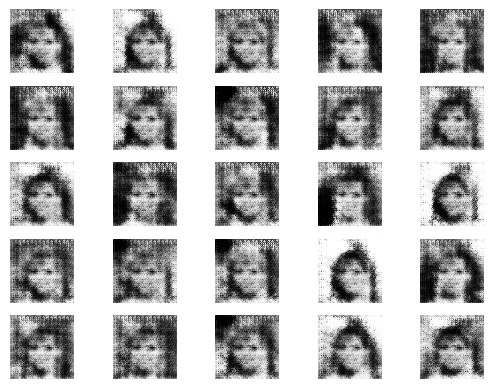

In [12]:
# Generar imágenes para mostrar
noise = np.random.normal(0, 1, (25, tamanio_codificacion))
gen_imgs = generador.predict(noise)

# Escalar imágenes a [0, 1]
gen_imgs = 0.5 * gen_imgs + 0.5

fig, axs = plt.subplots(5, 5)
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(gen_imgs[i * 5 + j, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
plt.show()

1/1 [==============================] - 0s 81ms/step


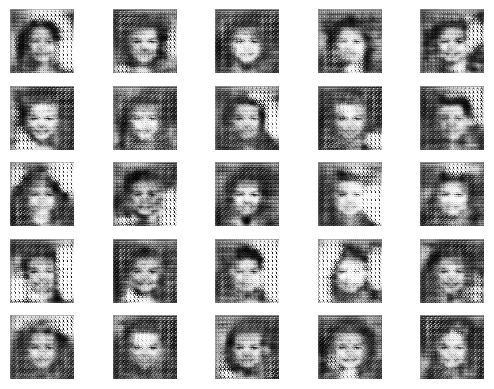

In [ ]:
# Generar imágenes para mostrar
noise = np.random.normal(0, 1, (25, tamanio_codificacion))
gen_imgs = generador.predict(noise)

# Escalar imágenes a [0, 1]
gen_imgs = 0.5 * gen_imgs + 0.5

fig, axs = plt.subplots(5, 5)
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(gen_imgs[i * 5 + j, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
plt.show()

--------
### **Reflexión**

Reflexione sobre lo aprendido en la sesión teórica y cómo se aplicó en el laboratorio. Algunos 
puntos que podrían considerar en su reflexión incluyen:

1. ¿Qué conceptos de la teoría encontraron más desafiantes y por qué?

En este laboratorio, se usó diferentes técnicas, redes neuronales, y herramientas conocidas para poder crear un GAN (Generative Adversarial Network). Sin embargo, durante la elaboración del mismo encontramos ciertos aspectos de la teoría que fueron confusos o desafiantes. 

Por ejemplo, en clase aprendimos que el generador (durante su entrenamiento) nunca llega a ver las imágenes reales. Sin embargo, a la hora de realizar el código fue un poco confuso y desafiante terminar de comprender cómo el generador aprendía si nunca miraba las imágenes. Esto principalmente debido a que cuando aprendimos sobre CNNs, siempre le pasábamos las imágenes reales para que pudiera detectar los patrones presentes. En este caso, para terminar de comprender tuvimos que revisar los ejemplos colocados en Canvas para observar cómo se realiza el proceso de entrenamiento y confirmar que si se pueden obtener buenos resultados con este método. 

Otro aspecto desafiante de la teoría era el colapso de modo. Como se aprendió en clase, las GAN tienen una desventaja de que el generador produce unas pocas imágenes con las cuales puede “tontear” al discriminador. Esto causa que el generador solo produzca imágenes similares a esta. En clase se indicó que utilizar Deep Convolutional GANs puede resolver dicho problema. Sin embargo, nosotros implementamos este tipo de red neuronal y creemos que no terminó de solucionar el problema. Como resultado, sí encontramos este aspecto un poco confuso y frustrante. Esto especialmente considerando el tiempo que se tardaba el modelo para entrenar (más de 2 horas, ya que se usó todas las imágenes).

2. ¿Cómo les ayudó el laboratorio a consolidar o entender mejor estos conceptos?

Como se mencionó anteriormente, el proceso de entrenamiento de las GAN es completamente diferente a como hemos entrenado redes neuronales en el pasado. Este laboratorio nos ayudó a terminar de comprender la teoría y porque se entrena el modelo por pasos; primero el discriminador y luego el generador. Asimismo, nos obligó a revisar ejemplos y más recursos para poder crear un modelo propio capaz de generar nuevos rostros.

3. ¿Qué aplicaciones potenciales ven para las GANs en la industria o en la investigación?

4. ¿Qué limitaciones o preocupaciones éticas pueden identificar en el uso de GANs?


5. ¿Cómo se sienten con respecto a la implementación y entrenamiento de GANs después de la  experiencia práctica?